## Mnist

In [ ]:
from keras.datasets import mnist

# Load the MNIST dataset
(_, _), (x_test, y_test) = mnist.load_data()

# MNIST classes
mnist_classes = [str(i) for i in range(10)]

# Print details of MNIST dataset
print("MNIST dataset details:")
print("Number of images in the test set:", len(x_test))
print("Shape of each image:", x_test[0].shape)
print("Number of classes:", len(mnist_classes))
print("MNIST classes:")
for i, class_name in enumerate(mnist_classes):
    print(f"Class {i}: {class_name}")


MNIST dataset details:
Number of images in the test set: 10000
Shape of each image: (28, 28)
Number of classes: 10
MNIST classes:
Class 0: 0
Class 1: 1
Class 2: 2
Class 3: 3
Class 4: 4
Class 5: 5
Class 6: 6
Class 7: 7
Class 8: 8
Class 9: 9


In [ ]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
from keras.datasets import mnist
from keras.datasets import cifar10
import matplotlib.pyplot as plt

MAX_STEPS = 20
WINDOW_SIZE = 7
RANDOM_LOC = False



class MNISTEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, type='train', seed=2069):

        if seed:
            np.random.seed(seed=seed)

        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        if type == 'train':
            self.X = x_train
            self.Y = y_train
            self.n = len(y_train)

        elif type == 'test':
            self.X = x_test
            self.Y = y_test
            self.n = len(y_test)

        h, w = self.X[0].shape
        self.h = h // WINDOW_SIZE
        self.w = w // WINDOW_SIZE

        self.mask = np.zeros((h, w))

        # action is an integer in {0, ..., 39}
        # see 'step' for interpretation
        self.action_space = spaces.Discrete(40)
        self.observation_space = spaces.Box(0, 255, [h, w])

    def step(self, action):

        # action a consists of
        #   1. direction in {N, S, E, W}, determined by = a (mod 4)
        #   2. predicted class (0-9), determined by floor(a / 4)
        assert(self.action_space.contains(action))
        dir, Y_pred = action % 4, action // 4

        self.steps += 1

        move_map = {
            0: [-1, 0], # N
            1: [1, 0],  # S
            2: [0, 1],  # E
            3: [0, -1]  # W
        }

        # make move and reveal square
        self.pos = np.clip(self.pos + move_map[dir], 0, [self.h-1, self.w-1])
        self._reveal()

        # state (observation) consists of masked image (h x w)
        obs = self._get_obs()

        # -0.1 penalty for each additional timestep
        # +1.0 for correct guess
        reward = -0.1 + int(Y_pred == self.Y[self.i])

        # game ends if prediction is correct or max steps is reached
        done = Y_pred == self.Y[self.i] or self.steps >= MAX_STEPS

        # info is empty (for now)
        info = {}

        return obs, reward, done, info

    def reset(self):
        # resets the environment and returns initial observation
        # zero the mask, move to random location, and choose new image

        # initialize at random location or image center
        if RANDOM_LOC:
            self.pos = np.array([np.random.randint(self.h),
                                 np.random.randint(self.w)])
        else:
            self.pos = np.array([int(self.h / 2), int(self.w / 2)])

        self.mask[:, :] = 0
        self._reveal()
        self.i = np.random.randint(self.n)
        self.steps = 0

        return self._get_obs()

    def _get_obs(self):
        obs = self.X[self.i] * self.mask
        # Normalize the observation to the range [0, 255]
        obs = np.clip(obs, 0, 255)
        # Convert to float and scale to [0, 1]
        obs = obs.astype(np.float32) / 255.0
        assert self.observation_space.contains(obs)
        return obs

    def _reveal(self):
        # reveal the window at self.pos
        h, w = self.pos
        h_low, h_high = h * WINDOW_SIZE, (h + 1) * WINDOW_SIZE
        w_low, w_high = w * WINDOW_SIZE, (w + 1) * WINDOW_SIZE


        self.mask[h_low:h_high, w_low:w_high] = 1

    def render(self, mode='human', close=False):
        # display mask, full image, and masked image

        plt.figure(figsize=(10, 3))
        plt.suptitle("Step %d" % self.steps)

        plt.subplot(131)
        plt.imshow(255 * self.mask)
        plt.subplot(132)
        plt.imshow(self.X[self.i])
        plt.subplot(133)
        plt.imshow(self.X[self.i] * self.mask)

        plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import random
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class MNISTNet(nn.Module):

    def __init__(self):

        super(MNISTNet, self).__init__()

        same_padding = (5 - 1) // 2

        self.conv1 = nn.Conv2d(1, 10, 5, padding=same_padding)
        self.conv2 = nn.Conv2d(10, 10, 5, padding=same_padding)
        self.lin1  = nn.Linear(10 * 7 * 7, 50)

        self.out_dir = nn.Linear(50, 4)
        self.out_digit = nn.Linear(50, 10)
        self.out_critic = nn.Linear(50, 1)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = nn.MaxPool2d(2)(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = nn.MaxPool2d(2)(x)

        x = x.view(-1, 10 * 7 * 7)
        x = self.lin1(x)

        pi1 = self.out_digit(x)
        pi1 = F.softmax(pi1, dim=-1)

        pi2 = self.out_dir(x)
        pi2 = F.softmax(pi2, dim=-1)
        y1 = torch.bmm(pi1.unsqueeze(2), pi2.unsqueeze(1))
        y1 = y1.view(-1, 40)

        y2 = self.out_critic(x)

        return y1, y2

def torch_to_numpy(tensor):
    return tensor.data.numpy()

def numpy_to_torch(array):
    return torch.tensor(array).float()

class ActorCriticNNAgent:
    def __init__(self, new_network, params=None, obs_to_input=lambda x: x,
                 lr=1e-3, df=0.5, alpha=0.5):

        # model and parameters
        if params is not None:
            self.model = new_network(params)
        else:
            self.model = new_network()
        if isinstance(self.model, torch.nn.Module):
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.df = df # discount factor
        self.alpha = alpha # multiply critic updates by this factor

        # initialize replay history
        self.replay = []

        # function that converts observation into input of dimension D_in
        self.obs_to_input = obs_to_input

        # if trainable is changed to false, the model won't be updated
        self.trainable = True

    def act(self, o, env=None, display=False):

        # feed observation as input to net to get distribution as output
        x = self.obs_to_input(o)
        x = numpy_to_torch([x])
        y1, y2 = self.model(x)

        pi = torch_to_numpy(y1).flatten()
        v  = torch_to_numpy(y2).squeeze()

        # sample action from distribution
        a = np.random.choice(np.arange(40), p=pi)

        if display:
            direction, digit = a % 4, a // 4
            pi1 = pi.reshape((10, 4)).sum(axis=0)
            pi2 = pi.reshape((10, 4)).sum(axis=1)

            print("")
            print("Sampled action:", (direction, digit))
            print("Value estimate:", v)
            print("Distributions:", pi1, pi2, sep='\n')

        # update current episode in replay with observation and chosen action
        if self.trainable:
            self.replay[-1]['observations'].append(o)
            self.replay[-1]['actions'].append(a)

        return np.array(a)

    def new_episode(self):
        # start a new episode in replay
        self.replay.append({'observations': [], 'actions': [], 'rewards': []})

    def store_reward(self, r):
        # insert 0s for actions that received no reward; end with reward r
        episode = self.replay[-1]
        T_no_reward = len(episode['actions']) - len(episode['rewards']) - 1
        episode['rewards'] += [0.0] * T_no_reward + [r]

    def _calculate_discounted_rewards(self):
        # calculate and store discounted rewards per episode

        for episode in self.replay:

            R = episode['rewards']
            R_disc = []
            R_sum = 0
            for r in R[::-1]:
                R_sum = r + self.df * R_sum
                R_disc.insert(0, R_sum)

            episode['rewards_disc'] = R_disc

    def update(self):

        assert(self.trainable)

        episode_losses = torch.tensor(0.0)
        N = len(self.replay)
        self._calculate_discounted_rewards()

        for episode in self.replay:

            O = episode['observations']
            A = episode['actions']
            R = numpy_to_torch(episode['rewards'])
            R_disc = numpy_to_torch(episode['rewards_disc'])
            T = len(R_disc)

            # forward pass, Y1 is pi(a | s), Y2 is V(s)
            X = numpy_to_torch([self.obs_to_input(o) for o in O])
            Y1, Y2 = self.model(X)
            pi = Y1
            Vs_curr = Y2.view(-1)

            # log probabilities of selected actions
            log_prob = torch.log(pi[np.arange(T), A])

            # advantage of selected actions over expected reward given state
            Vs_next = torch.cat((Vs_curr[1:], torch.tensor([0.])))
            adv = R + self.df * Vs_next - Vs_curr

            # ignore gradients so the critic isn't affected by actor loss
            adv = adv.detach()

            actor_loss = -torch.dot(log_prob, adv)
            critic_loss = torch.sum((R_disc - Vs_curr) ** 2)
            episode_losses += actor_loss + critic_loss * self.alpha

        # backward pass
        self.optimizer.zero_grad()
        loss = episode_losses / N
        loss.backward()
        self.optimizer.step()

        # reset the replay history
        self.replay = []

    def copy(self):

        # create a copy of this agent with frozen weights
        agent = ActorCriticNNAgent(lambda x: 0, 0, self.obs_to_input)
        agent.model = copy.deepcopy(self.model)
        agent.trainable = False
        for param in agent.model.parameters():
            param.requires_grad = False

        return agent


Training...
Starting iteration 0

Sampled action: (0, 9)
Value estimate: 0.04107013
Distributions:
[0.2646374  0.26321068 0.23254323 0.23960865]
[0.08428603 0.10020236 0.10949737 0.11255651 0.10395281 0.11446001
 0.09714147 0.09276322 0.08656171 0.09857853]


<ipython-input-18-ff60373c27a2>:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(array).float()


Actual reward: -0.1

Sampled action: (1, 3)
Value estimate: 0.067112215
Distributions:
[0.26683968 0.2606249  0.23700012 0.23553543]
[0.08345898 0.09898227 0.10867649 0.11094267 0.10392049 0.11667696
 0.09921128 0.09310435 0.08558346 0.09944314]
Actual reward: -0.1

Sampled action: (0, 4)
Value estimate: 0.067112215
Distributions:
[0.26683968 0.2606249  0.23700012 0.23553543]
[0.08345898 0.09898227 0.10867649 0.11094267 0.10392049 0.11667696
 0.09921128 0.09310435 0.08558346 0.09944314]
Actual reward: -0.1

Sampled action: (1, 3)
Value estimate: 0.067112215
Distributions:
[0.26683968 0.2606249  0.23700012 0.23553543]
[0.08345898 0.09898227 0.10867649 0.11094267 0.10392049 0.11667696
 0.09921128 0.09310435 0.08558346 0.09944314]
Actual reward: -0.1

Sampled action: (0, 6)
Value estimate: 0.067112215
Distributions:
[0.26683968 0.2606249  0.23700012 0.23553543]
[0.08345898 0.09898227 0.10867649 0.11094267 0.10392049 0.11667696
 0.09921128 0.09310435 0.08558346 0.09944314]
Actual reward: -

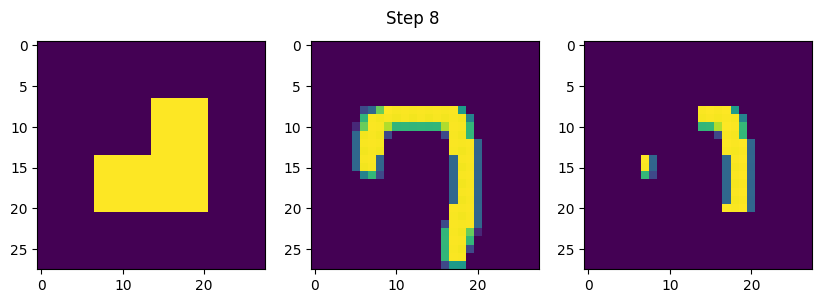

Mean total reward / episode: -0.084
Starting iteration 10

Sampled action: (2, 3)
Value estimate: -0.02616486
Distributions:
[0.28739873 0.23765124 0.22069019 0.2542599 ]
[0.09320227 0.09734032 0.10739269 0.10800478 0.09776893 0.10492992
 0.11392917 0.08771911 0.07483497 0.11487792]
Actual reward: -0.1

Sampled action: (1, 6)
Value estimate: -0.03641717
Distributions:
[0.28866884 0.23654963 0.21914046 0.25564095]
[0.0937634  0.09793658 0.10784809 0.10798401 0.09770911 0.10511841
 0.11287236 0.0879015  0.07508969 0.11377674]
Actual reward: -0.1

Sampled action: (0, 8)
Value estimate: -0.03641717
Distributions:
[0.28866884 0.23654963 0.21914046 0.25564095]
[0.0937634  0.09793658 0.10784809 0.10798401 0.09770911 0.10511841
 0.11287236 0.0879015  0.07508969 0.11377674]
Actual reward: -0.1

Sampled action: (3, 3)
Value estimate: -0.03641717
Distributions:
[0.28866884 0.23654963 0.21914046 0.25564095]
[0.0937634  0.09793658 0.10784809 0.10798401 0.09770911 0.10511841
 0.11287236 0.0879015  0

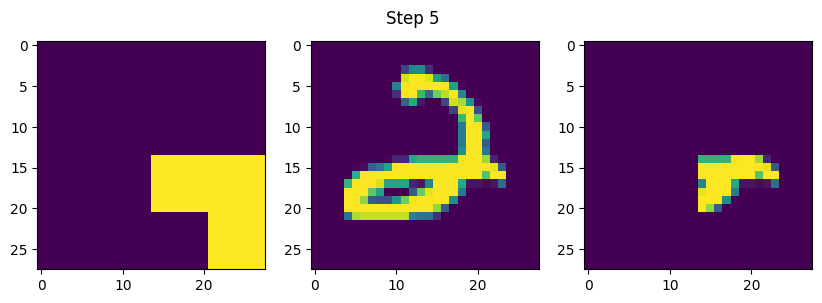

Mean total reward / episode: 0.016
Starting iteration 20

Sampled action: (2, 8)
Value estimate: -0.011383668
Distributions:
[0.28446367 0.23307799 0.20040354 0.2820549 ]
[0.08866764 0.0953787  0.1079711  0.10682569 0.09682182 0.10536891
 0.1112648  0.09060787 0.07960506 0.1174885 ]
Actual reward: -0.1

Sampled action: (1, 2)
Value estimate: -0.011383668
Distributions:
[0.28446367 0.23307799 0.20040354 0.2820549 ]
[0.08866764 0.0953787  0.1079711  0.10682569 0.09682182 0.10536891
 0.1112648  0.09060787 0.07960506 0.1174885 ]
Actual reward: -0.1

Sampled action: (3, 3)
Value estimate: -0.011383668
Distributions:
[0.28446367 0.23307799 0.20040354 0.2820549 ]
[0.08866764 0.0953787  0.1079711  0.10682569 0.09682182 0.10536891
 0.1112648  0.09060787 0.07960506 0.1174885 ]
Actual reward: -0.1

Sampled action: (2, 6)
Value estimate: -0.011383668
Distributions:
[0.28446367 0.23307799 0.20040354 0.2820549 ]
[0.08866764 0.0953787  0.1079711  0.10682569 0.09682182 0.10536891
 0.1112648  0.0906078

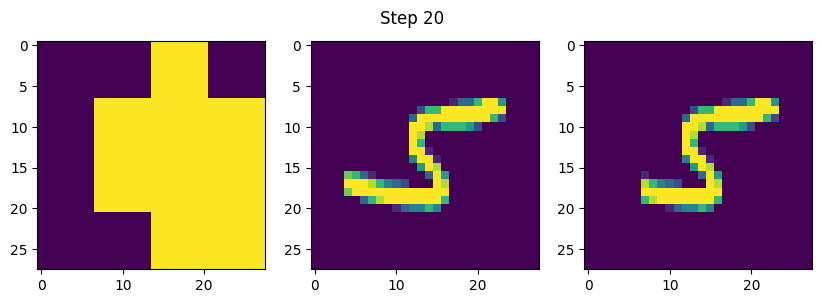

Mean total reward / episode: -0.194
Starting iteration 30

Sampled action: (2, 5)
Value estimate: 0.021582954
Distributions:
[0.29007924 0.23274776 0.20127706 0.27589592]
[0.09581424 0.08920765 0.10569273 0.11303503 0.10175192 0.10601477
 0.11141779 0.08785366 0.08027885 0.10893334]
Actual reward: -0.1

Sampled action: (0, 2)
Value estimate: 0.006786246
Distributions:
[0.3014447  0.21331765 0.19828577 0.28695166]
[0.10753711 0.08307221 0.10471091 0.11772326 0.10218406 0.10327084
 0.11651984 0.08343582 0.07364596 0.10789978]
Actual reward: -0.1

Sampled action: (3, 3)
Value estimate: -0.0143953115
Distributions:
[0.32136476 0.19601811 0.1883639  0.29425326]
[0.12423754 0.07824671 0.0965432  0.11840998 0.10404849 0.09775129
 0.11956689 0.0816128  0.06836537 0.1112178 ]
Actual reward: -0.1

Sampled action: (0, 6)
Value estimate: 0.0041030347
Distributions:
[0.3295192  0.18947117 0.17568707 0.30532256]
[0.12921184 0.07857767 0.0927377  0.11853369 0.10411492 0.09357851
 0.11483899 0.0842282

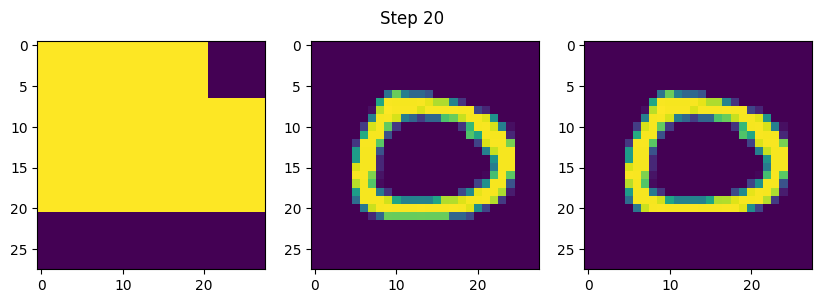

Mean total reward / episode: 0.272
Starting iteration 40

Sampled action: (2, 5)
Value estimate: 0.051800318
Distributions:
[0.3059866  0.24020493 0.17976695 0.2740416 ]
[0.07701419 0.1044331  0.09708675 0.08608014 0.11988921 0.09555378
 0.09193677 0.10156883 0.09590006 0.13053727]
Actual reward: -0.1

Sampled action: (1, 1)
Value estimate: 0.051800318
Distributions:
[0.3059866  0.24020493 0.17976695 0.2740416 ]
[0.07701419 0.1044331  0.09708675 0.08608014 0.11988921 0.09555378
 0.09193677 0.10156883 0.09590006 0.13053727]
Actual reward: -0.1

Sampled action: (3, 6)
Value estimate: 0.051800318
Distributions:
[0.3059866  0.24020493 0.17976695 0.2740416 ]
[0.07701419 0.1044331  0.09708675 0.08608014 0.11988921 0.09555378
 0.09193677 0.10156883 0.09590006 0.13053727]
Actual reward: -0.1

Sampled action: (2, 3)
Value estimate: 0.051462762
Distributions:
[0.30620304 0.24008916 0.17959122 0.27411652]
[0.07696039 0.10451186 0.09718812 0.08590895 0.1198767  0.09556156
 0.09188926 0.1015757  0.

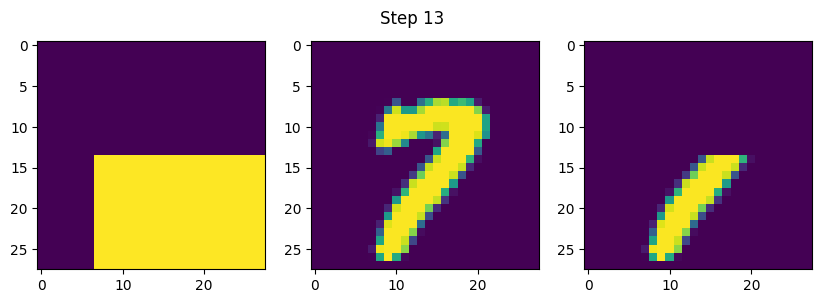

Mean total reward / episode: 0.187
Starting iteration 50

Sampled action: (1, 8)
Value estimate: 0.006404113
Distributions:
[0.30644995 0.2614946  0.15823077 0.2738247 ]
[0.05426824 0.12348732 0.08559401 0.06301716 0.1330041  0.07732907
 0.06864576 0.12034652 0.11620806 0.15809977]
Actual reward: -0.1

Sampled action: (0, 7)
Value estimate: 0.006105926
Distributions:
[0.30663937 0.26138067 0.15810768 0.27387226]
[0.05422655 0.12344439 0.08554699 0.06289107 0.13315769 0.07724077
 0.06868711 0.12041546 0.1162101  0.15817986]
Actual reward: -0.1

Sampled action: (0, 3)
Value estimate: 0.006105926
Distributions:
[0.30663937 0.26138067 0.15810768 0.27387226]
[0.05422655 0.12344439 0.08554699 0.06289107 0.13315769 0.07724077
 0.06868711 0.12041546 0.1162101  0.15817986]
Actual reward: -0.1

Sampled action: (3, 4)
Value estimate: 0.012813393
Distributions:
[0.3565085  0.19415812 0.09561897 0.35371444]
[0.08161271 0.11898625 0.05227967 0.0530365  0.14006107 0.04590627
 0.0359053  0.13949153 0.

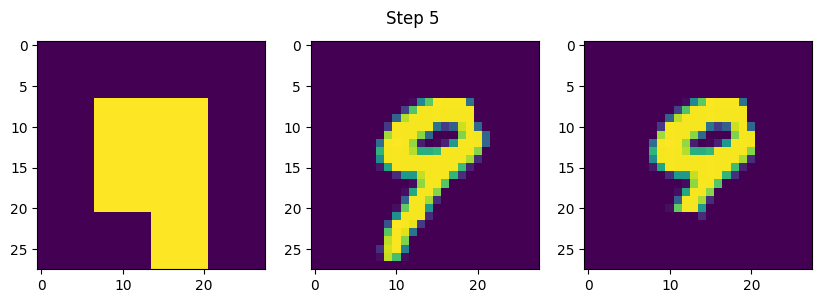

Mean total reward / episode: 0.419
Starting iteration 60

Sampled action: (3, 0)
Value estimate: 0.059667535
Distributions:
[0.32506752 0.17161505 0.20312175 0.30019572]
[0.14431046 0.03923415 0.1111812  0.14826953 0.11370377 0.10196799
 0.13265133 0.0624292  0.0605896  0.08566283]
Actual reward: -0.1

Sampled action: (0, 3)
Value estimate: 0.14069384
Distributions:
[0.40492228 0.13593978 0.15656744 0.30257052]
[0.1595994  0.05902112 0.18587652 0.07399341 0.07595732 0.09625123
 0.1366359  0.05858706 0.10073651 0.05334147]
Actual reward: -0.1

Sampled action: (0, 3)
Value estimate: 0.29663873
Distributions:
[0.46359637 0.13781627 0.09887258 0.2997148 ]
[0.15109614 0.04905859 0.10186768 0.05251876 0.09919946 0.06014666
 0.08544932 0.14561209 0.21471488 0.04033644]
Actual reward: -0.1

Sampled action: (2, 8)
Value estimate: 0.30878395
Distributions:
[0.5021133  0.12651302 0.06139154 0.30998203]
[0.13351111 0.0632657  0.09849173 0.05378118 0.06222613 0.04421899
 0.0600765  0.16063182 0.293

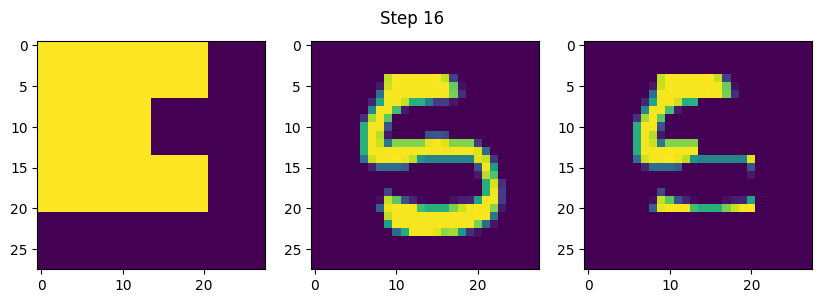

Mean total reward / episode: 0.338
Starting iteration 70

Sampled action: (1, 1)
Value estimate: -0.0352065
Distributions:
[0.36573443 0.2713475  0.15688398 0.20603412]
[0.02813157 0.18514289 0.10256818 0.05469218 0.09876333 0.07493863
 0.06133319 0.12786932 0.14834009 0.11822063]
Actual reward: -0.1

Sampled action: (2, 2)
Value estimate: -0.12968493
Distributions:
[0.41074625 0.21143024 0.16268067 0.21514289]
[0.04459468 0.0810602  0.09367888 0.0934316  0.12278907 0.10882246
 0.1065244  0.09979114 0.12445503 0.12485258]
Actual reward: -0.1

Sampled action: (1, 4)
Value estimate: -0.12968493
Distributions:
[0.41074625 0.21143024 0.16268067 0.21514289]
[0.04459468 0.0810602  0.09367888 0.0934316  0.12278907 0.10882246
 0.1065244  0.09979114 0.12445503 0.12485258]
Actual reward: -0.1

Sampled action: (0, 2)
Value estimate: -0.12968493
Distributions:
[0.41074625 0.21143024 0.16268067 0.21514289]
[0.04459468 0.0810602  0.09367888 0.0934316  0.12278907 0.10882246
 0.1065244  0.09979114 0.1

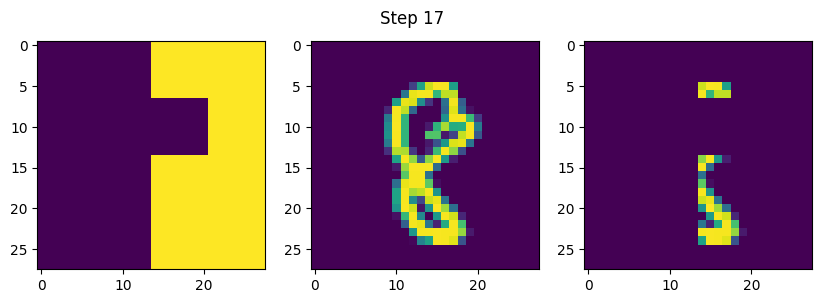

Mean total reward / episode: 0.294
Starting iteration 80

Sampled action: (0, 1)
Value estimate: 0.05072855
Distributions:
[0.4141383  0.31197003 0.11653356 0.15735811]
[0.0077579  0.40247416 0.05990591 0.02064316 0.05769175 0.03522002
 0.02560871 0.13278756 0.16897191 0.08893891]
Actual reward: 0.9


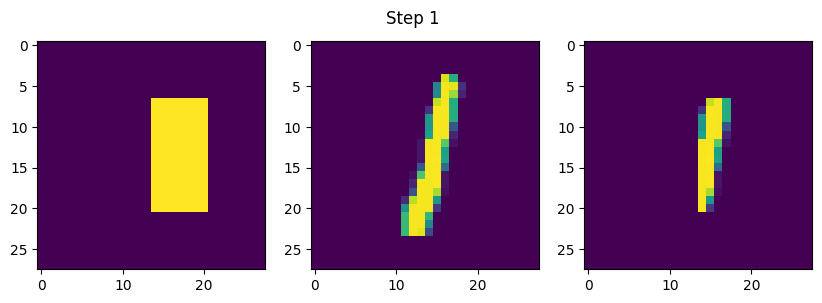

Mean total reward / episode: 0.450
Starting iteration 90

Sampled action: (3, 4)
Value estimate: -0.009733401
Distributions:
[0.29642677 0.25527576 0.17990395 0.26839352]
[0.01208152 0.02833397 0.06639885 0.06322066 0.25721616 0.07163112
 0.09086327 0.12015373 0.0994038  0.19069692]
Actual reward: -0.1

Sampled action: (0, 6)
Value estimate: 0.07163276
Distributions:
[0.46647406 0.12982774 0.11157176 0.29212648]
[0.03800594 0.04186663 0.22700655 0.03621812 0.10374516 0.08597939
 0.17197724 0.05054586 0.18843263 0.05622247]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: 0.07772358
Distributions:
[0.45737427 0.20600794 0.05739079 0.27922708]
[0.02738539 0.03420558 0.08905074 0.03563665 0.07636    0.1051097
 0.07783711 0.1107797  0.40756238 0.03607286]
Actual reward: 0.9


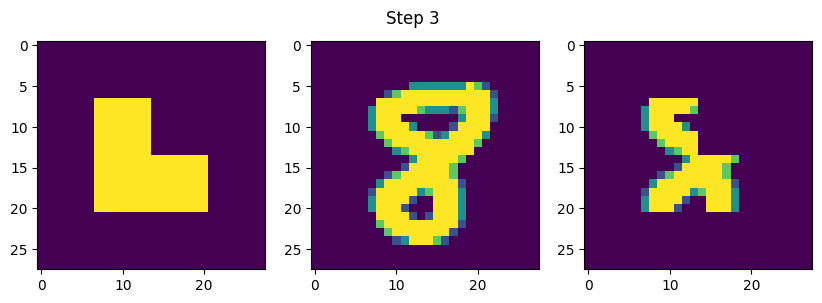

Mean total reward / episode: 0.125
Starting iteration 100

Sampled action: (3, 6)
Value estimate: 0.14819165
Distributions:
[0.20805691 0.09067763 0.22994019 0.47132522]
[0.15662418 0.00128146 0.1576592  0.14936617 0.04864389 0.09000278
 0.34425095 0.00851293 0.01475009 0.02890836]
Actual reward: 0.9


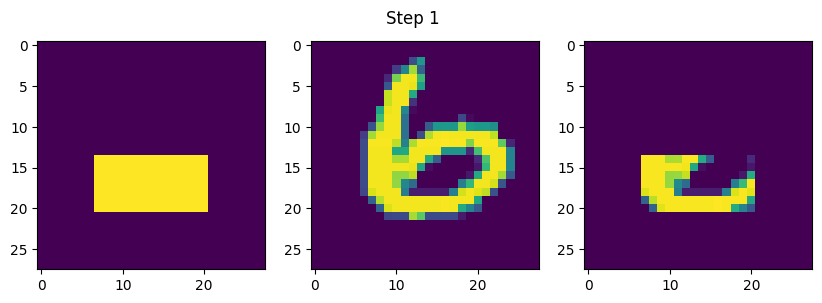

Mean total reward / episode: 0.475
Starting iteration 110

Sampled action: (1, 3)
Value estimate: -0.024226233
Distributions:
[0.21376844 0.31198683 0.14001745 0.33422732]
[0.0020225  0.01361363 0.0273293  0.03754507 0.24366544 0.03024539
 0.04530233 0.21372268 0.06297399 0.32357967]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: -0.037914917
Distributions:
[0.2723878  0.31360784 0.10171703 0.3122873 ]
[0.00122949 0.01736143 0.01483661 0.02103258 0.21094637 0.02341429
 0.03095896 0.32560796 0.07617118 0.2784411 ]
Actual reward: -0.1

Sampled action: (2, 9)
Value estimate: -0.037914917
Distributions:
[0.2723878  0.31360784 0.10171703 0.3122873 ]
[0.00122949 0.01736143 0.01483661 0.02103258 0.21094637 0.02341429
 0.03095896 0.32560796 0.07617118 0.2784411 ]
Actual reward: 0.9


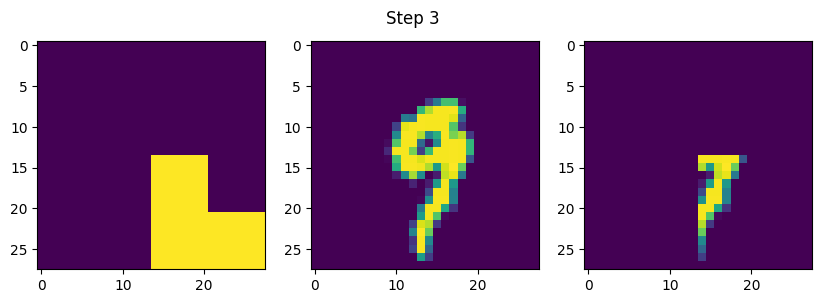

Mean total reward / episode: 0.666
Starting iteration 120

Sampled action: (1, 3)
Value estimate: 0.024416309
Distributions:
[0.10312244 0.21718438 0.23388232 0.44581085]
[6.2341247e-02 1.6051554e-04 3.2916941e-02 2.1916357e-01 2.4204832e-01
 8.7630227e-02 1.7633547e-01 5.5950075e-02 1.2092881e-02 1.1136076e-01]
Actual reward: -0.1

Sampled action: (3, 4)
Value estimate: 0.049215656
Distributions:
[0.13336496 0.21942855 0.18450016 0.46270645]
[5.14954701e-02 2.23263167e-04 2.44502649e-02 1.54679343e-01
 2.60336220e-01 9.48599130e-02 1.76923305e-01 1.00184515e-01
 1.73813310e-02 1.19466469e-01]
Actual reward: -0.1

Sampled action: (3, 6)
Value estimate: -0.07423429
Distributions:
[0.23135257 0.1218226  0.06478816 0.5820366 ]
[0.2190036  0.00025382 0.09207484 0.2179419  0.05442115 0.20759542
 0.1283906  0.03409407 0.03067442 0.01555018]
Actual reward: -0.1

Sampled action: (3, 6)
Value estimate: -0.06647082
Distributions:
[0.2283773  0.11437056 0.06182264 0.5954294 ]
[2.41838813e-01 2.24

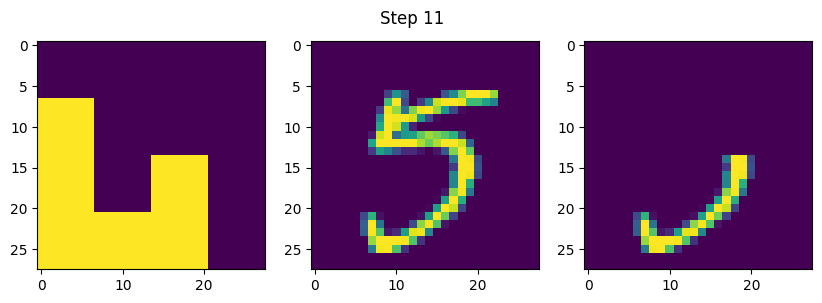

Mean total reward / episode: 0.378
Starting iteration 130

Sampled action: (2, 0)
Value estimate: 0.11539015
Distributions:
[0.12611687 0.14641742 0.17709357 0.5503721 ]
[3.61575425e-01 1.27400635e-05 3.10342424e-02 3.02669466e-01
 4.64629903e-02 8.56133550e-02 1.47510588e-01 5.83514152e-03
 3.52851069e-03 1.57575272e-02]
Actual reward: 0.9


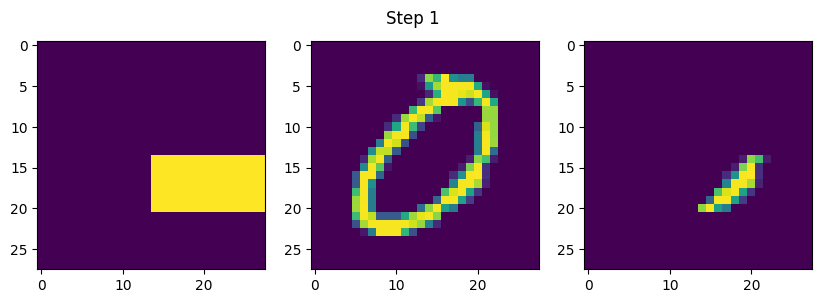

Mean total reward / episode: 0.269
Starting iteration 140

Sampled action: (1, 5)
Value estimate: 0.044110533
Distributions:
[0.27177557 0.166456   0.1914275  0.37034106]
[0.24544883 0.00941457 0.20084509 0.18484277 0.0264586  0.14613235
 0.10699311 0.01388134 0.03841147 0.02757191]
Actual reward: -0.1

Sampled action: (3, 6)
Value estimate: 0.046070177
Distributions:
[0.30468965 0.08583735 0.09450288 0.51497006]
[0.32688385 0.00041925 0.21646857 0.13839333 0.00553968 0.16000493
 0.12232444 0.00193956 0.01954044 0.00848589]
Actual reward: -0.1

Sampled action: (3, 0)
Value estimate: -0.022293229
Distributions:
[0.3565925  0.03107979 0.02501196 0.5873158 ]
[3.3594745e-01 1.3088931e-04 4.1622353e-01 5.1638357e-02 6.2571187e-04
 1.1244184e-01 6.6524409e-02 2.1705263e-04 1.5551336e-02 6.9943210e-04]
Actual reward: 0.9


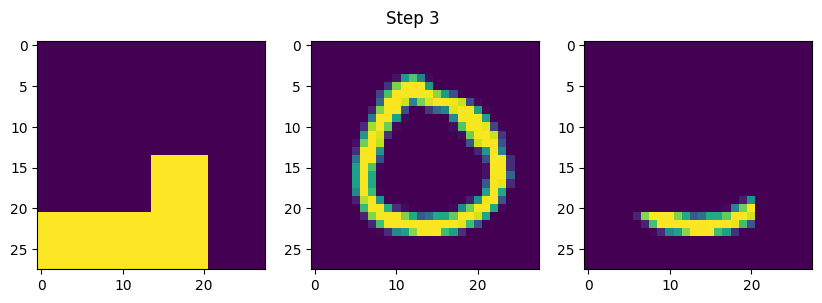

Mean total reward / episode: 0.066
Starting iteration 150

Sampled action: (1, 9)
Value estimate: 0.08424209
Distributions:
[0.17284162 0.36283836 0.12320503 0.34111494]
[0.01803462 0.00563136 0.14341882 0.25143385 0.08703694 0.08059019
 0.17004487 0.0629601  0.05893324 0.12191595]
Actual reward: -0.1

Sampled action: (0, 2)
Value estimate: 0.08424209
Distributions:
[0.17284162 0.36283836 0.12320503 0.34111494]
[0.01803462 0.00563136 0.14341882 0.25143385 0.08703694 0.08059019
 0.17004487 0.0629601  0.05893324 0.12191595]
Actual reward: 0.9


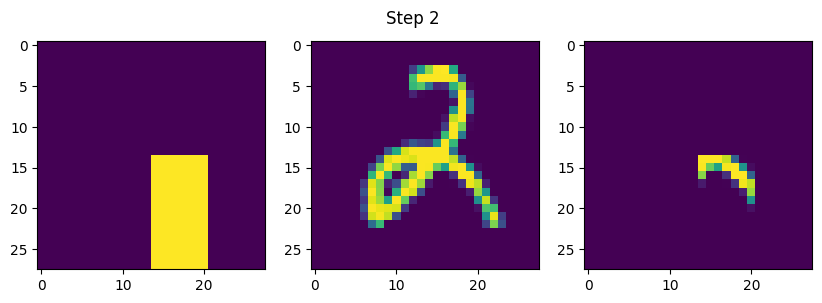

Mean total reward / episode: 0.459
Starting iteration 160

Sampled action: (0, 0)
Value estimate: 0.11162908
Distributions:
[0.16298477 0.30207455 0.1400607  0.39487997]
[3.2757169e-01 1.5339061e-05 2.9805981e-02 3.4229159e-01 7.0664227e-02
 6.1360620e-02 1.1158709e-01 1.7587107e-02 9.7454917e-03 2.9370766e-02]
Actual reward: 0.9


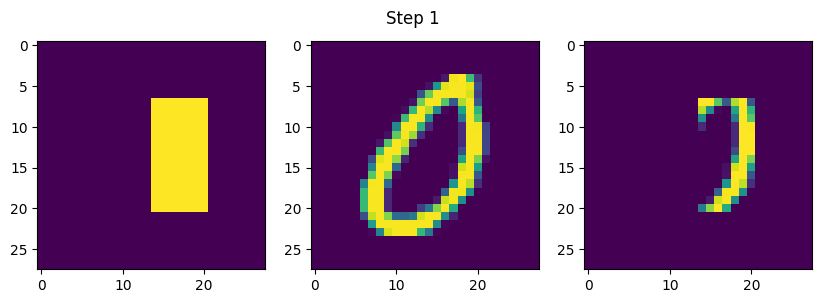

Mean total reward / episode: 0.381
Starting iteration 170

Sampled action: (3, 0)
Value estimate: 0.06757231
Distributions:
[0.28161734 0.13097258 0.1656975  0.42171258]
[7.8012955e-01 1.6572525e-07 8.4793661e-03 1.0242796e-01 4.2590457e-03
 1.6069099e-02 8.6411200e-02 4.2352898e-04 8.6991192e-04 9.3009660e-04]
Actual reward: 0.9


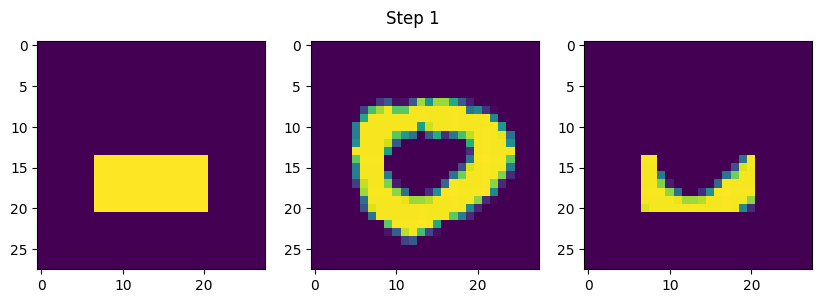

Mean total reward / episode: 0.506
Starting iteration 180

Sampled action: (3, 8)
Value estimate: 0.24800476
Distributions:
[0.12753247 0.22216763 0.03086791 0.61943215]
[2.4698149e-05 8.7936294e-01 1.7133888e-02 8.8103954e-04 6.3291155e-03
 4.0475330e-03 3.5342993e-03 2.5265459e-02 4.8532449e-02 1.4888800e-02]
Actual reward: -0.1

Sampled action: (3, 1)
Value estimate: 0.3044571
Distributions:
[0.10099682 0.15644816 0.01472241 0.72783256]
[3.2339708e-06 8.9826930e-01 1.5484738e-02 2.2400958e-04 3.4169452e-03
 1.8709659e-03 3.1775208e-03 1.3807083e-02 5.5393726e-02 8.3525795e-03]
Actual reward: 0.9


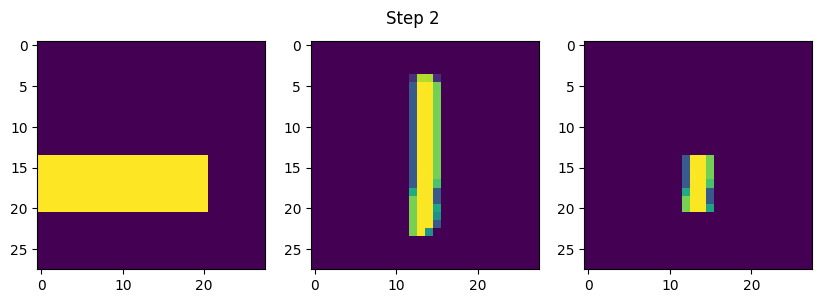

Mean total reward / episode: 0.497
Starting iteration 190

Sampled action: (0, 1)
Value estimate: 0.030771531
Distributions:
[0.12382381 0.1270718  0.02830446 0.7207999 ]
[5.29743120e-05 8.88866127e-01 2.77008265e-02 1.36249955e-03
 4.96294023e-03 4.71650623e-03 5.00557292e-03 2.09075715e-02
 3.14662009e-02 1.49586955e-02]
Actual reward: -0.1

Sampled action: (3, 1)
Value estimate: -0.0061864927
Distributions:
[0.03859997 0.05758512 0.00341743 0.90039754]
[1.3739548e-06 9.7361958e-01 6.4459504e-03 2.6186288e-04 4.2562446e-05
 1.9449878e-03 1.9870039e-04 1.4454968e-03 1.5406023e-02 6.3344417e-04]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: -0.05212964
Distributions:
[0.0338561  0.05344234 0.00185639 0.91084516]
[8.6587379e-06 6.5812594e-01 9.4281398e-03 1.6620457e-03 1.3641289e-03
 5.1069729e-02 1.3327310e-03 4.1666511e-02 2.1732691e-01 1.8015211e-02]
Actual reward: -0.1

Sampled action: (3, 1)
Value estimate: -0.05212964
Distributions:
[0.0338561  0.05344234 0.00185639 

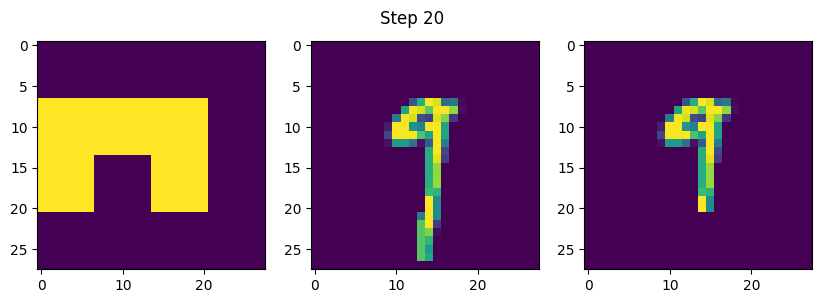

Mean total reward / episode: 0.228
Completed 200 iterations of 32 episodes in 123.029 s
Testing...
Mean total reward / episode: 0.493
Evaluating...

Sampled action: (3, 4)
Value estimate: -0.0031107739
Distributions:
[0.14240113 0.4178209  0.04162347 0.3981545 ]
[5.5769626e-03 4.7001460e-05 2.1993926e-02 5.3704762e-01 1.4488161e-01
 3.3866998e-02 5.5242859e-02 6.4657211e-02 2.5724554e-02 1.1096132e-01]
Received reward -0.1 on step 1


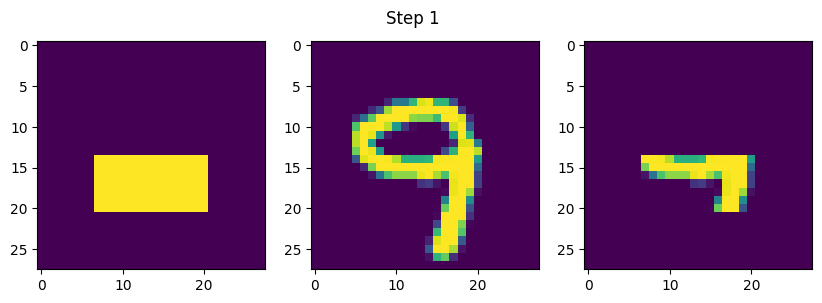


Sampled action: (3, 4)
Value estimate: -0.12034396
Distributions:
[0.26060277 0.3010521  0.03996302 0.39838213]
[2.13531870e-03 6.23013534e-07 3.44404019e-03 5.67293242e-02
 6.04074180e-01 1.78697463e-02 2.49953736e-02 1.29616195e-02
 7.33470498e-03 2.70455003e-01]
Received reward -0.1 on step 2


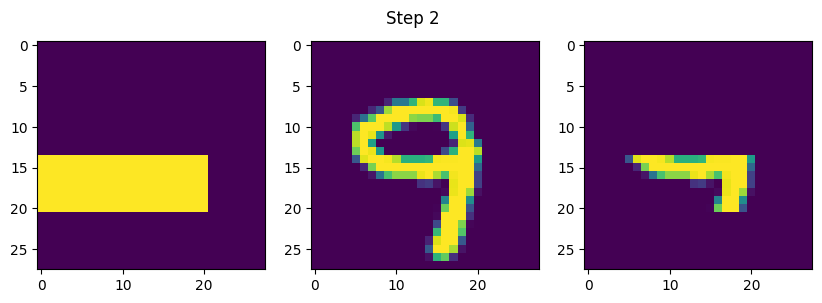


Sampled action: (3, 9)
Value estimate: -0.14283136
Distributions:
[0.26276058 0.2921211  0.03932759 0.40579075]
[1.8566626e-03 5.5405604e-07 2.7654909e-03 4.3799363e-02 6.2758064e-01
 1.4387441e-02 1.9125648e-02 1.3226025e-02 5.9781224e-03 2.7128002e-01]
Received reward 0.9 on step 3


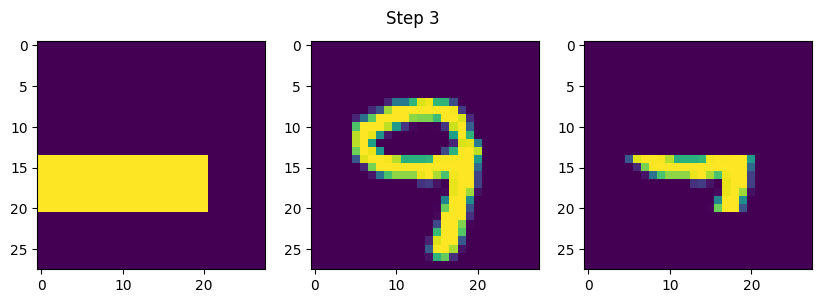


Sampled action: (0, 7)
Value estimate: 0.029548831
Distributions:
[0.10999574 0.3623067  0.03285133 0.4948461 ]
[0.00150439 0.00064824 0.01305566 0.14325336 0.23574942 0.02210181
 0.02007391 0.24410711 0.03257884 0.28692722]
Received reward -0.1 on step 1


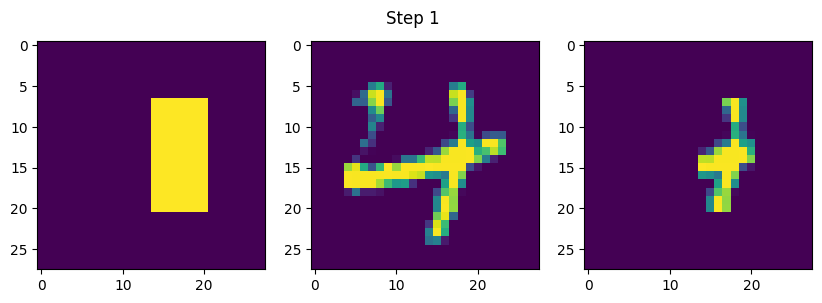


Sampled action: (3, 7)
Value estimate: -0.0036048666
Distributions:
[0.04858182 0.23543018 0.01078879 0.7051991 ]
[8.5944840e-04 1.5832462e-04 2.3765847e-02 1.8987414e-01 1.8759577e-01
 2.3593603e-02 7.9613207e-03 2.4355069e-01 4.0906936e-02 2.8173390e-01]
Received reward -0.1 on step 2


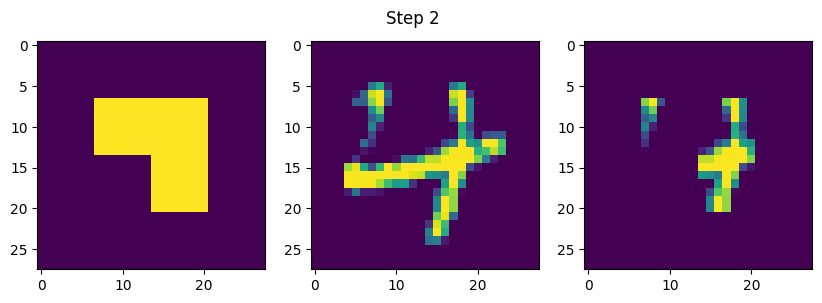


Sampled action: (3, 7)
Value estimate: -0.1336824
Distributions:
[0.03094454 0.16300213 0.00435724 0.8016961 ]
[8.2196129e-05 2.6445639e-05 3.9831186e-03 5.4889575e-02 1.9139589e-01
 8.6751673e-03 1.0694568e-03 4.6452296e-01 2.3820676e-02 2.5153455e-01]
Received reward -0.1 on step 3


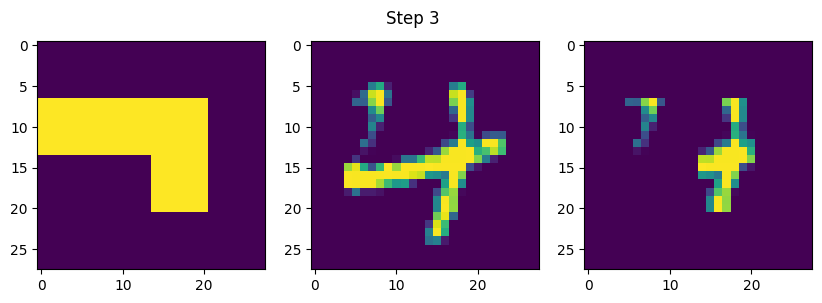


Sampled action: (3, 4)
Value estimate: -0.14998934
Distributions:
[0.0305741  0.16024452 0.00422646 0.804955  ]
[6.7904446e-05 2.3122320e-05 3.1945694e-03 4.5490459e-02 1.9310810e-01
 7.3051266e-03 8.3892862e-04 4.8478514e-01 2.0710761e-02 2.4447593e-01]
Received reward 0.9 on step 4


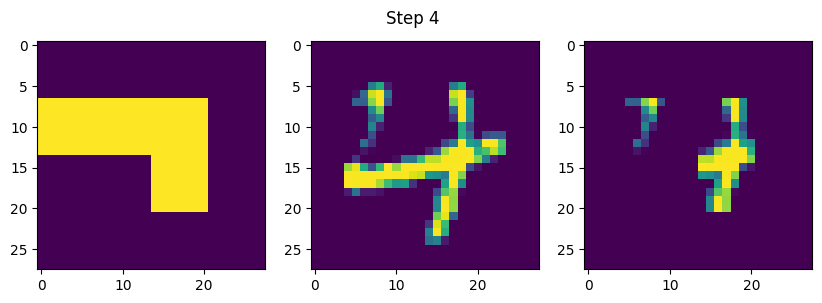


Sampled action: (3, 1)
Value estimate: 0.17449331
Distributions:
[0.12946033 0.1567076  0.028043   0.6857891 ]
[3.1341775e-04 5.7425356e-01 5.2903302e-02 1.1527502e-02 3.2240156e-02
 1.8533660e-02 1.2848037e-02 1.1252644e-01 9.0369031e-02 9.4484910e-02]
Received reward -0.1 on step 1


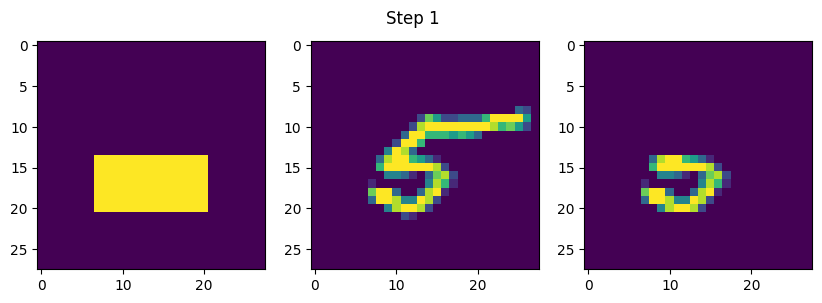


Sampled action: (3, 2)
Value estimate: 0.18045333
Distributions:
[0.31454927 0.05260686 0.01283173 0.62001216]
[0.00522572 0.01209648 0.21841764 0.01687777 0.07179812 0.16060595
 0.07017988 0.01813471 0.34399745 0.08266631]
Received reward -0.1 on step 2


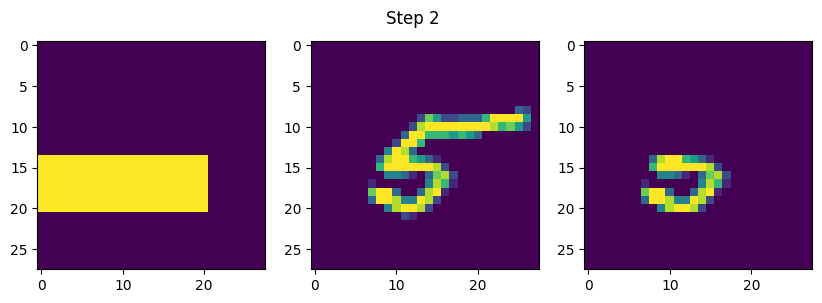


Sampled action: (0, 8)
Value estimate: 0.18045333
Distributions:
[0.31454927 0.05260686 0.01283173 0.62001216]
[0.00522572 0.01209648 0.21841764 0.01687777 0.07179812 0.16060595
 0.07017988 0.01813471 0.34399745 0.08266631]
Received reward -0.1 on step 3


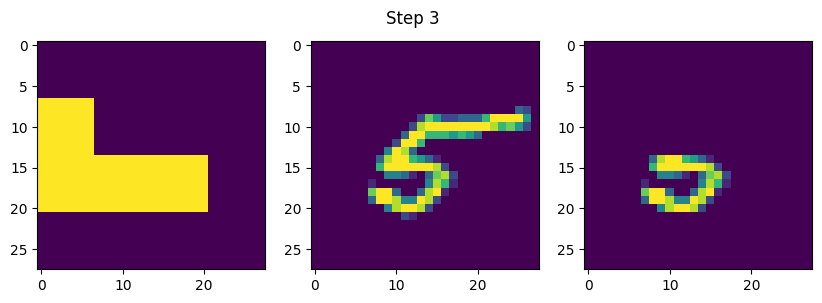


Sampled action: (3, 5)
Value estimate: 0.18045333
Distributions:
[0.31454927 0.05260686 0.01283173 0.62001216]
[0.00522572 0.01209648 0.21841764 0.01687777 0.07179812 0.16060595
 0.07017988 0.01813471 0.34399745 0.08266631]
Received reward 0.9 on step 4


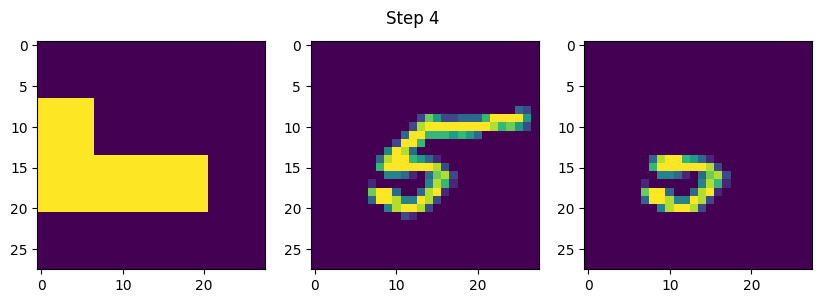


Sampled action: (1, 4)
Value estimate: 0.059161596
Distributions:
[0.07718199 0.33675027 0.0228975  0.5631702 ]
[3.80376936e-04 1.24563486e-03 1.49464775e-02 9.08695981e-02
 2.01956302e-01 1.65059268e-02 1.11164907e-02 2.46348739e-01
 3.54795977e-02 3.81150842e-01]
Received reward -0.1 on step 1


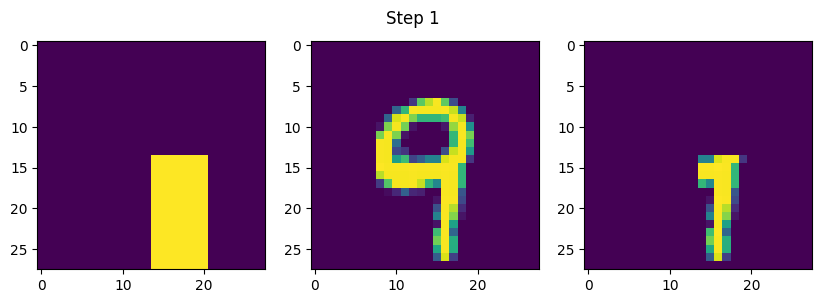


Sampled action: (1, 3)
Value estimate: 0.0056428537
Distributions:
[0.08617239 0.4111163  0.01095999 0.49175137]
[2.7408209e-04 2.7872343e-04 1.0315320e-03 8.5569963e-02 1.1368435e-01
 1.9472051e-02 1.8193945e-03 3.7555680e-01 3.6107369e-02 3.6620584e-01]
Received reward -0.1 on step 2


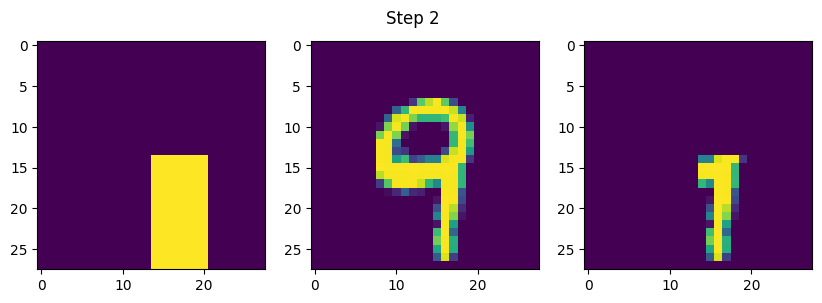


Sampled action: (3, 7)
Value estimate: 0.0056428537
Distributions:
[0.08617239 0.4111163  0.01095999 0.49175137]
[2.7408209e-04 2.7872343e-04 1.0315320e-03 8.5569963e-02 1.1368435e-01
 1.9472051e-02 1.8193945e-03 3.7555680e-01 3.6107369e-02 3.6620584e-01]
Received reward -0.1 on step 3


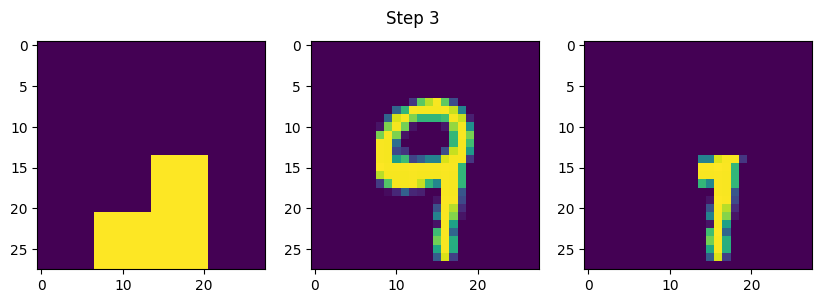


Sampled action: (1, 9)
Value estimate: 0.0056428537
Distributions:
[0.08617239 0.4111163  0.01095999 0.49175137]
[2.7408209e-04 2.7872343e-04 1.0315320e-03 8.5569963e-02 1.1368435e-01
 1.9472051e-02 1.8193945e-03 3.7555680e-01 3.6107369e-02 3.6620584e-01]
Received reward 0.9 on step 4


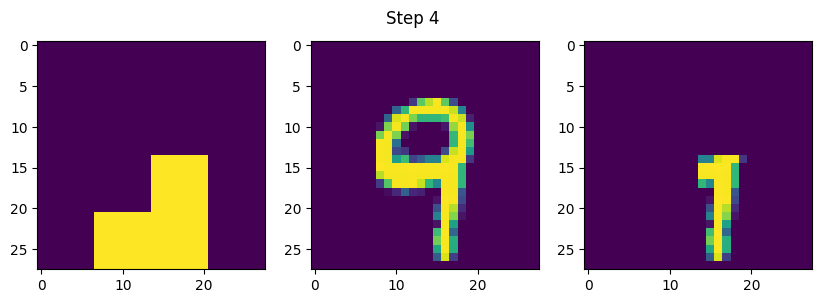


Sampled action: (3, 1)
Value estimate: 0.23432752
Distributions:
[0.07353441 0.08918421 0.00874424 0.8285372 ]
[5.9609029e-06 8.7821853e-01 1.0095573e-02 8.3383545e-04 5.1732832e-03
 2.1484911e-03 1.5997567e-03 4.4263765e-02 3.0936649e-02 2.6724255e-02]
Received reward 0.9 on step 1


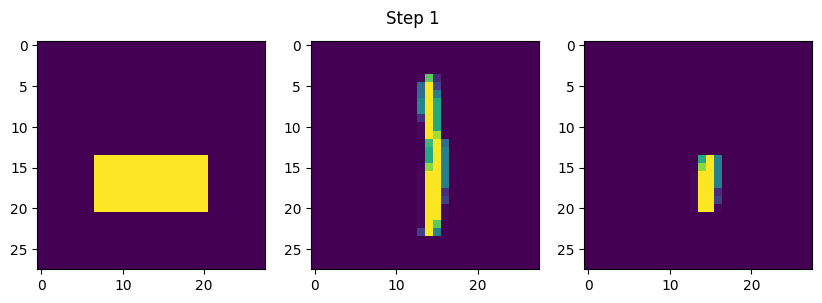

In [ ]:
# from mnist_env import MNISTEnv
# from actor_critic_agent import MNISTNet, ActorCriticNNAgent
import numpy as np
import time
import argparse
import sys

def main():
    batch_size = 32
    iters = 200
    verbose = True

    print("Training...")
    trained_agent = train(iters, batch_size, verbose=verbose)
    test_agent = trained_agent.copy()

    print("Testing...")
    test(test_agent)

    print("Evaluating...")
    for _ in range(5):
        eval(test_agent)

def train(iterations, episodes, verbose=False):


    def obs_to_input(obs):
        # reshape to (1, 28, 28)
        return obs[np.newaxis, ...]

    # initialize agent
    agent = ActorCriticNNAgent(MNISTNet, obs_to_input=obs_to_input, df=0.1)

    # intialize environment
    env = MNISTEnv(type='train', seed=None)

    # training loop
    start = time.time()
    for iter in range(iterations):

        if iter % 10 == 0: print("Starting iteration %d" % iter)
        rewards = []

        # play out each episode
        for ep in range(episodes):

            if verbose and iter % 10 == 0 and ep == 0:
                display = True
            else:
                display = False

            observation = env.reset()
            agent.new_episode()
            total_reward = 0

            done = False
            while not done:

                action = agent.act(observation, env, display=display)
                observation, reward, done, info = env.step(action)

                if display: print("Actual reward:", reward)
                agent.store_reward(reward)
                total_reward += reward

            rewards.append(total_reward)

            if display: env.render()

        # adjust agent parameters based on played episodes
        agent.update()

        # print performance for this iteration
        if iter % 10 == 0:
            print("Mean total reward / episode: %.3f" % np.mean(rewards))

    end = time.time()
    print("Completed %d iterations of %d episodes in %.3f s" % \
          (iterations, episodes, end - start))

    # return trained agent
    return agent


def eval(agent, n_test=1000):
    # evaluate a trained agent

    env = MNISTEnv(type='test', seed=None)

    observation = env.reset()

    done = False
    while not done:

        action = agent.act(observation, env, display=True)
        observation, reward, done, info = env.step(action)

        print("Received reward %.1f on step %d" % (reward, env.steps))
        env.render()


def test(agent, n_test=1000):
    # calculate test average reward

    env = MNISTEnv(type='test', seed=None)

    rewards = []
    for _ in range(n_test):

        observation = env.reset()
        total_reward = 0

        done = False
        while not done:

            action = agent.act(observation, env, display=False)
            observation, reward, done, info = env.step(action)

            total_reward += reward

        rewards.append(total_reward)

    print("Mean total reward / episode: %.3f" % np.mean(rewards))


if __name__ == '__main__':

    main()


Training...
Starting iteration 0


<ipython-input-5-594717d2e78c>:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(array).float()



Sampled action: (1, 3)
Value estimate: 0.026900908
Distributions:
[0.2291068  0.2645098  0.24564022 0.2607432 ]
[0.10020623 0.09941653 0.10489702 0.09321803 0.0878545  0.11251345
 0.09751768 0.10591172 0.09630982 0.10215501]
Actual reward: -0.1

Sampled action: (0, 6)
Value estimate: 0.027011264
Distributions:
[0.22916691 0.26443428 0.2456546  0.2607443 ]
[0.10022799 0.09937555 0.10490209 0.09324192 0.08787452 0.11250556
 0.09754196 0.10588009 0.09631824 0.10213219]
Actual reward: -0.1

Sampled action: (1, 3)
Value estimate: 0.027011264
Distributions:
[0.22916691 0.26443428 0.2456546  0.2607443 ]
[0.10022799 0.09937555 0.10490209 0.09324192 0.08787452 0.11250556
 0.09754196 0.10588009 0.09631824 0.10213219]
Actual reward: -0.1

Sampled action: (1, 2)
Value estimate: 0.027011264
Distributions:
[0.22916691 0.26443428 0.2456546  0.2607443 ]
[0.10022799 0.09937555 0.10490209 0.09324192 0.08787452 0.11250556
 0.09754196 0.10588009 0.09631824 0.10213219]
Actual reward: -0.1

Sampled action:

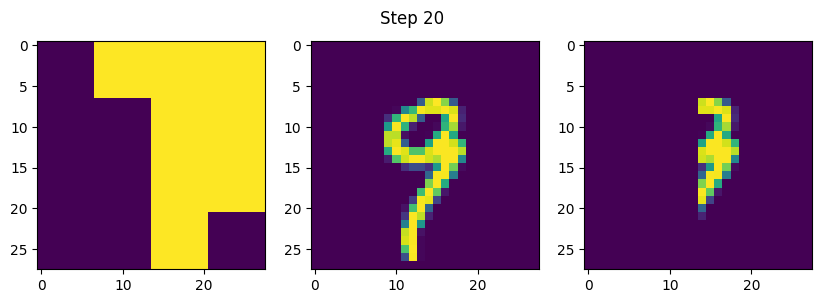

Mean total reward / episode: 0.047
Starting iteration 10

Sampled action: (3, 6)
Value estimate: 0.027453551
Distributions:
[0.21539475 0.26331243 0.27026117 0.2510316 ]
[0.1013689  0.10295448 0.10448956 0.09723784 0.08049522 0.10381065
 0.08909498 0.11365546 0.10286207 0.10403077]
Actual reward: -0.1

Sampled action: (1, 7)
Value estimate: 0.016651714
Distributions:
[0.21306638 0.26774377 0.26652926 0.25266066]
[0.10178199 0.1053207  0.10642661 0.09570745 0.07827963 0.10424051
 0.08571171 0.11427188 0.10278474 0.10547483]
Actual reward: -0.1

Sampled action: (3, 9)
Value estimate: 0.01776594
Distributions:
[0.21260649 0.26636416 0.27095696 0.25007236]
[0.10283861 0.10605224 0.10525253 0.09622216 0.07789971 0.10366808
 0.0844181  0.11436927 0.10360303 0.10567626]
Actual reward: -0.1

Sampled action: (0, 7)
Value estimate: 0.01776594
Distributions:
[0.21260649 0.26636416 0.27095696 0.25007236]
[0.10283861 0.10605224 0.10525253 0.09622216 0.07789971 0.10366808
 0.0844181  0.11436927 0.10

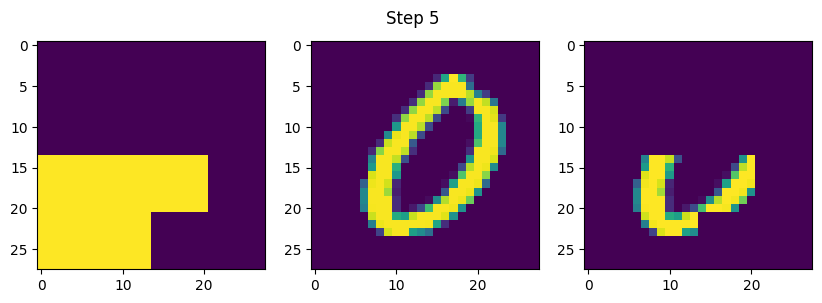

Mean total reward / episode: -0.122
Starting iteration 20

Sampled action: (1, 6)
Value estimate: -0.029575616
Distributions:
[0.22154193 0.2554969  0.28786987 0.23509128]
[0.10984182 0.09981157 0.10624044 0.09347905 0.08755647 0.09402027
 0.09455805 0.11598401 0.10249943 0.09600887]
Actual reward: 0.9


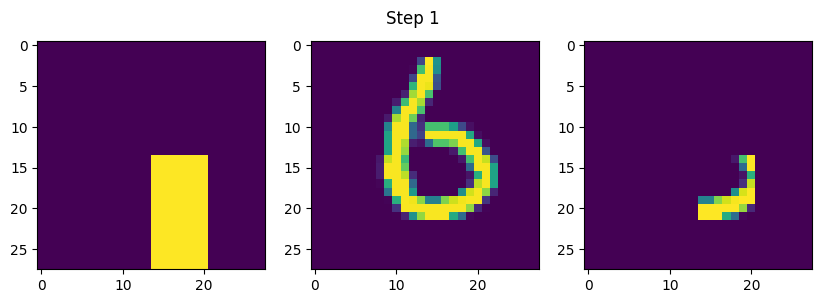

Mean total reward / episode: -0.038
Starting iteration 30

Sampled action: (3, 7)
Value estimate: -0.018983508
Distributions:
[0.20008719 0.23712888 0.31780598 0.24497798]
[0.11621934 0.08267339 0.11107644 0.08690096 0.09750998 0.08902162
 0.11262503 0.11184381 0.09907866 0.09305076]
Actual reward: -0.1

Sampled action: (1, 6)
Value estimate: -0.0213253
Distributions:
[0.19522946 0.23867536 0.30057746 0.26551783]
[0.10575782 0.0850437  0.11588087 0.08009896 0.10125679 0.089272
 0.11699626 0.11010336 0.10315749 0.09243286]
Actual reward: 0.9


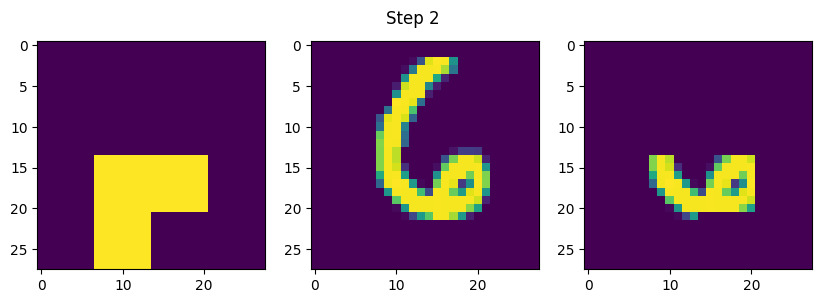

Mean total reward / episode: -0.066
Starting iteration 40

Sampled action: (3, 7)
Value estimate: -0.10450606
Distributions:
[0.14970197 0.21253541 0.4154301  0.22233249]
[0.11273062 0.06917953 0.12197777 0.09248777 0.10515465 0.06914883
 0.14875996 0.10162851 0.10035218 0.07858018]
Actual reward: -0.1

Sampled action: (0, 1)
Value estimate: -0.05046306
Distributions:
[0.14091596 0.22414672 0.39858425 0.23635311]
[0.12227532 0.06843559 0.13200478 0.07544965 0.1133721  0.06931911
 0.15163673 0.08844746 0.09930972 0.07974955]
Actual reward: -0.1

Sampled action: (1, 0)
Value estimate: -0.021735005
Distributions:
[0.13137203 0.24936189 0.36885747 0.25040868]
[0.09869774 0.07645793 0.10754642 0.07454551 0.11609908 0.07650416
 0.14413637 0.10152339 0.11550625 0.08898322]
Actual reward: -0.1

Sampled action: (2, 4)
Value estimate: -0.021735005
Distributions:
[0.13137203 0.24936189 0.36885747 0.25040868]
[0.09869774 0.07645793 0.10754642 0.07454551 0.11609908 0.07650416
 0.14413637 0.10152339

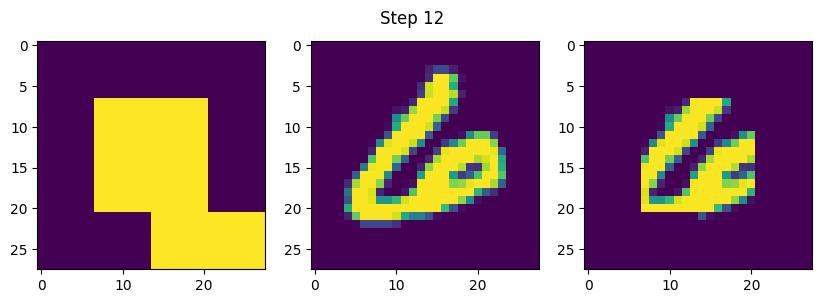

Mean total reward / episode: 0.428
Starting iteration 50

Sampled action: (0, 8)
Value estimate: -0.028766884
Distributions:
[0.22300689 0.23875031 0.26813805 0.27010462]
[0.06587058 0.13587369 0.10847645 0.07973155 0.08713523 0.10087887
 0.10214005 0.11416186 0.10902322 0.09670833]
Actual reward: -0.1

Sampled action: (2, 1)
Value estimate: -0.12766744
Distributions:
[0.23135644 0.23751554 0.24060428 0.29052365]
[0.03840354 0.16206284 0.12968457 0.08072999 0.07939939 0.07381485
 0.08089106 0.14670777 0.12474707 0.08355883]
Actual reward: 0.9


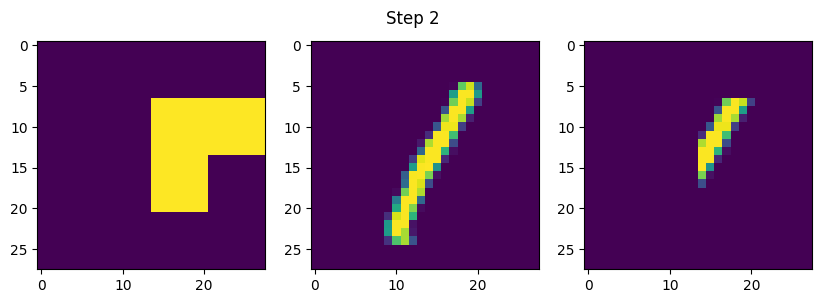

Mean total reward / episode: 0.297
Starting iteration 60

Sampled action: (0, 0)
Value estimate: -0.064641476
Distributions:
[0.12075358 0.22300589 0.49522707 0.16101351]
[0.3996984  0.01029398 0.07689285 0.136058   0.08447921 0.03534606
 0.10958895 0.06712131 0.02962372 0.05089765]
Actual reward: -0.1

Sampled action: (1, 2)
Value estimate: -0.162084
Distributions:
[0.14077549 0.25429487 0.45482838 0.1501012 ]
[0.30868208 0.01365984 0.09970293 0.18265939 0.09099197 0.02966645
 0.08333399 0.10269422 0.03830395 0.05030512]
Actual reward: -0.1

Sampled action: (0, 3)
Value estimate: -0.162084
Distributions:
[0.14077549 0.25429487 0.45482838 0.1501012 ]
[0.30868208 0.01365984 0.09970293 0.18265939 0.09099197 0.02966645
 0.08333399 0.10269422 0.03830395 0.05030512]
Actual reward: -0.1

Sampled action: (0, 0)
Value estimate: -0.162084
Distributions:
[0.14077549 0.25429487 0.45482838 0.1501012 ]
[0.30868208 0.01365984 0.09970293 0.18265939 0.09099197 0.02966645
 0.08333399 0.10269422 0.03830

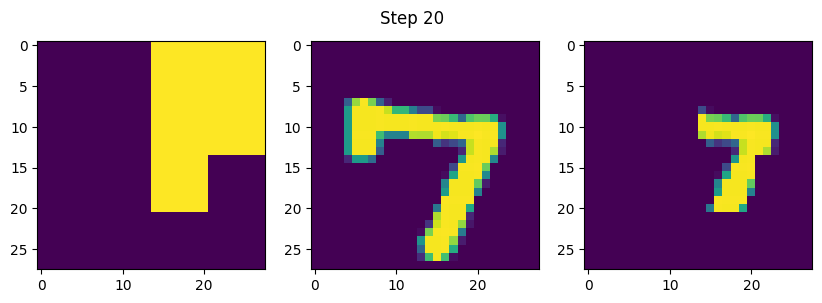

Mean total reward / episode: 0.153
Starting iteration 70

Sampled action: (1, 1)
Value estimate: -0.042340256
Distributions:
[0.21111289 0.25581583 0.2387965  0.29427478]
[0.0237989  0.18129376 0.11541598 0.07055567 0.08558534 0.06687156
 0.08161943 0.13475949 0.13339458 0.10670531]
Actual reward: -0.1

Sampled action: (3, 4)
Value estimate: -0.054147646
Distributions:
[0.18248728 0.26171836 0.27506626 0.2807281 ]
[0.02969726 0.15543732 0.10573017 0.08974782 0.08278829 0.06959698
 0.08002204 0.1356155  0.13017097 0.12119368]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: -0.033355422
Distributions:
[0.19531716 0.26163277 0.26500008 0.27805004]
[0.02461186 0.18851042 0.10988835 0.08766133 0.066424   0.0686304
 0.07231113 0.12811345 0.15255818 0.10129093]
Actual reward: 0.9


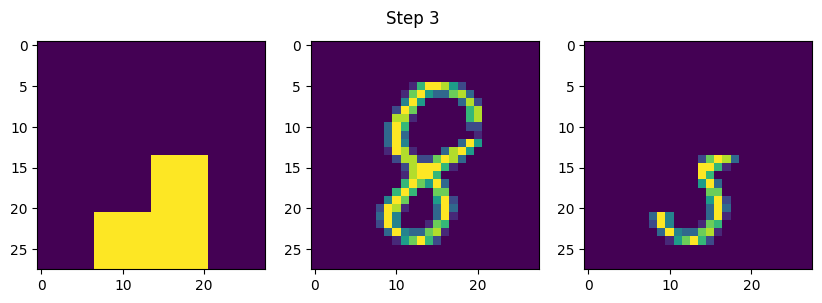

Mean total reward / episode: 0.131
Starting iteration 80

Sampled action: (1, 2)
Value estimate: 0.09689411
Distributions:
[0.11781383 0.16446158 0.49345577 0.22426882]
[0.41414446 0.00462619 0.05923638 0.19908252 0.04624811 0.05077837
 0.13033679 0.03091662 0.01754665 0.04708391]
Actual reward: -0.1

Sampled action: (0, 0)
Value estimate: 0.10726792
Distributions:
[0.11014111 0.16267595 0.5076505  0.21953231]
[0.41747242 0.00453219 0.05704987 0.20502687 0.04450016 0.04881671
 0.12384449 0.03230675 0.01728069 0.04916974]
Actual reward: 0.9


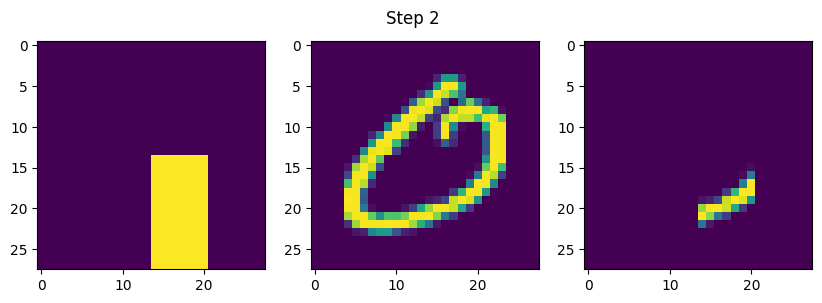

Mean total reward / episode: 0.247
Starting iteration 90

Sampled action: (1, 9)
Value estimate: -0.049317688
Distributions:
[0.07113732 0.21325761 0.14147879 0.5741263 ]
[0.01868799 0.00767306 0.07172228 0.11864975 0.14555597 0.04294932
 0.16693833 0.14629838 0.07991038 0.20161459]
Actual reward: -0.1

Sampled action: (0, 9)
Value estimate: -0.047197953
Distributions:
[0.06120324 0.22041304 0.14743021 0.5709535 ]
[0.02069199 0.00608192 0.05463375 0.14474842 0.13058269 0.04612333
 0.14694187 0.14866897 0.07584058 0.22568649]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: -0.047197953
Distributions:
[0.06120324 0.22041304 0.14743021 0.5709535 ]
[0.02069199 0.00608192 0.05463375 0.14474842 0.13058269 0.04612333
 0.14694187 0.14866897 0.07584058 0.22568649]
Actual reward: -0.1

Sampled action: (1, 2)
Value estimate: -0.14257699
Distributions:
[0.04669674 0.15907846 0.089486   0.70473874]
[0.00814909 0.00187437 0.28236762 0.05232663 0.06282975 0.03370237
 0.38021654 0.01036312

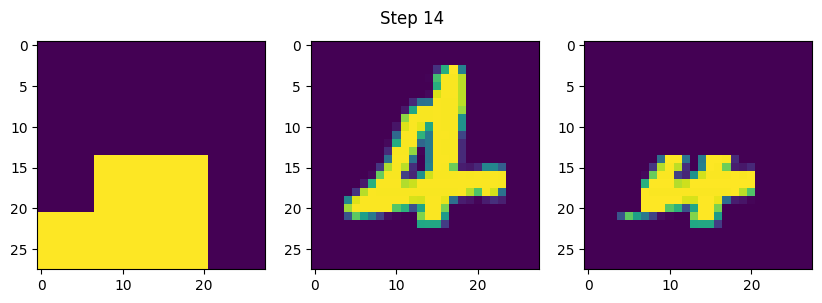

Mean total reward / episode: 0.181
Starting iteration 100

Sampled action: (3, 7)
Value estimate: 0.02299306
Distributions:
[0.04526172 0.15482742 0.04649665 0.7534143 ]
[0.00096488 0.02929117 0.02463569 0.00913442 0.24228115 0.01175206
 0.03574717 0.38963082 0.0759262  0.18063648]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: -0.041217916
Distributions:
[0.02795624 0.09067874 0.02640213 0.85496294]
[0.00033056 0.01888345 0.13052979 0.00494768 0.26012382 0.02122888
 0.16456755 0.03141791 0.28405765 0.08391274]
Actual reward: 0.9


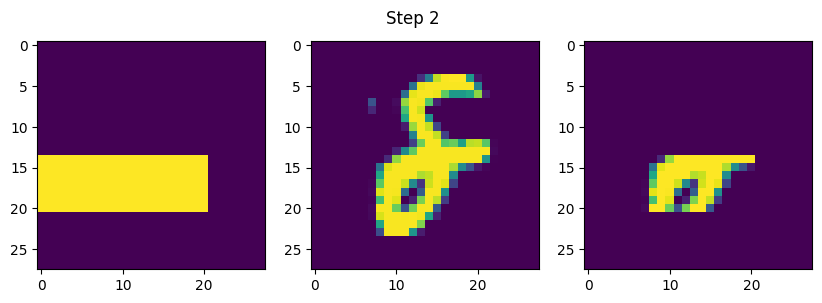

Mean total reward / episode: 0.128
Starting iteration 110

Sampled action: (2, 0)
Value estimate: 0.106919326
Distributions:
[0.01437582 0.04932579 0.54643416 0.38986412]
[8.6860693e-01 4.9882124e-07 8.2813983e-04 9.9739477e-02 1.9045873e-03
 8.3275223e-03 1.7927745e-02 9.0712123e-04 1.5288945e-04 1.6050275e-03]
Actual reward: -0.1

Sampled action: (2, 0)
Value estimate: 0.106919326
Distributions:
[0.01437582 0.04932579 0.54643416 0.38986412]
[8.6860693e-01 4.9882124e-07 8.2813983e-04 9.9739477e-02 1.9045873e-03
 8.3275223e-03 1.7927745e-02 9.0712123e-04 1.5288945e-04 1.6050275e-03]
Actual reward: -0.1

Sampled action: (3, 0)
Value estimate: 0.106919326
Distributions:
[0.01437582 0.04932579 0.54643416 0.38986412]
[8.6860693e-01 4.9882124e-07 8.2813983e-04 9.9739477e-02 1.9045873e-03
 8.3275223e-03 1.7927745e-02 9.0712123e-04 1.5288945e-04 1.6050275e-03]
Actual reward: -0.1

Sampled action: (3, 0)
Value estimate: 0.106919326
Distributions:
[0.01437582 0.04932579 0.54643416 0.38986412]
[

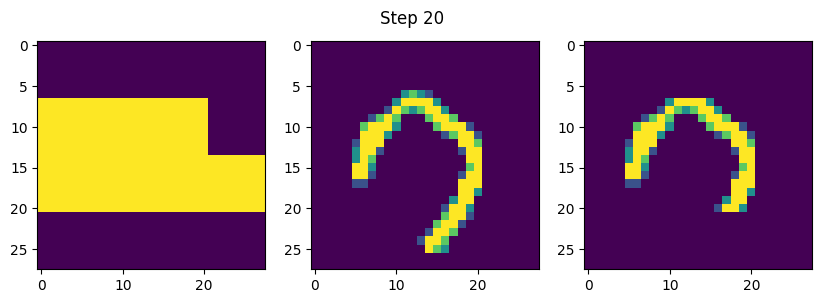

Mean total reward / episode: 0.281
Starting iteration 120

Sampled action: (3, 2)
Value estimate: 0.18646172
Distributions:
[0.08679394 0.07807617 0.15811116 0.6770187 ]
[0.00750563 0.02854822 0.22498178 0.12478856 0.10246211 0.08615528
 0.1564215  0.05917349 0.14434451 0.06561886]
Actual reward: -0.1

Sampled action: (3, 4)
Value estimate: 0.24093668
Distributions:
[0.03626514 0.03694516 0.05830596 0.86848366]
[0.00106704 0.01224372 0.2269336  0.0267067  0.22360107 0.07039633
 0.16456741 0.02466906 0.16796358 0.08185144]
Actual reward: -0.1

Sampled action: (1, 4)
Value estimate: 0.24093668
Distributions:
[0.03626514 0.03694516 0.05830596 0.86848366]
[0.00106704 0.01224372 0.2269336  0.0267067  0.22360107 0.07039633
 0.16456741 0.02466906 0.16796358 0.08185144]
Actual reward: -0.1

Sampled action: (3, 2)
Value estimate: 0.24093668
Distributions:
[0.03626514 0.03694516 0.05830596 0.86848366]
[0.00106704 0.01224372 0.2269336  0.0267067  0.22360107 0.07039633
 0.16456741 0.02466906 0.167

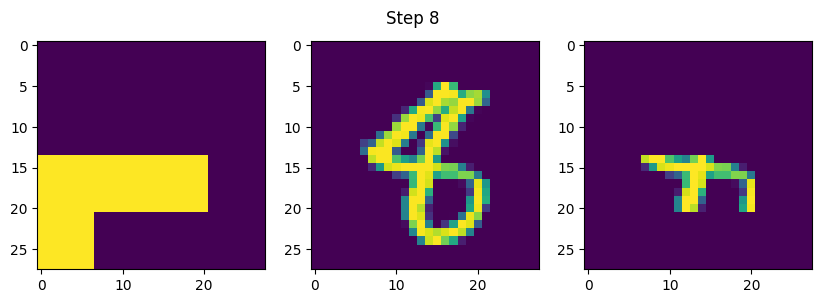

Mean total reward / episode: 0.494
Starting iteration 130

Sampled action: (3, 4)
Value estimate: 0.2040324
Distributions:
[0.05892119 0.05854855 0.12003041 0.76249975]
[0.00250272 0.06335768 0.04479029 0.07851039 0.15435442 0.09778687
 0.0763215  0.12918459 0.17624661 0.17694485]
Actual reward: -0.1

Sampled action: (3, 4)
Value estimate: 0.17649657
Distributions:
[0.05621139 0.05659401 0.11883927 0.7683553 ]
[0.00179966 0.04856683 0.03897372 0.08283306 0.13431957 0.13579449
 0.09270896 0.06042961 0.24282384 0.16175023]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: 0.17649657
Distributions:
[0.05621139 0.05659401 0.11883927 0.7683553 ]
[0.00179966 0.04856683 0.03897372 0.08283306 0.13431957 0.13579449
 0.09270896 0.06042961 0.24282384 0.16175023]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: 0.17649657
Distributions:
[0.05621139 0.05659401 0.11883927 0.7683553 ]
[0.00179966 0.04856683 0.03897372 0.08283306 0.13431957 0.13579449
 0.09270896 0.06042961 0.2428

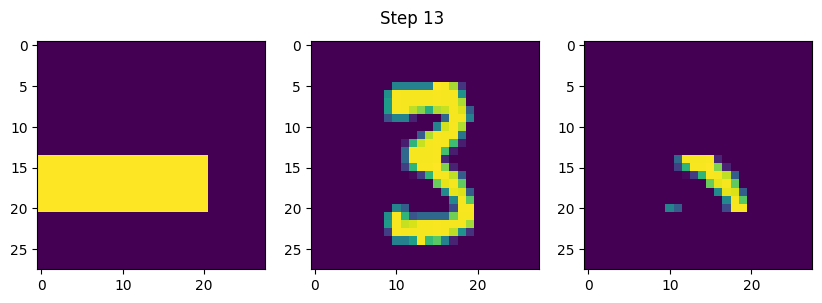

Mean total reward / episode: 0.225
Starting iteration 140

Sampled action: (3, 9)
Value estimate: 0.1572775
Distributions:
[0.04713519 0.04537798 0.05708347 0.8504033 ]
[1.1532368e-04 9.6131325e-02 2.2458078e-02 8.4618106e-03 1.0362027e-01
 9.8536592e-03 8.0424268e-03 5.0881428e-01 9.6033148e-02 1.4646968e-01]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: 0.21331033
Distributions:
[0.01601399 0.01252255 0.02520432 0.94625914]
[1.8541505e-05 1.6128177e-02 1.2717788e-01 5.3368863e-03 4.7856301e-02
 1.5571840e-02 3.2652531e-02 5.0498422e-02 6.4949006e-01 5.5269349e-02]
Actual reward: 0.9


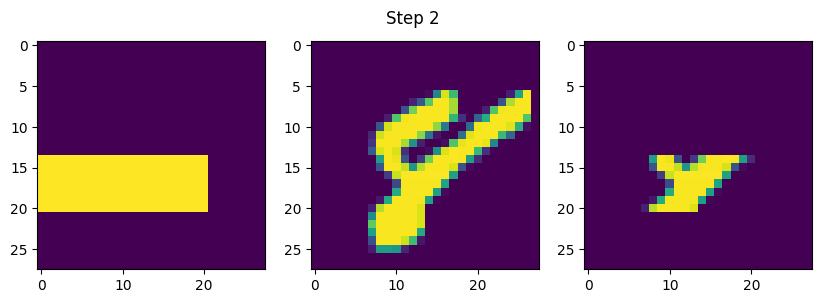

Mean total reward / episode: 0.603
Starting iteration 150

Sampled action: (2, 0)
Value estimate: 0.38123575
Distributions:
[0.04437852 0.02500731 0.5614874  0.36912674]
[6.6130888e-01 2.6941645e-05 2.7630631e-02 1.6046146e-01 1.7343253e-03
 6.6246092e-02 7.6881714e-02 1.2004331e-03 2.2477040e-03 2.2616955e-03]
Actual reward: 0.9


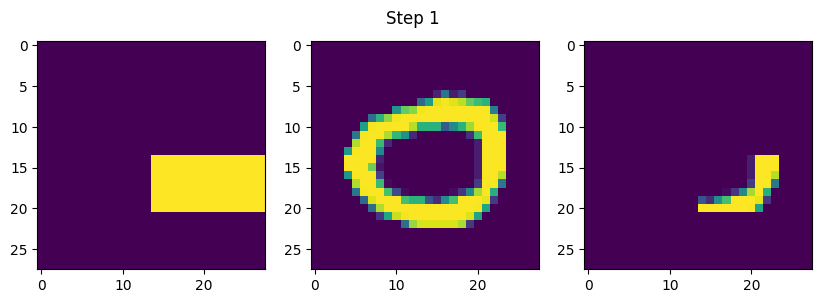

Mean total reward / episode: 0.472
Starting iteration 160

Sampled action: (3, 1)
Value estimate: 0.36013114
Distributions:
[0.11374278 0.06426209 0.06156597 0.76042926]
[9.4404795e-06 7.8123438e-01 1.1928538e-02 2.9820404e-03 8.6456854e-03
 4.3693446e-03 3.7862312e-03 3.3958443e-02 1.2784702e-01 2.5238978e-02]
Actual reward: 0.9


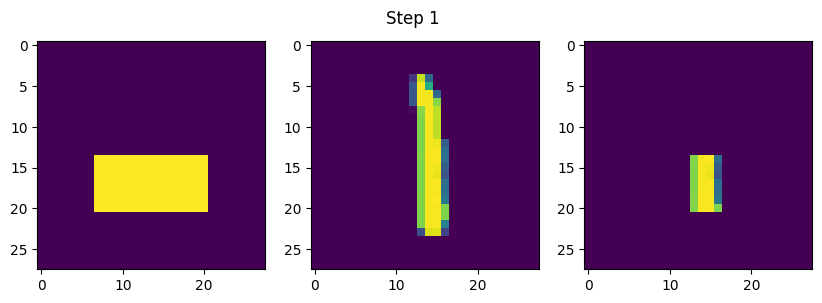

Mean total reward / episode: 0.681
Starting iteration 170

Sampled action: (0, 9)
Value estimate: 0.13753447
Distributions:
[0.23635207 0.20630021 0.30748212 0.2498656 ]
[0.03563708 0.43693525 0.03946094 0.04637506 0.04889434 0.07941494
 0.03497256 0.11162393 0.06759864 0.09908728]
Actual reward: -0.1

Sampled action: (3, 5)
Value estimate: 0.091459036
Distributions:
[0.21625307 0.2531209  0.21747074 0.3131553 ]
[0.02722285 0.19338836 0.04912681 0.09517838 0.00400118 0.48834038
 0.00898831 0.02252678 0.0840316  0.02719538]
Actual reward: 0.9


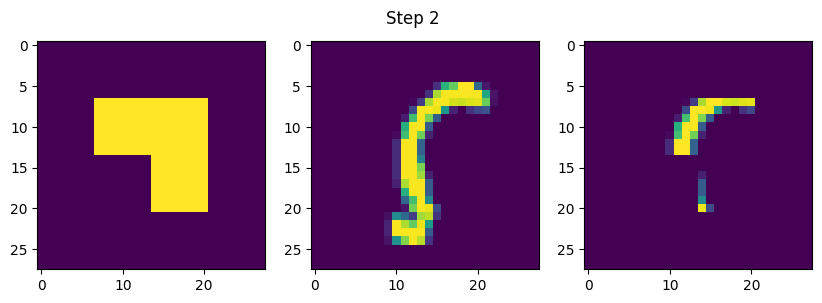

Mean total reward / episode: 0.428
Starting iteration 180

Sampled action: (3, 7)
Value estimate: 0.19589895
Distributions:
[0.00810886 0.01766713 0.02558907 0.94863504]
[3.1509364e-03 1.5441224e-04 3.3091516e-03 5.7717529e-03 1.3098939e-01
 1.8663029e-03 1.4575644e-02 7.5725502e-01 2.1284970e-03 8.0799036e-02]
Actual reward: 0.9


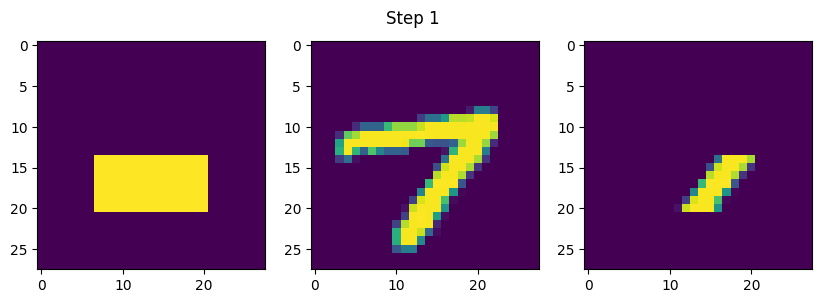

Mean total reward / episode: 0.634
Starting iteration 190

Sampled action: (3, 3)
Value estimate: 0.17915498
Distributions:
[0.0295328  0.02924204 0.04615142 0.8950738 ]
[0.00049956 0.01006613 0.14715171 0.16997647 0.09047215 0.06621453
 0.06922518 0.05028003 0.28667605 0.10943815]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: 0.07790265
Distributions:
[0.00396905 0.01056608 0.00891648 0.9765484 ]
[7.9670890e-06 4.8957052e-05 1.7738444e-01 2.4459191e-02 2.4046153e-03
 3.4823701e-02 3.4876313e-02 2.3573727e-04 7.2148514e-01 4.2739343e-03]
Actual reward: 0.9


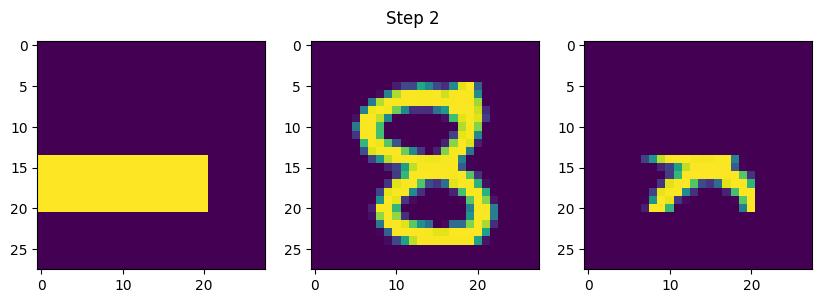

Mean total reward / episode: 0.634
Completed 200 iterations of 32 episodes in 70.472 s
Testing...
Mean total reward / episode: 0.488
Evaluating...

Sampled action: (3, 8)
Value estimate: 0.18169889
Distributions:
[0.06293822 0.03260212 0.06665323 0.8378064 ]
[0.00065589 0.03082227 0.3755125  0.11032598 0.07097711 0.03938036
 0.05568583 0.06988285 0.19219843 0.05455875]
Received reward 0.9 on step 1


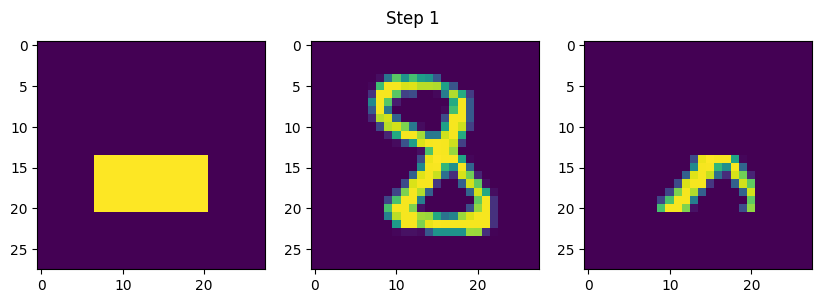


Sampled action: (3, 7)
Value estimate: 0.05062621
Distributions:
[0.01182076 0.01674962 0.0515443  0.9198854 ]
[7.3264502e-03 4.7926276e-04 1.4977540e-02 2.9121643e-02 9.7791046e-02
 1.3239351e-02 2.2083038e-02 7.1918702e-01 6.0133575e-03 8.9781344e-02]
Received reward -0.1 on step 1


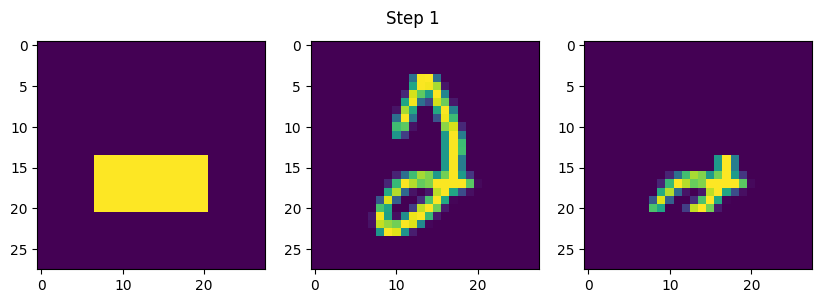


Sampled action: (3, 2)
Value estimate: 0.053686433
Distributions:
[0.00419859 0.01007841 0.01844264 0.9672804 ]
[7.0740348e-03 8.5463646e-05 4.4675097e-01 4.7505148e-02 4.7626980e-02
 2.4685122e-02 2.5152838e-01 9.2610113e-02 5.5118680e-02 2.7015103e-02]
Received reward 0.9 on step 2


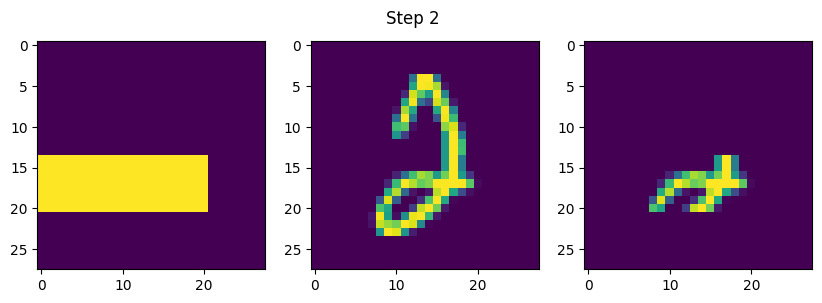


Sampled action: (2, 3)
Value estimate: 0.19717658
Distributions:
[0.13262706 0.092685   0.5142307  0.26045722]
[0.4058984  0.00567675 0.08385658 0.20731488 0.00799089 0.18894058
 0.05800225 0.01364469 0.01956976 0.00910522]
Received reward -0.1 on step 1


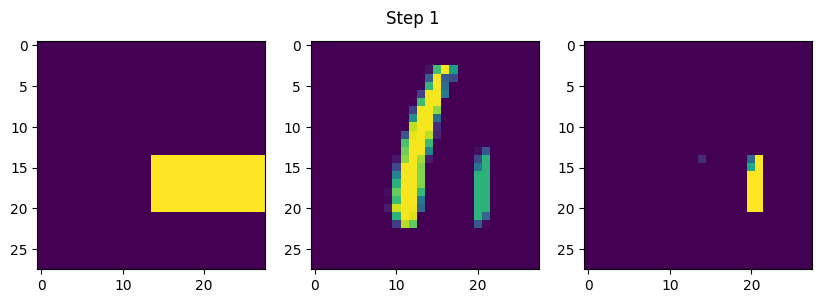


Sampled action: (2, 2)
Value estimate: 0.18378235
Distributions:
[0.07628293 0.04931293 0.61092514 0.26347905]
[6.6617739e-01 1.2840427e-04 4.9176671e-02 1.4742449e-01 1.1758413e-03
 8.7852925e-02 4.2559884e-02 1.6551212e-03 3.0348029e-03 8.1452727e-04]
Received reward -0.1 on step 2


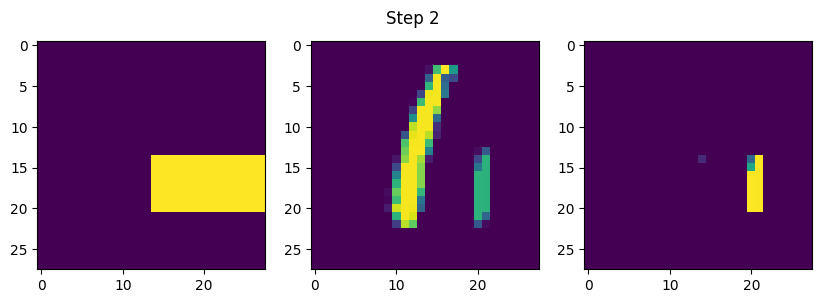


Sampled action: (2, 3)
Value estimate: 0.18378235
Distributions:
[0.07628293 0.04931293 0.61092514 0.26347905]
[6.6617739e-01 1.2840427e-04 4.9176671e-02 1.4742449e-01 1.1758413e-03
 8.7852925e-02 4.2559884e-02 1.6551212e-03 3.0348029e-03 8.1452727e-04]
Received reward -0.1 on step 3


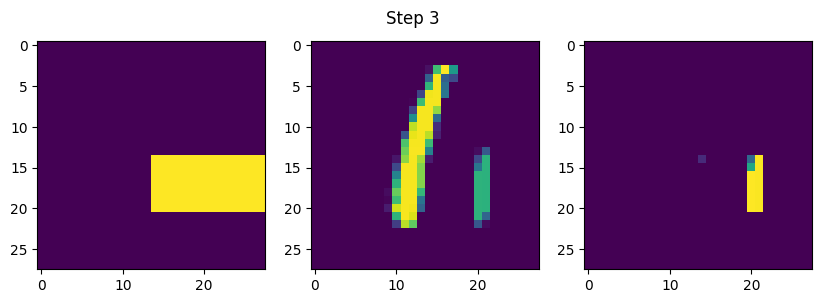


Sampled action: (2, 0)
Value estimate: 0.18378235
Distributions:
[0.07628293 0.04931293 0.61092514 0.26347905]
[6.6617739e-01 1.2840427e-04 4.9176671e-02 1.4742449e-01 1.1758413e-03
 8.7852925e-02 4.2559884e-02 1.6551212e-03 3.0348029e-03 8.1452727e-04]
Received reward -0.1 on step 4


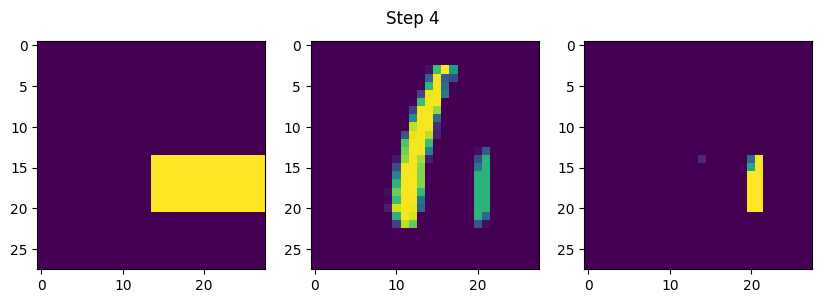


Sampled action: (3, 5)
Value estimate: 0.18378235
Distributions:
[0.07628293 0.04931293 0.61092514 0.26347905]
[6.6617739e-01 1.2840427e-04 4.9176671e-02 1.4742449e-01 1.1758413e-03
 8.7852925e-02 4.2559884e-02 1.6551212e-03 3.0348029e-03 8.1452727e-04]
Received reward -0.1 on step 5


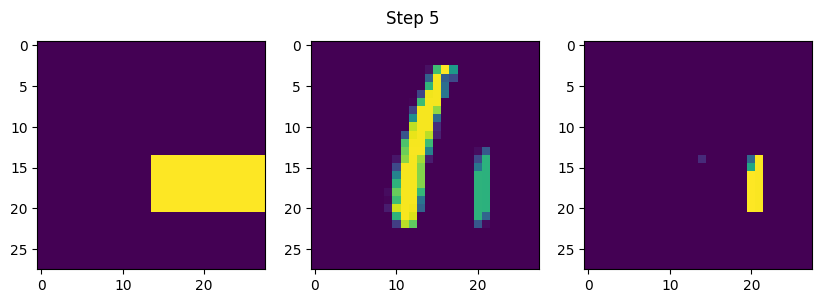


Sampled action: (2, 0)
Value estimate: 0.18378235
Distributions:
[0.07628293 0.04931293 0.61092514 0.26347905]
[6.6617739e-01 1.2840427e-04 4.9176671e-02 1.4742449e-01 1.1758413e-03
 8.7852925e-02 4.2559884e-02 1.6551212e-03 3.0348029e-03 8.1452727e-04]
Received reward -0.1 on step 6


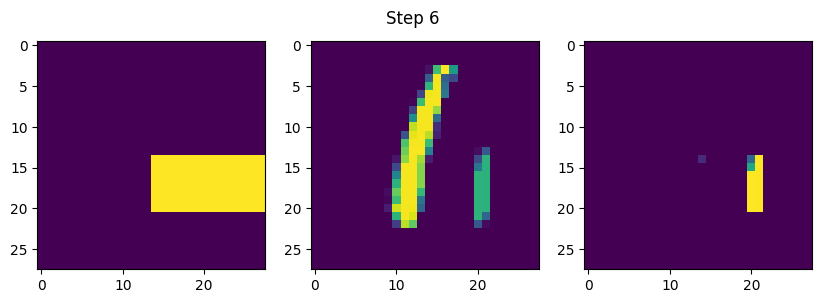


Sampled action: (2, 0)
Value estimate: 0.18378235
Distributions:
[0.07628293 0.04931293 0.61092514 0.26347905]
[6.6617739e-01 1.2840427e-04 4.9176671e-02 1.4742449e-01 1.1758413e-03
 8.7852925e-02 4.2559884e-02 1.6551212e-03 3.0348029e-03 8.1452727e-04]
Received reward -0.1 on step 7


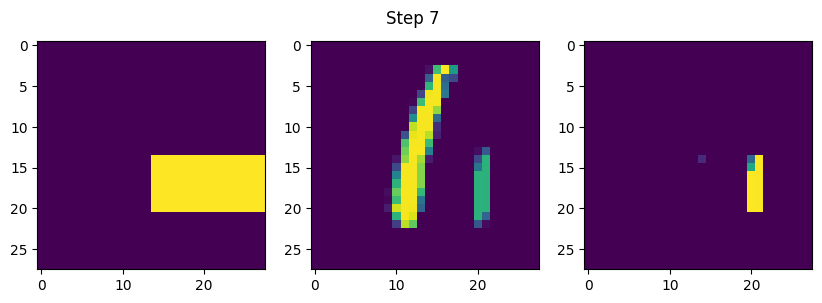


Sampled action: (3, 0)
Value estimate: 0.18378235
Distributions:
[0.07628293 0.04931293 0.61092514 0.26347905]
[6.6617739e-01 1.2840427e-04 4.9176671e-02 1.4742449e-01 1.1758413e-03
 8.7852925e-02 4.2559884e-02 1.6551212e-03 3.0348029e-03 8.1452727e-04]
Received reward -0.1 on step 8


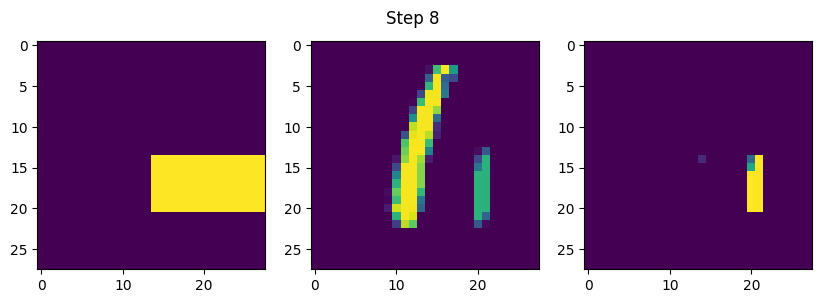


Sampled action: (3, 0)
Value estimate: 0.18378235
Distributions:
[0.07628293 0.04931293 0.61092514 0.26347905]
[6.6617739e-01 1.2840427e-04 4.9176671e-02 1.4742449e-01 1.1758413e-03
 8.7852925e-02 4.2559884e-02 1.6551212e-03 3.0348029e-03 8.1452727e-04]
Received reward -0.1 on step 9


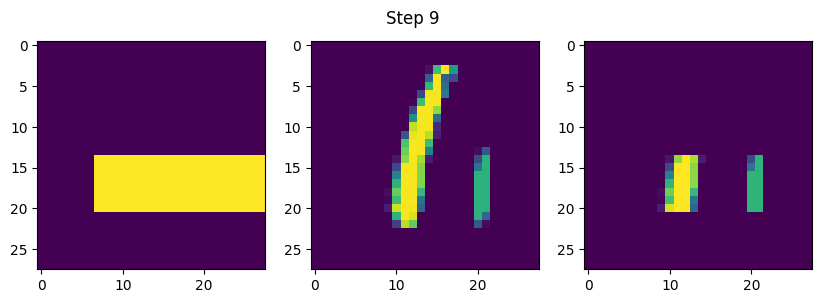


Sampled action: (2, 6)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 10


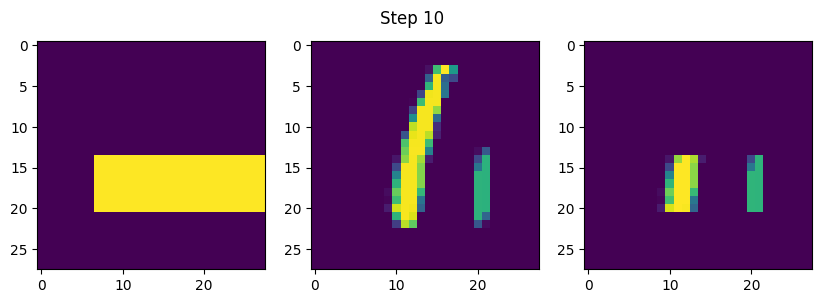


Sampled action: (2, 3)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 11


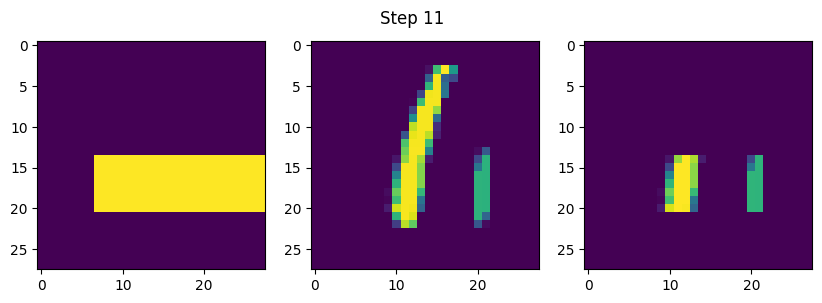


Sampled action: (3, 2)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 12


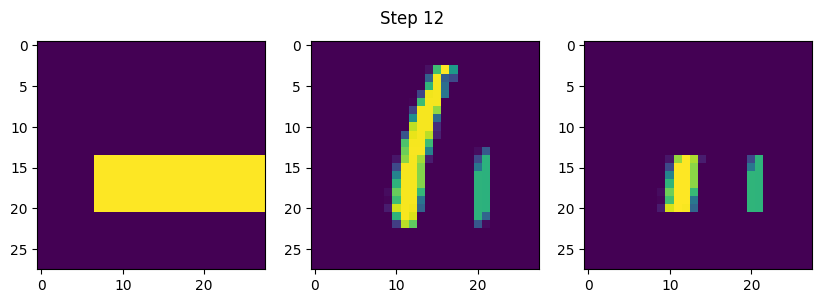


Sampled action: (3, 2)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 13


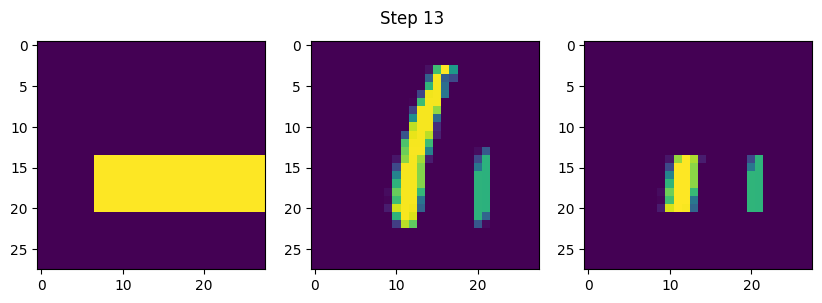


Sampled action: (3, 2)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 14


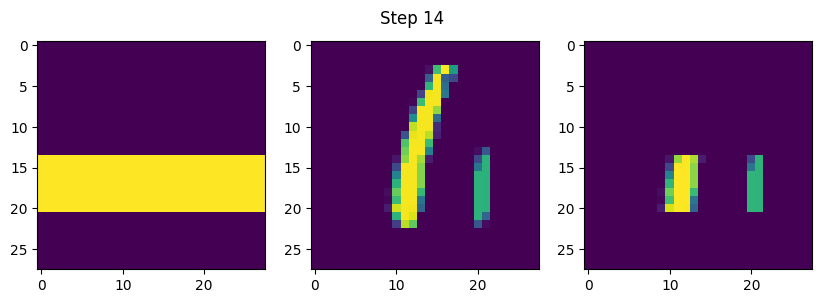


Sampled action: (3, 2)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 15


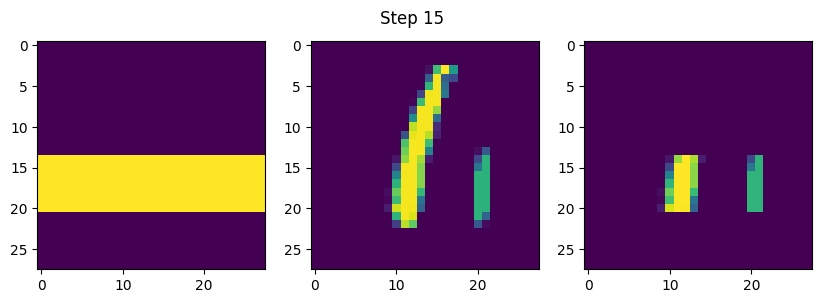


Sampled action: (3, 2)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 16


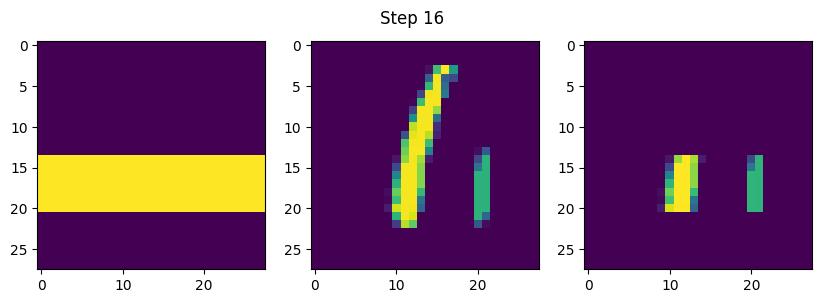


Sampled action: (3, 6)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 17


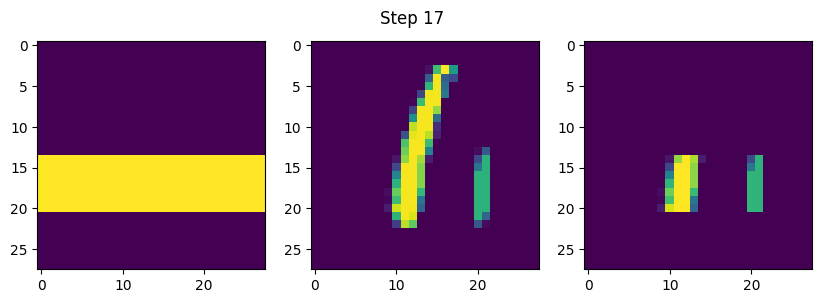


Sampled action: (3, 8)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 18


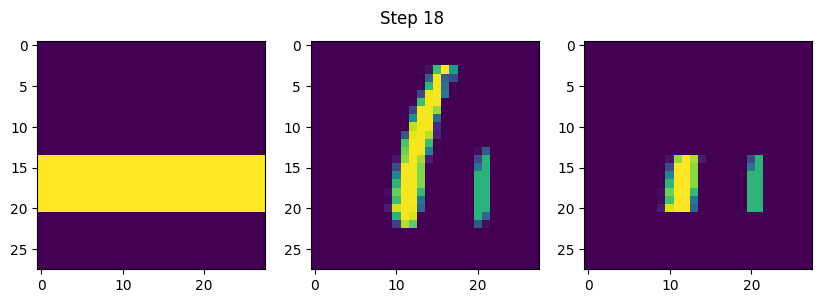


Sampled action: (3, 2)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 19


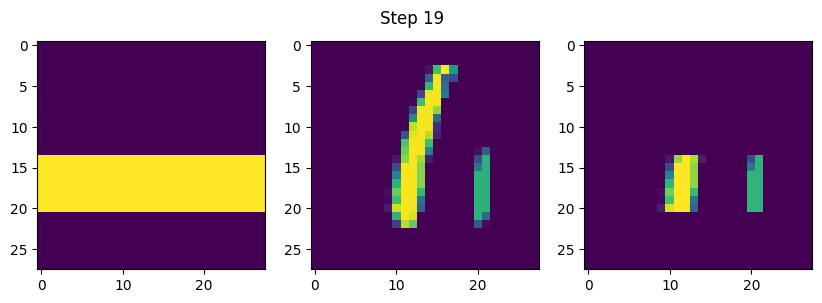


Sampled action: (3, 2)
Value estimate: 0.17622049
Distributions:
[0.03002472 0.01813331 0.07861817 0.87322384]
[3.7023221e-04 4.7892859e-04 5.3683549e-01 1.0035682e-02 1.3401540e-04
 1.5720453e-02 2.3104711e-01 4.3900465e-05 2.0523903e-01 9.5190975e-05]
Received reward -0.1 on step 20


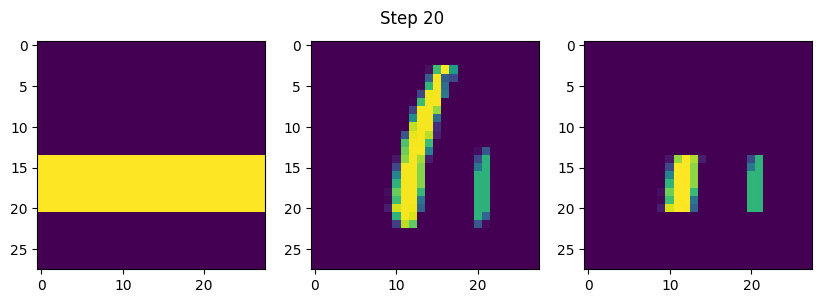


Sampled action: (3, 7)
Value estimate: 0.11959077
Distributions:
[0.03232578 0.02645047 0.02670565 0.9145181 ]
[4.1207652e-05 3.8160626e-02 1.1004736e-02 3.4995240e-03 1.5820245e-01
 2.0573169e-03 4.4458606e-03 5.9935176e-01 2.1993676e-02 1.6124286e-01]
Received reward -0.1 on step 1


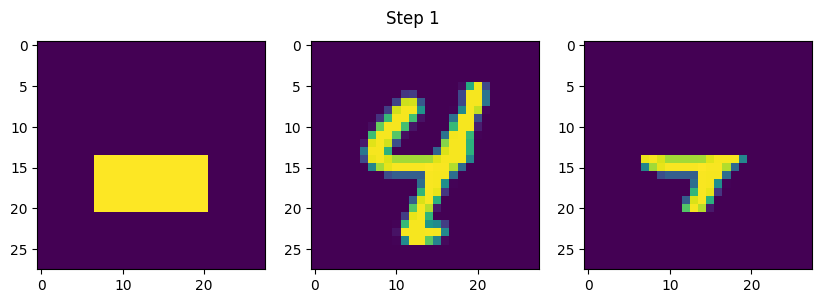


Sampled action: (3, 9)
Value estimate: 0.16653053
Distributions:
[0.00513314 0.0084448  0.00547016 0.9809518 ]
[2.8633538e-05 2.3279383e-04 1.4398610e-03 3.6866806e-04 5.9105766e-01
 2.2126622e-03 2.9828213e-03 4.8787493e-02 3.3733444e-03 3.4951603e-01]
Received reward -0.1 on step 2


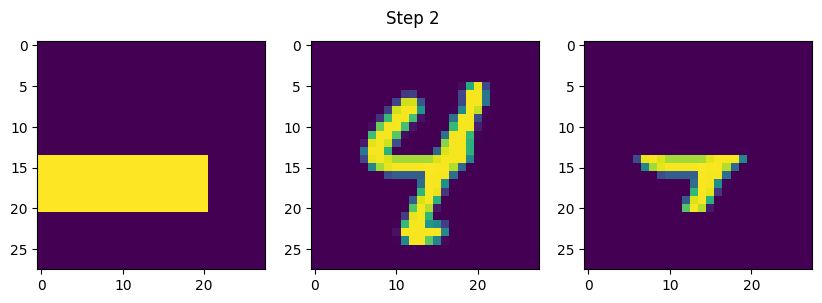


Sampled action: (3, 9)
Value estimate: 0.16341493
Distributions:
[0.00510699 0.00840004 0.00531278 0.98118013]
[2.6616794e-05 2.2269248e-04 1.3282361e-03 3.3857569e-04 5.9175748e-01
 2.0475716e-03 2.6770302e-03 4.9938422e-02 3.0829227e-03 3.4858042e-01]
Received reward -0.1 on step 3


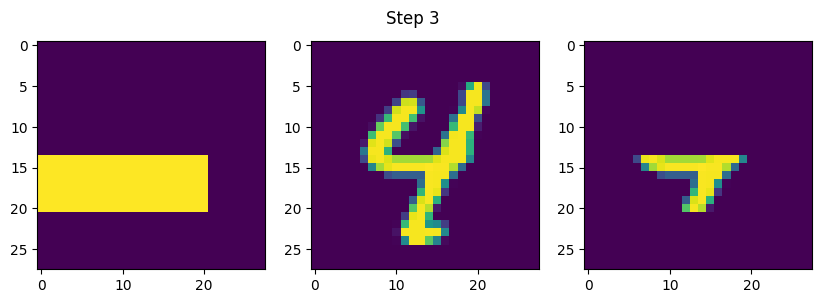


Sampled action: (1, 4)
Value estimate: 0.16341493
Distributions:
[0.00510699 0.00840004 0.00531278 0.98118013]
[2.6616794e-05 2.2269248e-04 1.3282361e-03 3.3857569e-04 5.9175748e-01
 2.0475716e-03 2.6770302e-03 4.9938422e-02 3.0829227e-03 3.4858042e-01]
Received reward 0.9 on step 4


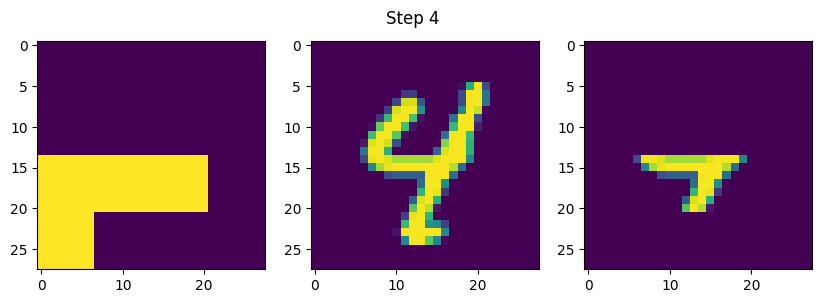


Sampled action: (3, 4)
Value estimate: 0.042292908
Distributions:
[0.00604455 0.00927821 0.02214099 0.9625362 ]
[2.1569179e-03 4.2584245e-04 6.2530138e-02 4.5251191e-02 1.4592795e-01
 1.3439832e-02 6.5046251e-02 5.4881883e-01 2.2229197e-02 9.4173804e-02]
Received reward -0.1 on step 1


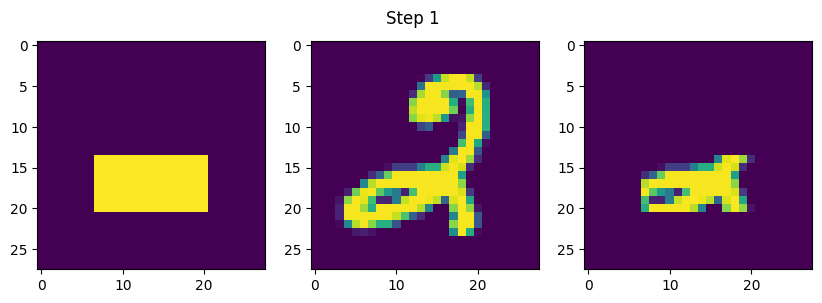


Sampled action: (3, 2)
Value estimate: 0.11444038
Distributions:
[7.746595e-04 3.559538e-03 4.009993e-03 9.916559e-01]
[2.9759237e-04 2.5915816e-07 9.0340960e-01 2.8743609e-03 1.8894344e-03
 2.5873764e-03 7.8502335e-02 6.2984513e-04 9.2350692e-03 5.7418534e-04]
Received reward 0.9 on step 2


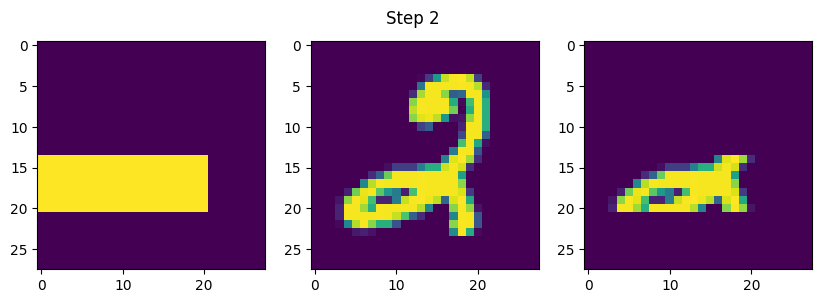

In [ ]:
# from mnist_env import MNISTEnv
# from actor_critic_agent import MNISTNet, ActorCriticNNAgent
import numpy as np
import time
import argparse
import sys

def main():
    batch_size = 32
    iters = 200
    verbose = True

    print("Training...")
    trained_agent = train(iters, batch_size, verbose=verbose)
    test_agent = trained_agent.copy()

    print("Testing...")
    test(test_agent)

    print("Evaluating...")
    for _ in range(5):
        eval(test_agent)

def train(iterations, episodes, verbose=False):
    def obs_to_input(obs):
        # reshape to (1, 28, 28)
        return obs[np.newaxis, ...]

    # initialize agent
    agent = ActorCriticNNAgent(MNISTNet, obs_to_input=obs_to_input, df=0.1)

    # intialize environment
    env = MNISTEnv(type='train', seed=None)

    # training loop
    start = time.time()
    for iter in range(iterations):

        if iter % 10 == 0: print("Starting iteration %d" % iter)
        rewards = []

        # play out each episode
        for ep in range(episodes):

            if verbose and iter % 10 == 0 and ep == 0:
                display = True
            else:
                display = False

            observation = env.reset()
            agent.new_episode()
            total_reward = 0

            done = False
            while not done:

                action = agent.act(observation, env, display=display)
                observation, reward, done, info = env.step(action)

                if display: print("Actual reward:", reward)
                agent.store_reward(reward)
                total_reward += reward

            rewards.append(total_reward)

            if display: env.render()

        # adjust agent parameters based on played episodes
        agent.update()

        # print performance for this iteration
        if iter % 10 == 0:
            print("Mean total reward / episode: %.3f" % np.mean(rewards))

    end = time.time()
    print("Completed %d iterations of %d episodes in %.3f s" % \
          (iterations, episodes, end - start))

    # return trained agent
    return agent


def eval(agent, n_test=1000):
    # evaluate a trained agent

    env = MNISTEnv(type='test', seed=None)

    observation = env.reset()

    done = False
    while not done:

        action = agent.act(observation, env, display=True)
        observation, reward, done, info = env.step(action)

        print("Received reward %.1f on step %d" % (reward, env.steps))
        env.render()


def test(agent, n_test=1000):
    # calculate test average reward

    env = MNISTEnv(type='test', seed=None)

    rewards = []
    for _ in range(n_test):

        observation = env.reset()
        total_reward = 0

        done = False
        while not done:

            action = agent.act(observation, env, display=False)
            observation, reward, done, info = env.step(action)

            total_reward += reward

        rewards.append(total_reward)

    print("Mean total reward / episode: %.3f" % np.mean(rewards))


if __name__ == '__main__':

    main()


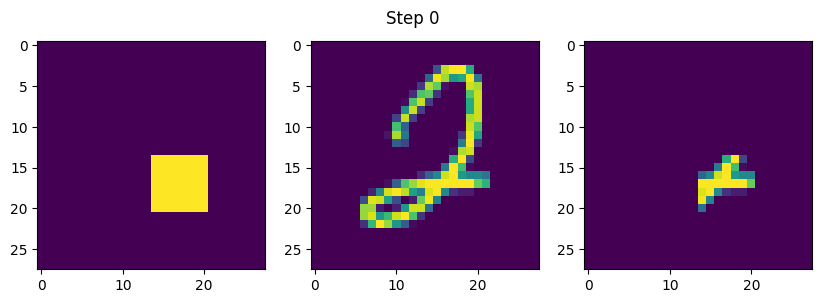

Agent moved West
Agent guessed 4
Received reward -0.1 on step 1


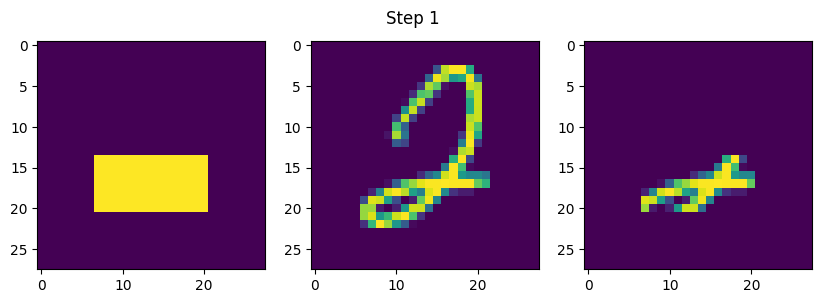

Agent moved South
Agent guessed 5
Received reward -0.1 on step 2


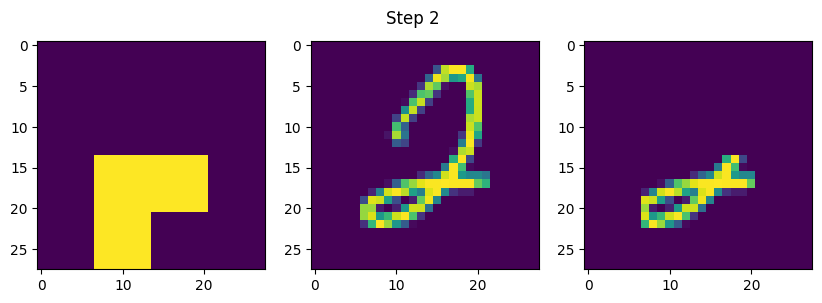

Agent moved North
Agent guessed 2
Received reward 0.9 on step 3


In [ ]:
import numpy as np

# Run this file to test if the environment is working

env = MNISTEnv(type='train', seed=None)

obs = env.reset()
done = False

while not done:

    env.render()
    action = env.action_space.sample()
    dir, Y_pred = action % 4, action // 4
    print("Agent moved %s" % (['North', 'South', 'East', 'West'][dir]))
    print("Agent guessed %d" % Y_pred)

    _, reward, done, _ = env.step(action)
    print("Received reward %.1f on step %d" % (reward, env.steps))

## Cifar10

In [ ]:
from keras.datasets import cifar10

# Load the CIFAR-10 dataset
(_, _), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 classes
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Print details of CIFAR-10 dataset
print("CIFAR-10 dataset details:")
print("Number of images in the test set:", len(x_test))
print("Shape of each image:", x_test[0].shape)
print("Number of classes:", len(cifar10_classes))
print("CIFAR-10 classes:")
for i, class_name in enumerate(cifar10_classes):
    print(f"Class {i}: {class_name}")


CIFAR-10 dataset details:
Number of images in the test set: 10000
Shape of each image: (32, 32, 3)
Number of classes: 10
CIFAR-10 classes:
Class 0: airplane
Class 1: automobile
Class 2: bird
Class 3: cat
Class 4: deer
Class 5: dog
Class 6: frog
Class 7: horse
Class 8: ship
Class 9: truck


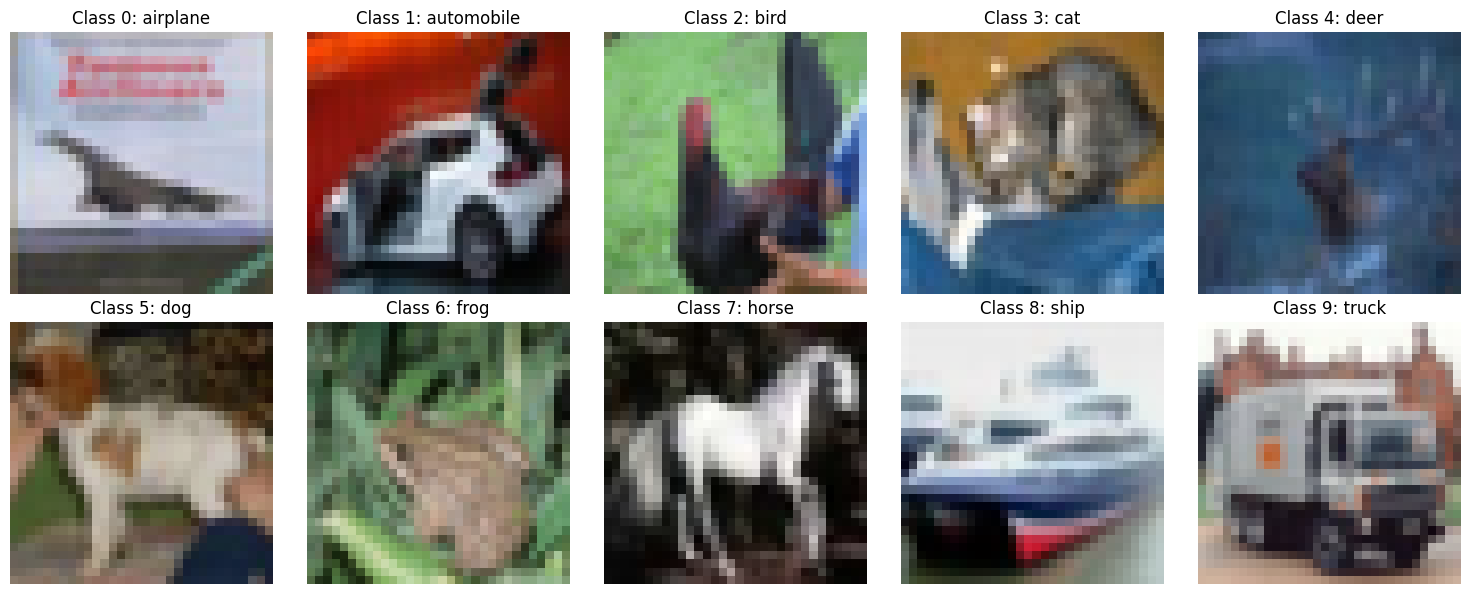

In [ ]:
import matplotlib.pyplot as plt
from keras.datasets import cifar10

# Load the CIFAR-10 dataset
(_, _), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 classes
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Create a dictionary to store one image for each class
one_image_per_class = {}

# Find one image for each class
for class_idx, class_name in enumerate(cifar10_classes):
    for i in range(len(y_test)):
        if y_test[i][0] == class_idx:
            one_image_per_class[class_name] = x_test[i]
            break

# Plot one image per class along with its label
plt.figure(figsize=(15, 6))
for i, (class_name, image) in enumerate(one_image_per_class.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Class {i}: {class_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt

MAX_STEPS = 20
WINDOW_SIZE = 7
RANDOM_LOC = False

class CIFAR10Env(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, type='train', seed=2069):
        if seed:
            np.random.seed(seed=seed)

        (x_train, y_train), (x_test, y_test) = cifar10.load_data()

        if type == 'train':
            self.X = x_train
            self.Y = y_train
            self.n = len(y_train)
        elif type == 'test':
            self.X = x_test
            self.Y = y_test
            self.n = len(y_test)

        h, w, c = self.X[0].shape
        self.h = h // WINDOW_SIZE
        self.w = w // WINDOW_SIZE

        self.mask = np.zeros((h, w))

        # action is an integer in {0, ..., 39}
        # see 'step' for interpretation
        self.action_space = spaces.Discrete(40)
        self.observation_space = spaces.Box(0, 255, [h, w, c])

    def step(self, action):
        assert(self.action_space.contains(action))
        dir, Y_pred = action % 4, action // 4

        self.steps += 1

        move_map = {
            0: [-1, 0], # N
            1: [1, 0],  # S
            2: [0, 1],  # E
            3: [0, -1]  # W
        }

        self.pos = np.clip(self.pos + move_map[dir], 0, [self.h-1, self.w-1])
        self._reveal()

        obs = self._get_obs()

        reward = -0.1 + int(Y_pred == self.Y[self.i])

        done = Y_pred == self.Y[self.i] or self.steps >= MAX_STEPS

        info = {}

        return obs, reward, done, info

    def reset(self):
        if RANDOM_LOC:
            self.pos = np.array([np.random.randint(self.h), np.random.randint(self.w)])
        else:
            self.pos = np.array([int(self.h / 2), int(self.w / 2)])

        self.mask[:, :] = 0
        self._reveal()
        self.i = np.random.randint(self.n)
        self.steps = 0

        return self._get_obs()

    def _get_obs(self):
        obs = self.X[self.i] * np.expand_dims(self.mask, axis=-1)
        obs = np.clip(obs, 0, 255)
        obs = obs.astype(np.float32) / 255.0
        assert self.observation_space.contains(obs)
        return obs


    def _reveal(self):
        # Reveal the window at self.pos
        h, w = self.pos
        h_low, h_high = h * WINDOW_SIZE, (h + 1) * WINDOW_SIZE
        w_low, w_high = w * WINDOW_SIZE, (w + 1) * WINDOW_SIZE

        # Update the mask to reveal the window
        self.mask[h_low:h_high, w_low:w_high] = 1



    def render(self, mode='human', close=False):
        # Display mask, full image, and masked image
        plt.figure(figsize=(10, 3))
        plt.suptitle("Step %d" % self.steps)

        plt.subplot(131)
        plt.imshow(255 * self.mask)
        plt.subplot(132)
        plt.imshow(self.X[self.i])
        plt.subplot(133)

        # Expand dimensions of the mask to match the number of channels in the image
        expanded_mask = np.expand_dims(self.mask, axis=-1)

        # Apply the expanded mask to the image
        masked_image = self.X[self.i] * expanded_mask

        plt.imshow(masked_image)

        plt.show()


In [ ]:
class CIFAR10Net(nn.Module):
    '''
    A CNN with ReLU activations and a three-headed output, two for the
    actor and one for the critic

    y1 - action distribution
    y2 - critic's estimate of value

    Input shape:    (batch_size, 3, 32, 32)
    Output shape:   (batch_size, 40), (batch_size, 1)
    '''

    def __init__(self):

        super(CIFAR10Net, self).__init__()

        same_padding = (3 - 1) // 2

        self.conv1 = nn.Conv2d(3, 10, 3, padding=same_padding)
        self.conv2 = nn.Conv2d(10, 10, 3, padding=same_padding)
        self.lin1  = nn.Linear(10 * 8 * 8, 50)  # Adjusted input size

        self.out_dir = nn.Linear(50, 4)
        self.out_class = nn.Linear(50, 10)
        self.out_critic = nn.Linear(50, 1)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = nn.MaxPool2d(2)(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = nn.MaxPool2d(2)(x)

        x = x.view(-1, 10 * 8 * 8)  # Adjusted input size
        x = self.lin1(x)

        pi1 = self.out_class(x)
        pi1 = F.softmax(pi1, dim=-1)

        pi2 = self.out_dir(x)
        pi2 = F.softmax(pi2, dim=-1)

        y1 = torch.bmm(pi1.unsqueeze(2), pi2.unsqueeze(1))
        y1 = y1.view(-1, 40)

        y2 = self.out_critic(x)

        return y1, y2



def cifar10_obs_to_input(observation):
    # Convert observation to PyTorch tensor and normalize
    return observation.transpose(2, 0, 1) / 255.0


class ActorCriticNNAgent:
    '''
    Neural-net agent that trains using the actor-critic algorithm. The critic
    is a value function that returns expected discounted reward given the
    state as input. We use advantage defined as

        A = r + g * V(s') - V(s)

    Notation:
        A - advantage
        V - value function
        r - current reward
        g - discount factor
        s - current state
        s' - next state
    '''

    def __init__(self, new_network, params=None, obs_to_input=None,
                 lr=1e-3, df=0.5, alpha=0.5):

        if obs_to_input is None:
            obs_to_input = lambda x: x

        # model and parameters
        if params is not None:
            self.model = new_network(params)
        else:
            self.model = new_network()
        if isinstance(self.model, torch.nn.Module):
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.df = df  # discount factor
        self.alpha = alpha  # multiply critic updates by this factor

        # initialize replay history
        self.replay = []

        # function that converts observation into input of dimension D_in
        self.obs_to_input = obs_to_input

        # if trainable is changed to false, the model won't be updated
        self.trainable = True

    def act(self, o, env=None, display=False):

        # feed observation as input to net to get distribution as output
        x = self.obs_to_input(o)
        x = numpy_to_torch([x])
        y1, y2 = self.model(x)

        pi = torch_to_numpy(y1).flatten()
        v  = torch_to_numpy(y2).squeeze()

        # sample action from distribution
        a = np.random.choice(np.arange(40), p=pi)

        if display:
            direction, digit = a % 4, a // 4
            pi1 = pi.reshape((10, 4)).sum(axis=0)
            pi2 = pi.reshape((10, 4)).sum(axis=1)

            print("")
            print("Sampled action:", (direction, digit))
            print("Value estimate:", v)
            print("Distributions:", pi1, pi2, sep='\n')

        # update current episode in replay with observation and chosen action
        if self.trainable:
            self.replay[-1]['observations'].append(o)
            self.replay[-1]['actions'].append(a)

        return np.array(a)

    def new_episode(self):
        # start a new episode in replay
        self.replay.append({'observations': [], 'actions': [], 'rewards': []})

    def store_reward(self, r):
        # insert 0s for actions that received no reward; end with reward r
        episode = self.replay[-1]
        T_no_reward = len(episode['actions']) - len(episode['rewards']) - 1
        episode['rewards'] += [0.0] * T_no_reward + [r]

    def _calculate_discounted_rewards(self):
        # calculate and store discounted rewards per episode

        for episode in self.replay:

            R = episode['rewards']
            R_disc = []
            R_sum = 0
            for r in R[::-1]:
                R_sum = r + self.df * R_sum
                R_disc.insert(0, R_sum)

            episode['rewards_disc'] = R_disc

    def update(self):

        assert(self.trainable)

        episode_losses = torch.tensor(0.0)
        N = len(self.replay)
        self._calculate_discounted_rewards()

        for episode in self.replay:

            O = episode['observations']
            A = episode['actions']
            R = numpy_to_torch(episode['rewards'])
            R_disc = numpy_to_torch(episode['rewards_disc'])
            T = len(R_disc)

            # forward pass, Y1 is pi(a | s), Y2 is V(s)
            X = numpy_to_torch([self.obs_to_input(o) for o in O])
            Y1, Y2 = self.model(X)
            pi = Y1
            Vs_curr = Y2.view(-1)

            # log probabilities of selected actions
            log_prob = torch.log(pi[np.arange(T), A])

            # advantage of selected actions over expected reward given state
            Vs_next = torch.cat((Vs_curr[1:], torch.tensor([0.])))
            adv = R + self.df * Vs_next - Vs_curr

            # ignore gradients so the critic isn't affected by actor loss
            adv = adv.detach()

            # actor loss is -1 * advantage-weighted sum of log likelihood
            # critic loss is the SE between values and discounted rewards
            actor_loss = -torch.dot(log_prob, adv)
            critic_loss = torch.sum((R_disc - Vs_curr) ** 2)
            episode_losses += actor_loss + critic_loss * self.alpha

        # backward pass
        self.optimizer.zero_grad()
        loss = episode_losses / N
        loss.backward()
        self.optimizer.step()

        # reset the replay history
        self.replay = []

    def copy(self):

        # create a copy of this agent with frozen weights
        agent = ActorCriticNNAgent(lambda x: 0, 0, self.obs_to_input)
        agent.model = copy.deepcopy(self.model)
        agent.trainable = False
        for param in agent.model.parameters():
            param.requires_grad = False

        return agent

Training...


<ipython-input-38-5a1db3df72ec>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = -0.1 + int(Y_pred == self.Y[self.i])


Starting iteration 0

Sampled action: (3, 8)
Value estimate: 0.017192163
Distributions:
[0.24338563 0.2644815  0.22680539 0.26532748]
[0.10108685 0.09271374 0.10296268 0.10512937 0.09304102 0.10198233
 0.10600463 0.1025679  0.09952926 0.09498227]
Actual reward: -0.1

Sampled action: (2, 8)
Value estimate: 0.017193727
Distributions:
[0.2433843  0.26448065 0.22680607 0.2653289 ]
[0.10108747 0.09271364 0.10296249 0.10512839 0.0930406  0.10198195
 0.10600498 0.10256879 0.09952916 0.09498247]
Actual reward: -0.1

Sampled action: (3, 4)
Value estimate: 0.017193727
Distributions:
[0.2433843  0.26448065 0.22680607 0.2653289 ]
[0.10108747 0.09271364 0.10296249 0.10512839 0.0930406  0.10198195
 0.10600498 0.10256879 0.09952916 0.09498247]
Actual reward: -0.1

Sampled action: (2, 0)
Value estimate: 0.017193727
Distributions:
[0.2433843  0.26448065 0.22680607 0.2653289 ]
[0.10108747 0.09271364 0.10296249 0.10512839 0.0930406  0.10198195
 0.10600498 0.10256879 0.09952916 0.09498247]
Actual reward: 

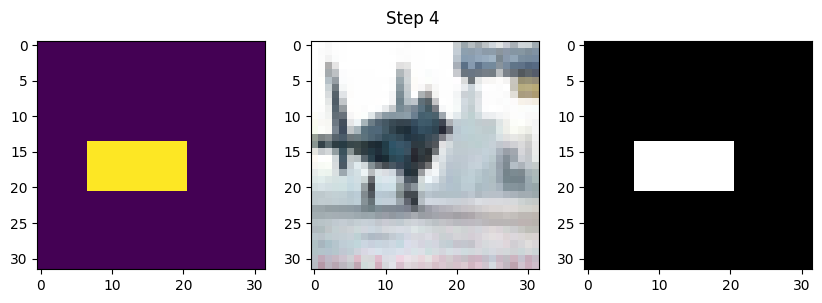

Mean total reward / episode: -0.081


Starting iteration 10

Sampled action: (3, 2)
Value estimate: 0.0020097466
Distributions:
[0.23473322 0.26743925 0.2314305  0.26639706]
[0.10636896 0.09653258 0.10119867 0.10113852 0.09271383 0.10239461
 0.10325347 0.10185102 0.10153362 0.09301478]
Actual reward: -0.1

Sampled action: (2, 1)
Value estimate: 0.0020120684
Distributions:
[0.2347337  0.2674384  0.23143114 0.26639667]
[0.10636789 0.09653229 0.10119854 0.10113797 0.09271488 0.10239582
 0.10325331 0.10185076 0.1015337  0.09301479]
Actual reward: -0.1

Sampled action: (0, 0)
Value estimate: 0.0020120684
Distributions:
[0.2347337  0.2674384  0.23143114 0.26639667]
[0.10636789 0.09653229 0.10119854 0.10113797 0.09271488 0.10239582
 0.10325331 0.10185076 0.1015337  0.09301479]
Actual reward: -0.1

Sampled action: (2, 0)
Value estimate: 0.00201644
Distributions:
[0.23473008 0.26744175 0.23143251 0.26639563]
[0.10636905 0.09653266 0.1011985  0.10113689 0.09271494 0.10239494
 0.10325404 0.10185044 0.10153411 0.09301437]
Actual rewar

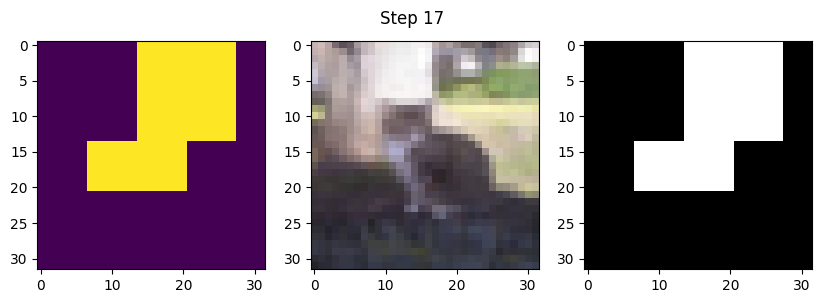

Mean total reward / episode: 0.050


Starting iteration 20

Sampled action: (3, 2)
Value estimate: 0.015403644
Distributions:
[0.23858874 0.26662362 0.22891411 0.2658736 ]
[0.10444351 0.09598499 0.10096717 0.102088   0.09259189 0.10338584
 0.10478361 0.10164784 0.10031091 0.0937963 ]
Actual reward: -0.1

Sampled action: (3, 3)
Value estimate: 0.015403787
Distributions:
[0.2385893  0.26662374 0.22891368 0.26587328]
[0.10444294 0.09598457 0.10096741 0.10208786 0.09259213 0.1033863
 0.10478351 0.10164817 0.10031092 0.09379621]
Actual reward: -0.1

Sampled action: (0, 2)
Value estimate: 0.015403792
Distributions:
[0.23859015 0.26662305 0.22891492 0.26587188]
[0.10444219 0.09598417 0.10096677 0.1020878  0.09259297 0.10338724
 0.10478381 0.10164793 0.10031089 0.09379623]
Actual reward: -0.1

Sampled action: (0, 2)
Value estimate: 0.015413555
Distributions:
[0.23858972 0.26662463 0.22891404 0.2658717 ]
[0.10444204 0.09598412 0.10096778 0.10208815 0.09259231 0.10338711
 0.10478334 0.10164791 0.10031066 0.09379663]
Actual reward: 

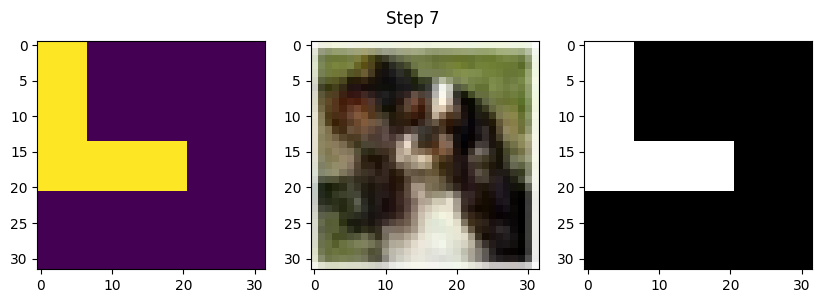

Mean total reward / episode: 0.034


Starting iteration 30

Sampled action: (0, 2)
Value estimate: -0.0053261933
Distributions:
[0.24044418 0.265495   0.22868095 0.2653798 ]
[0.10371307 0.09610742 0.10198431 0.10237498 0.09259241 0.10334373
 0.10464886 0.10190125 0.09971713 0.09361678]
Actual reward: -0.1

Sampled action: (3, 4)
Value estimate: -0.0053261933
Distributions:
[0.24044418 0.265495   0.22868095 0.2653798 ]
[0.10371307 0.09610742 0.10198431 0.10237498 0.09259241 0.10334373
 0.10464886 0.10190125 0.09971713 0.09361678]
Actual reward: -0.1

Sampled action: (0, 9)
Value estimate: -0.0053261933
Distributions:
[0.24044418 0.265495   0.22868095 0.2653798 ]
[0.10371307 0.09610742 0.10198431 0.10237498 0.09259241 0.10334373
 0.10464886 0.10190125 0.09971713 0.09361678]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: -0.0053261933
Distributions:
[0.24044418 0.265495   0.22868095 0.2653798 ]
[0.10371307 0.09610742 0.10198431 0.10237498 0.09259241 0.10334373
 0.10464886 0.10190125 0.09971713 0.09361678]
Actual

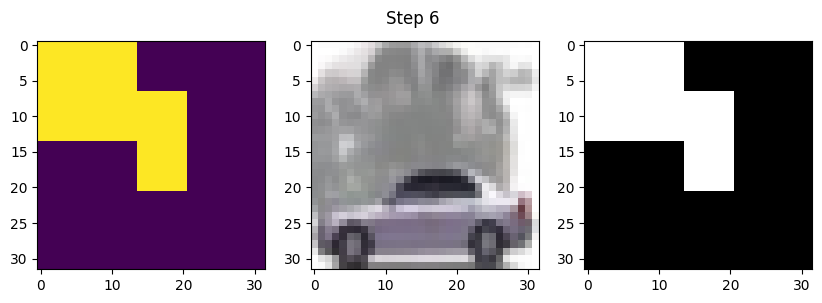

Mean total reward / episode: -0.134


Starting iteration 40

Sampled action: (3, 1)
Value estimate: -0.01315931
Distributions:
[0.24181277 0.2644331  0.22989026 0.26386386]
[0.10333367 0.09669524 0.10128298 0.10179526 0.09375833 0.10307068
 0.10497999 0.10209059 0.09888017 0.09411306]
Actual reward: -0.1

Sampled action: (0, 2)
Value estimate: -0.01315931
Distributions:
[0.24181277 0.2644331  0.22989026 0.26386386]
[0.10333367 0.09669524 0.10128298 0.10179526 0.09375833 0.10307068
 0.10497999 0.10209059 0.09888017 0.09411306]
Actual reward: -0.1

Sampled action: (3, 0)
Value estimate: -0.01315931
Distributions:
[0.24181277 0.2644331  0.22989026 0.26386386]
[0.10333367 0.09669524 0.10128298 0.10179526 0.09375833 0.10307068
 0.10497999 0.10209059 0.09888017 0.09411306]
Actual reward: -0.1

Sampled action: (3, 5)
Value estimate: -0.01315931
Distributions:
[0.24181277 0.2644331  0.22989026 0.26386386]
[0.10333367 0.09669524 0.10128298 0.10179526 0.09375833 0.10307068
 0.10497999 0.10209059 0.09888017 0.09411306]
Actual reward:

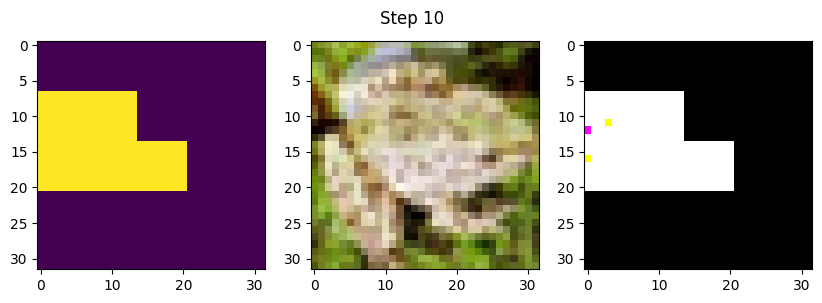

Mean total reward / episode: 0.156


Starting iteration 50

Sampled action: (0, 8)
Value estimate: 0.005955067
Distributions:
[0.24211386 0.26322326 0.23269029 0.26197258]
[0.10264866 0.09691072 0.10113098 0.10105781 0.09437315 0.10342764
 0.10552326 0.10316448 0.09772982 0.09403342]
Actual reward: 0.9


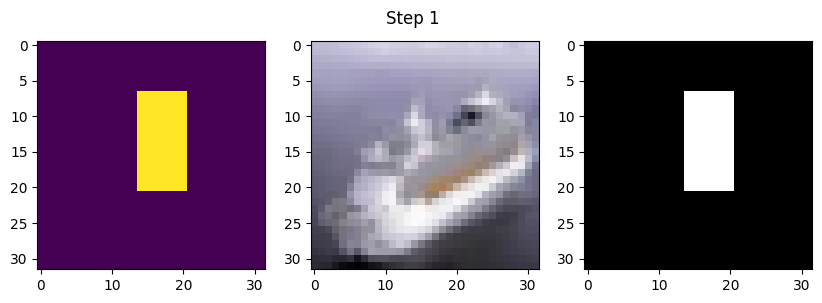

Mean total reward / episode: 0.141


Starting iteration 60

Sampled action: (1, 9)
Value estimate: 0.009120028
Distributions:
[0.24155016 0.26213226 0.23411801 0.26219958]
[0.10193192 0.09640928 0.10084653 0.10143765 0.09484118 0.10341436
 0.10555665 0.10409565 0.09778903 0.09367774]
Actual reward: 0.9


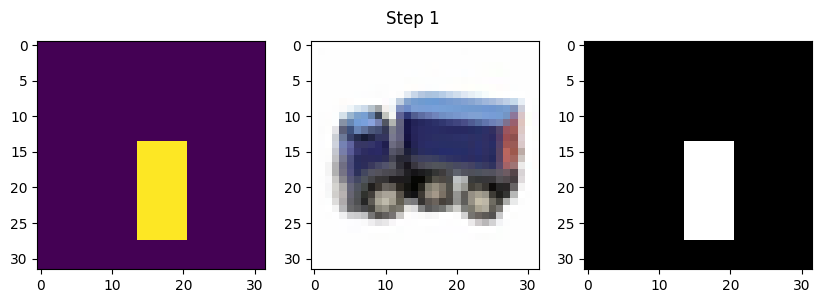

Mean total reward / episode: -0.375


Starting iteration 70

Sampled action: (1, 9)
Value estimate: -0.008737827
Distributions:
[0.24083583 0.26123744 0.23461902 0.26330775]
[0.10136038 0.09678892 0.10142139 0.10166427 0.09495434 0.10272086
 0.10531532 0.10412858 0.09921021 0.09243578]
Actual reward: -0.1

Sampled action: (0, 4)
Value estimate: -0.008737827
Distributions:
[0.24083583 0.26123744 0.23461902 0.26330775]
[0.10136038 0.09678892 0.10142139 0.10166427 0.09495434 0.10272086
 0.10531532 0.10412858 0.09921021 0.09243578]
Actual reward: -0.1

Sampled action: (1, 3)
Value estimate: -0.008737827
Distributions:
[0.24083583 0.26123744 0.23461902 0.26330775]
[0.10136038 0.09678892 0.10142139 0.10166427 0.09495434 0.10272086
 0.10531532 0.10412858 0.09921021 0.09243578]
Actual reward: -0.1

Sampled action: (1, 4)
Value estimate: -0.008737827
Distributions:
[0.24083583 0.26123744 0.23461902 0.26330775]
[0.10136038 0.09678892 0.10142139 0.10166427 0.09495434 0.10272086
 0.10531532 0.10412858 0.09921021 0.09243578]
Actual rew

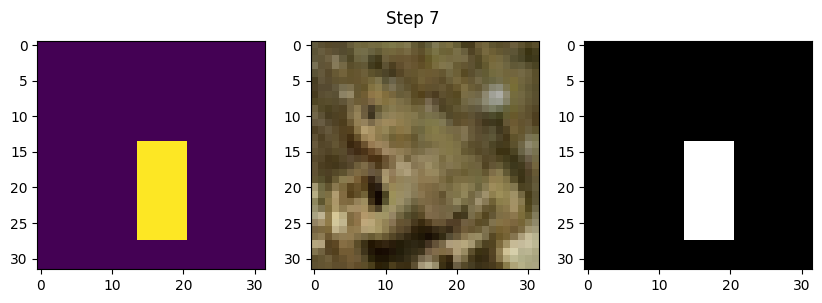

Mean total reward / episode: -0.047


Starting iteration 80

Sampled action: (2, 3)
Value estimate: -0.008303319
Distributions:
[0.23860574 0.26140955 0.23801433 0.2619704 ]
[0.10115944 0.09785566 0.10226551 0.10049865 0.0946899  0.10222447
 0.10463803 0.10439625 0.10071358 0.09155851]
Actual reward: 0.9


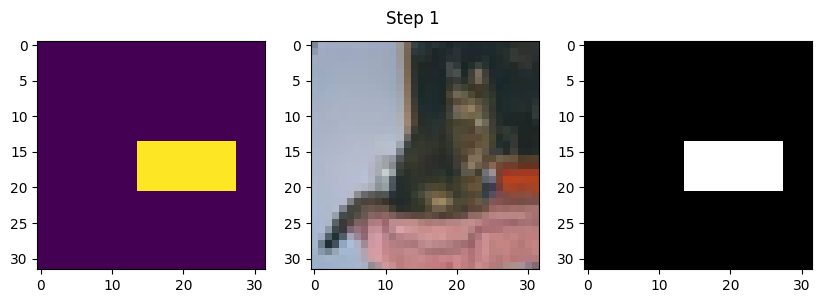

Mean total reward / episode: 0.081


Starting iteration 90

Sampled action: (2, 8)
Value estimate: -0.00041525206
Distributions:
[0.23903951 0.26253763 0.23959127 0.25883162]
[0.10103449 0.09859458 0.10324302 0.09955133 0.09454599 0.10202444
 0.10345171 0.10445975 0.10178433 0.09131039]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: -0.00041525206
Distributions:
[0.23903951 0.26253763 0.23959127 0.25883162]
[0.10103449 0.09859458 0.10324302 0.09955133 0.09454599 0.10202444
 0.10345171 0.10445975 0.10178433 0.09131039]
Actual reward: -0.1

Sampled action: (3, 5)
Value estimate: -0.00041525206
Distributions:
[0.23903951 0.26253763 0.23959127 0.25883162]
[0.10103449 0.09859458 0.10324302 0.09955133 0.09454599 0.10202444
 0.10345171 0.10445975 0.10178433 0.09131039]
Actual reward: -0.1

Sampled action: (2, 1)
Value estimate: -0.00041525206
Distributions:
[0.23903951 0.26253763 0.23959127 0.25883162]
[0.10103449 0.09859458 0.10324302 0.09955133 0.09454599 0.10202444
 0.10345171 0.10445975 0.10178433 0.09131039]
Ac

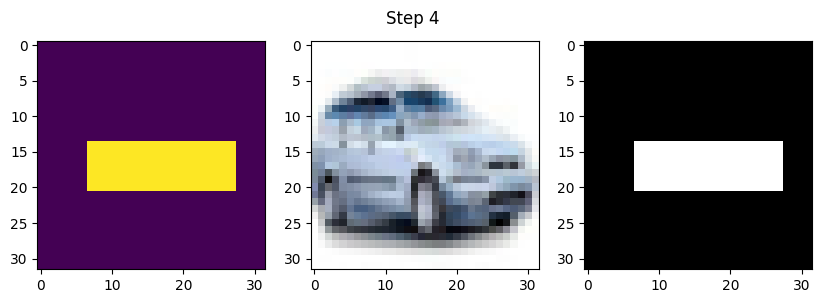

Mean total reward / episode: 0.037


Starting iteration 100

Sampled action: (3, 3)
Value estimate: 0.00014659576
Distributions:
[0.24010672 0.2626623  0.24052225 0.25670874]
[0.10123938 0.09932305 0.10368791 0.09942418 0.09421948 0.10214019
 0.10258452 0.10445467 0.10163499 0.09129164]
Actual reward: -0.1

Sampled action: (1, 1)
Value estimate: 0.00014659576
Distributions:
[0.24010672 0.2626623  0.24052225 0.25670874]
[0.10123938 0.09932305 0.10368791 0.09942418 0.09421948 0.10214019
 0.10258452 0.10445467 0.10163499 0.09129164]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: 0.00014659576
Distributions:
[0.24010672 0.2626623  0.24052225 0.25670874]
[0.10123938 0.09932305 0.10368791 0.09942418 0.09421948 0.10214019
 0.10258452 0.10445467 0.10163499 0.09129164]
Actual reward: -0.1

Sampled action: (1, 3)
Value estimate: 0.00014659576
Distributions:
[0.24010672 0.2626623  0.24052225 0.25670874]
[0.10123938 0.09932305 0.10368791 0.09942418 0.09421948 0.10214019
 0.10258452 0.10445467 0.10163499 0.09129164]
Actua

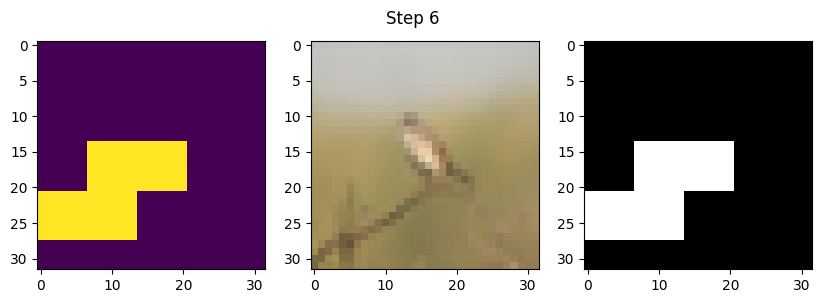

Mean total reward / episode: -0.144


Starting iteration 110

Sampled action: (2, 6)
Value estimate: -0.004112928
Distributions:
[0.23963009 0.26381212 0.2402093  0.2563486 ]
[0.10090284 0.09945945 0.1036626  0.09854358 0.09316298 0.10256482
 0.1027953  0.1058156  0.10156929 0.09152363]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: -0.004112928
Distributions:
[0.23963009 0.26381212 0.2402093  0.2563486 ]
[0.10090284 0.09945945 0.1036626  0.09854358 0.09316298 0.10256482
 0.1027953  0.1058156  0.10156929 0.09152363]
Actual reward: -0.1

Sampled action: (1, 6)
Value estimate: -0.004112928
Distributions:
[0.23963009 0.26381212 0.2402093  0.2563486 ]
[0.10090284 0.09945945 0.1036626  0.09854358 0.09316298 0.10256482
 0.1027953  0.1058156  0.10156929 0.09152363]
Actual reward: -0.1

Sampled action: (3, 7)
Value estimate: -0.004112928
Distributions:
[0.23963009 0.26381212 0.2402093  0.2563486 ]
[0.10090284 0.09945945 0.1036626  0.09854358 0.09316298 0.10256482
 0.1027953  0.1058156  0.10156929 0.09152363]
Actual re

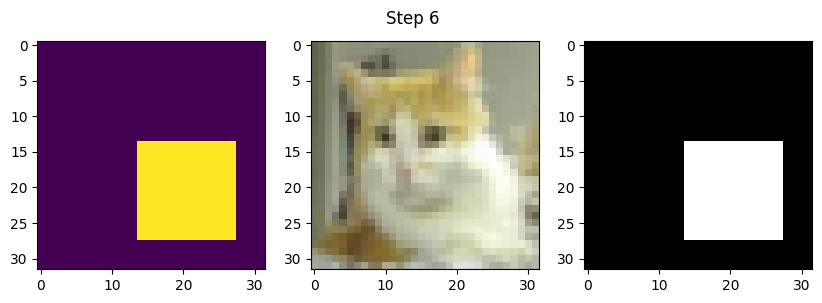

Mean total reward / episode: 0.081


Starting iteration 120

Sampled action: (0, 4)
Value estimate: 0.005965415
Distributions:
[0.23997848 0.26231146 0.23844948 0.2592606 ]
[0.09995379 0.09866732 0.10419165 0.09840085 0.09349909 0.10336177
 0.10361977 0.10546848 0.10133023 0.09150704]
Actual reward: -0.1

Sampled action: (2, 6)
Value estimate: 0.005965415
Distributions:
[0.23997848 0.26231146 0.23844948 0.2592606 ]
[0.09995379 0.09866732 0.10419165 0.09840085 0.09349909 0.10336177
 0.10361977 0.10546848 0.10133023 0.09150704]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: 0.005965415
Distributions:
[0.23997848 0.26231146 0.23844948 0.2592606 ]
[0.09995379 0.09866732 0.10419165 0.09840085 0.09349909 0.10336177
 0.10361977 0.10546848 0.10133023 0.09150704]
Actual reward: -0.1

Sampled action: (1, 9)
Value estimate: 0.005965415
Distributions:
[0.23997848 0.26231146 0.23844948 0.2592606 ]
[0.09995379 0.09866732 0.10419165 0.09840085 0.09349909 0.10336177
 0.10361977 0.10546848 0.10133023 0.09150704]
Actual reward

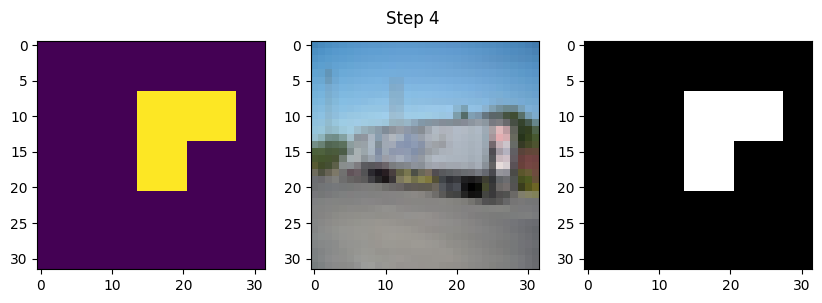

Mean total reward / episode: -0.038


Starting iteration 130

Sampled action: (0, 0)
Value estimate: 0.0063371845
Distributions:
[0.24089116 0.2612897  0.2383687  0.25945038]
[0.09960705 0.0977822  0.10425325 0.09822293 0.0939161  0.10378492
 0.10407825 0.10486227 0.10124401 0.09224892]
Actual reward: -0.1

Sampled action: (0, 3)
Value estimate: 0.0063371845
Distributions:
[0.24089116 0.2612897  0.2383687  0.25945038]
[0.09960705 0.0977822  0.10425325 0.09822293 0.0939161  0.10378492
 0.10407825 0.10486227 0.10124401 0.09224892]
Actual reward: -0.1

Sampled action: (2, 2)
Value estimate: 0.0063371845
Distributions:
[0.24089116 0.2612897  0.2383687  0.25945038]
[0.09960705 0.0977822  0.10425325 0.09822293 0.0939161  0.10378492
 0.10407825 0.10486227 0.10124401 0.09224892]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: 0.0063371845
Distributions:
[0.24089116 0.2612897  0.2383687  0.25945038]
[0.09960705 0.0977822  0.10425325 0.09822293 0.0939161  0.10378492
 0.10407825 0.10486227 0.10124401 0.09224892]
Actual re

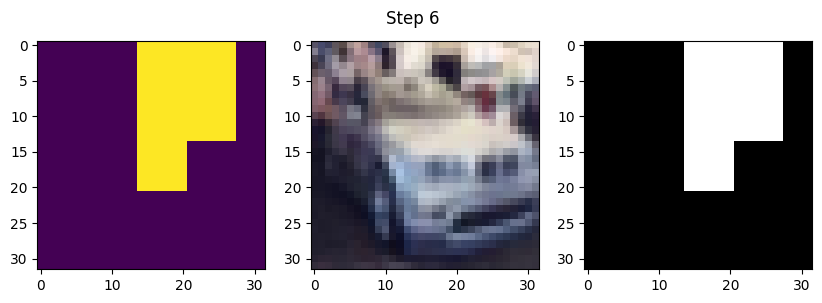

Mean total reward / episode: 0.066


Starting iteration 140

Sampled action: (1, 2)
Value estimate: -0.00442086
Distributions:
[0.24047719 0.26281658 0.24029766 0.2564085 ]
[0.10005349 0.09741186 0.1036733  0.09809848 0.09375779 0.10369158
 0.10457422 0.10541248 0.10094824 0.0923785 ]
Actual reward: -0.1

Sampled action: (0, 2)
Value estimate: -0.00442086
Distributions:
[0.24047719 0.26281658 0.24029766 0.2564085 ]
[0.10005349 0.09741186 0.1036733  0.09809848 0.09375779 0.10369158
 0.10457422 0.10541248 0.10094824 0.0923785 ]
Actual reward: -0.1

Sampled action: (1, 2)
Value estimate: -0.00442086
Distributions:
[0.24047719 0.26281658 0.24029766 0.2564085 ]
[0.10005349 0.09741186 0.1036733  0.09809848 0.09375779 0.10369158
 0.10457422 0.10541248 0.10094824 0.0923785 ]
Actual reward: -0.1

Sampled action: (3, 0)
Value estimate: -0.00442086
Distributions:
[0.24047719 0.26281658 0.24029766 0.2564085 ]
[0.10005349 0.09741186 0.1036733  0.09809848 0.09375779 0.10369158
 0.10457422 0.10541248 0.10094824 0.0923785 ]
Actual reward

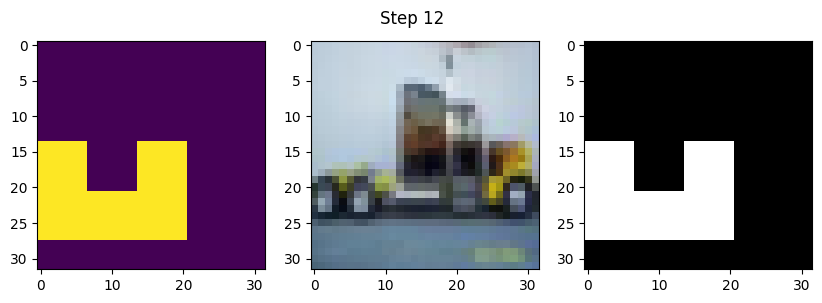

Mean total reward / episode: -0.025


Starting iteration 150

Sampled action: (0, 3)
Value estimate: -0.009030679
Distributions:
[0.24075384 0.2619034  0.24143374 0.25590906]
[0.09892849 0.09727675 0.10440733 0.09843837 0.09411418 0.10359105
 0.10475523 0.10574311 0.10008289 0.09266263]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: -0.009030679
Distributions:
[0.24075384 0.2619034  0.24143374 0.25590906]
[0.09892849 0.09727675 0.10440733 0.09843837 0.09411418 0.10359105
 0.10475523 0.10574311 0.10008289 0.09266263]
Actual reward: -0.1

Sampled action: (3, 8)
Value estimate: -0.009030679
Distributions:
[0.24075384 0.2619034  0.24143374 0.25590906]
[0.09892849 0.09727675 0.10440733 0.09843837 0.09411418 0.10359105
 0.10475523 0.10574311 0.10008289 0.09266263]
Actual reward: -0.1

Sampled action: (3, 2)
Value estimate: -0.009030679
Distributions:
[0.24075384 0.2619034  0.24143374 0.25590906]
[0.09892849 0.09727675 0.10440733 0.09843837 0.09411418 0.10359105
 0.10475523 0.10574311 0.10008289 0.09266263]
Actual re

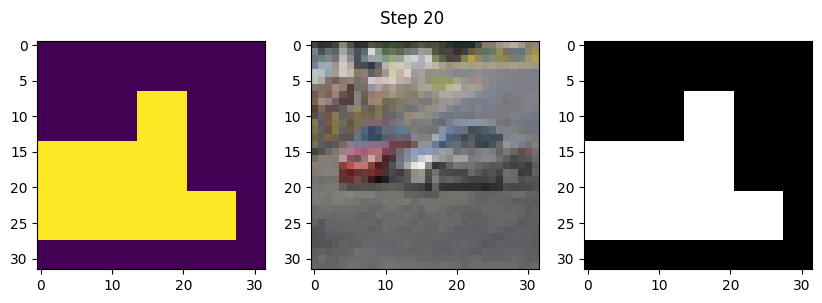

Mean total reward / episode: -0.119


Starting iteration 160

Sampled action: (2, 5)
Value estimate: -0.0016563982
Distributions:
[0.24082167 0.26017785 0.24133813 0.25766236]
[0.0976126  0.09836858 0.10423978 0.09804583 0.09518596 0.10402557
 0.10445695 0.10566033 0.09985273 0.09255163]
Actual reward: -0.1

Sampled action: (1, 2)
Value estimate: -0.0016563982
Distributions:
[0.24082167 0.26017785 0.24133813 0.25766236]
[0.0976126  0.09836858 0.10423978 0.09804583 0.09518596 0.10402557
 0.10445695 0.10566033 0.09985273 0.09255163]
Actual reward: -0.1

Sampled action: (1, 9)
Value estimate: -0.0016563982
Distributions:
[0.24082167 0.26017785 0.24133813 0.25766236]
[0.0976126  0.09836858 0.10423978 0.09804583 0.09518596 0.10402557
 0.10445695 0.10566033 0.09985273 0.09255163]
Actual reward: -0.1

Sampled action: (1, 9)
Value estimate: -0.0016563982
Distributions:
[0.24082167 0.26017785 0.24133813 0.25766236]
[0.0976126  0.09836858 0.10423978 0.09804583 0.09518596 0.10402557
 0.10445695 0.10566033 0.09985273 0.09255163]
Actua

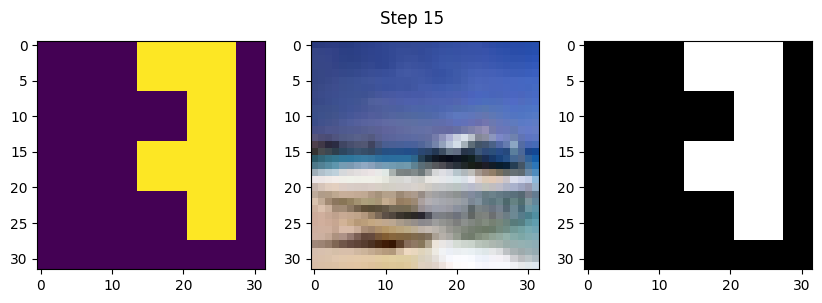

Mean total reward / episode: 0.203


Starting iteration 170

Sampled action: (3, 4)
Value estimate: 0.0021544583
Distributions:
[0.24280255 0.25957718 0.24018675 0.25743356]
[0.09676713 0.09876751 0.10377017 0.09816298 0.09650403 0.10408841
 0.10532132 0.10496715 0.09963821 0.09201314]
Actual reward: -0.1

Sampled action: (1, 9)
Value estimate: 0.0021544583
Distributions:
[0.24280255 0.25957718 0.24018675 0.25743356]
[0.09676713 0.09876751 0.10377017 0.09816298 0.09650403 0.10408841
 0.10532132 0.10496715 0.09963821 0.09201314]
Actual reward: -0.1

Sampled action: (3, 5)
Value estimate: 0.0021544583
Distributions:
[0.24280255 0.25957718 0.24018675 0.25743356]
[0.09676713 0.09876751 0.10377017 0.09816298 0.09650403 0.10408841
 0.10532132 0.10496715 0.09963821 0.09201314]
Actual reward: -0.1

Sampled action: (3, 5)
Value estimate: 0.0021544583
Distributions:
[0.24280255 0.25957718 0.24018675 0.25743356]
[0.09676713 0.09876751 0.10377017 0.09816298 0.09650403 0.10408841
 0.10532132 0.10496715 0.09963821 0.09201314]
Actual re

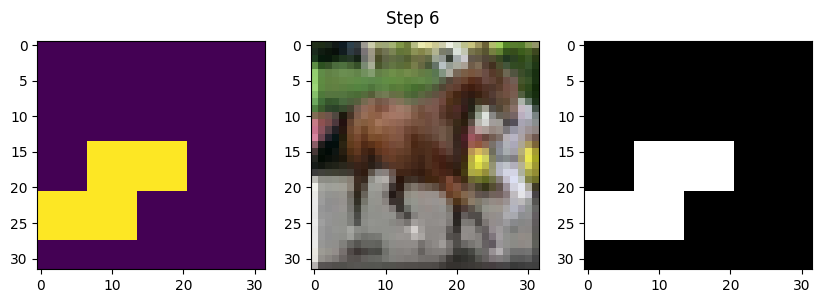

Mean total reward / episode: -0.084


Starting iteration 180

Sampled action: (0, 4)
Value estimate: -0.0001715608
Distributions:
[0.24493465 0.26185262 0.23814552 0.25506726]
[0.09526633 0.09978067 0.10379474 0.09807977 0.09761363 0.1031149
 0.10634322 0.10521226 0.09948102 0.09131352]
Actual reward: -0.1

Sampled action: (0, 5)
Value estimate: -0.0001715608
Distributions:
[0.24493465 0.26185262 0.23814552 0.25506726]
[0.09526633 0.09978067 0.10379474 0.09807977 0.09761363 0.1031149
 0.10634322 0.10521226 0.09948102 0.09131352]
Actual reward: 0.9


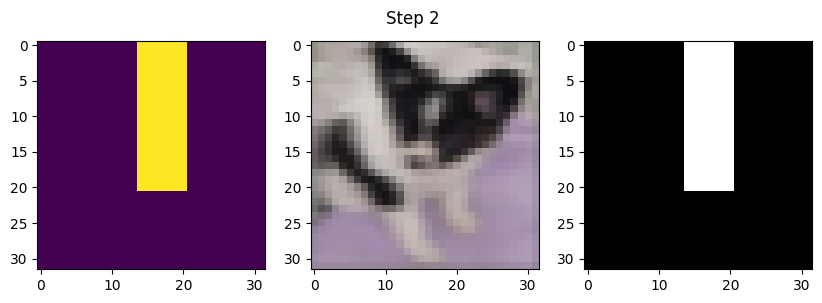

Mean total reward / episode: -0.200


Starting iteration 190

Sampled action: (1, 1)
Value estimate: 0.004061692
Distributions:
[0.24687114 0.26361883 0.23590206 0.253608  ]
[0.09430308 0.10089893 0.10385779 0.0982522  0.09772048 0.10226069
 0.10661524 0.10624456 0.09945954 0.09038747]
Actual reward: -0.1

Sampled action: (1, 0)
Value estimate: 0.004061692
Distributions:
[0.24687114 0.26361883 0.23590206 0.253608  ]
[0.09430308 0.10089893 0.10385779 0.0982522  0.09772048 0.10226069
 0.10661524 0.10624456 0.09945954 0.09038747]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: 0.004061692
Distributions:
[0.24687114 0.26361883 0.23590206 0.253608  ]
[0.09430308 0.10089893 0.10385779 0.0982522  0.09772048 0.10226069
 0.10661524 0.10624456 0.09945954 0.09038747]
Actual reward: -0.1

Sampled action: (2, 3)
Value estimate: 0.004061692
Distributions:
[0.24687114 0.26361883 0.23590206 0.253608  ]
[0.09430308 0.10089893 0.10385779 0.0982522  0.09772048 0.10226069
 0.10661524 0.10624456 0.09945954 0.09038747]
Actual reward

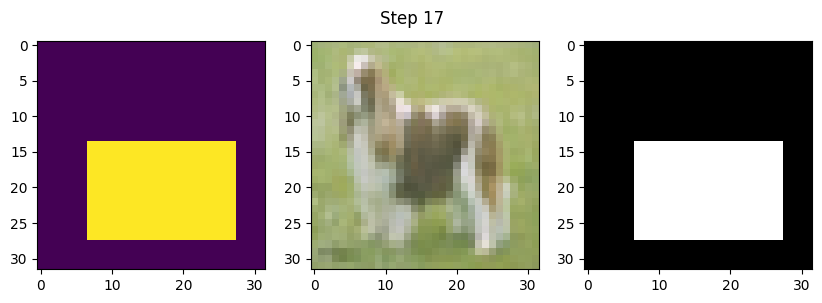

Mean total reward / episode: -0.169
Completed 200 iterations of 32 episodes in 196.343 s
Testing...
Mean total reward / episode: -0.026
Evaluating...



Sampled action: (1, 0)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 1


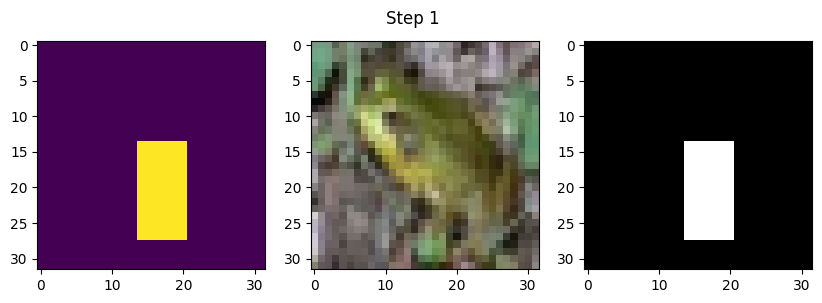


Sampled action: (1, 3)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 2


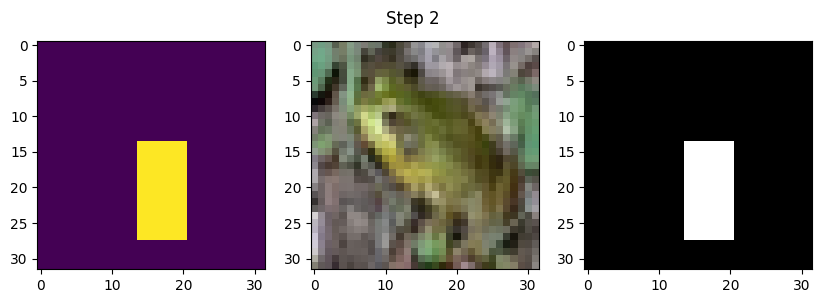


Sampled action: (2, 9)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 3


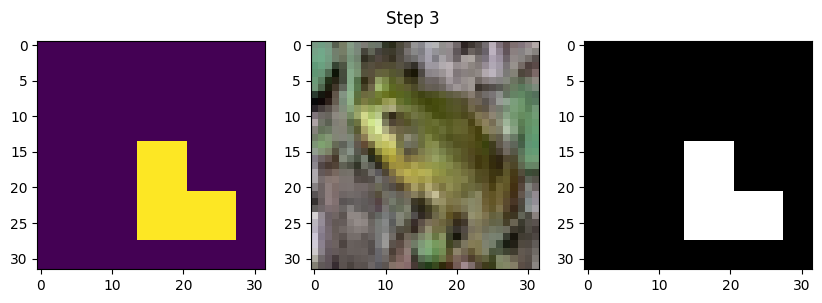


Sampled action: (0, 1)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 4


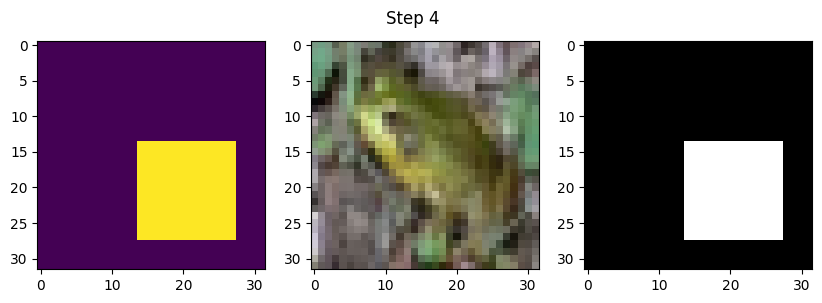


Sampled action: (0, 4)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 5


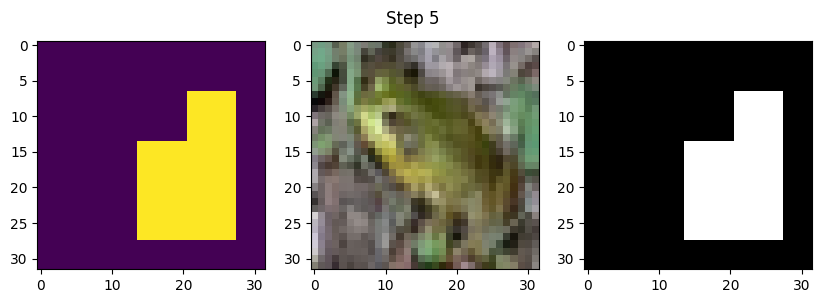


Sampled action: (2, 3)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 6


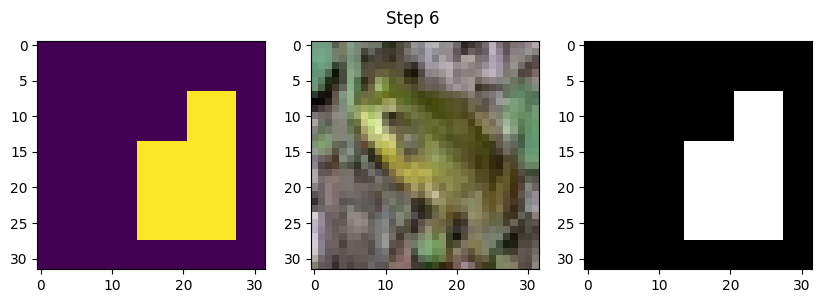


Sampled action: (2, 2)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 7


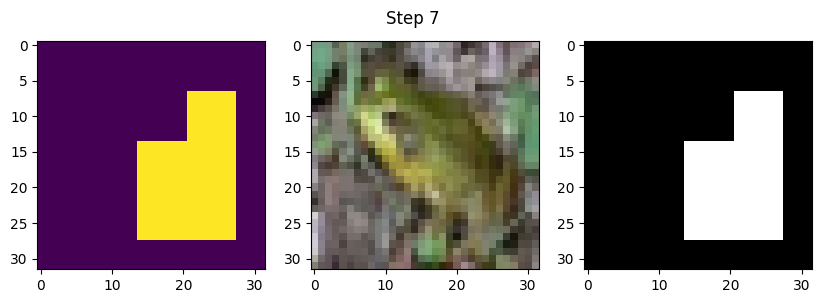


Sampled action: (3, 6)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward 0.9 on step 8


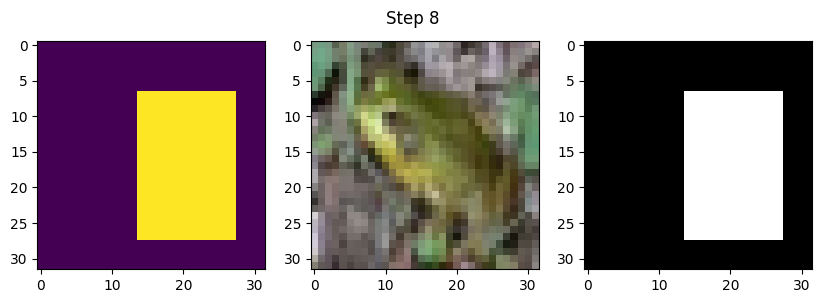


Sampled action: (0, 4)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 1


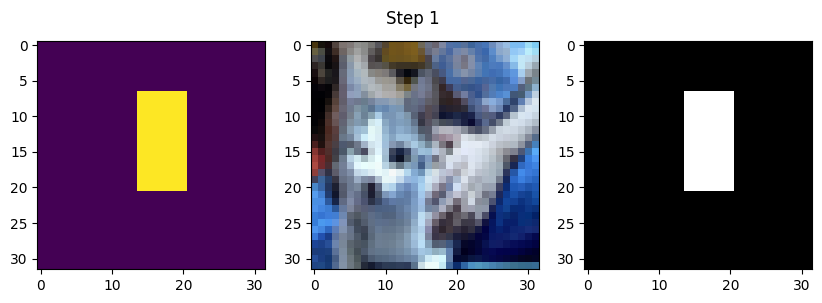


Sampled action: (0, 8)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 2


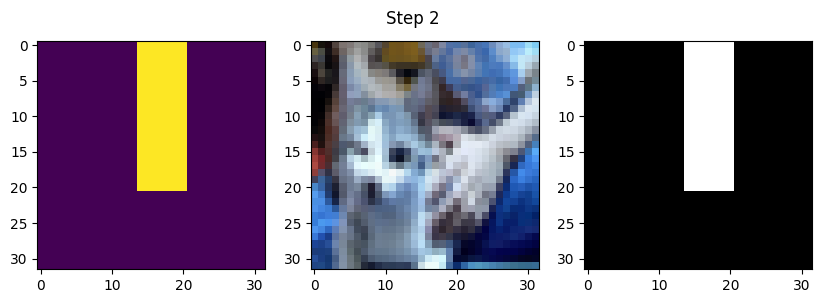


Sampled action: (1, 6)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 3


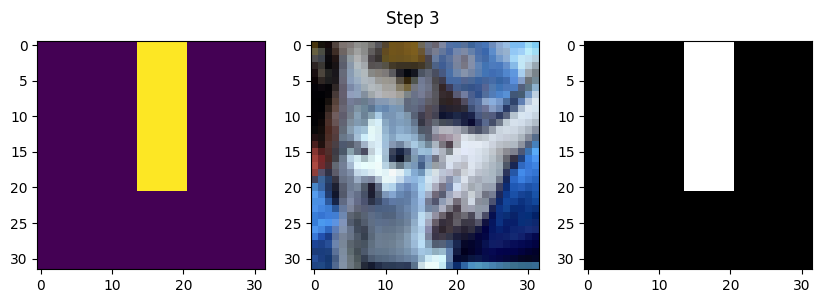


Sampled action: (1, 1)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 4


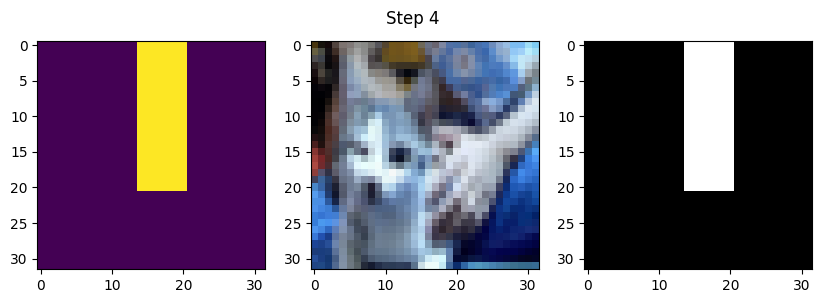


Sampled action: (3, 7)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 5


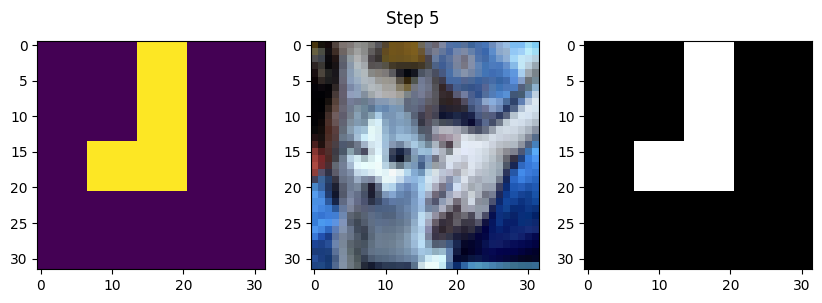


Sampled action: (0, 5)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 6


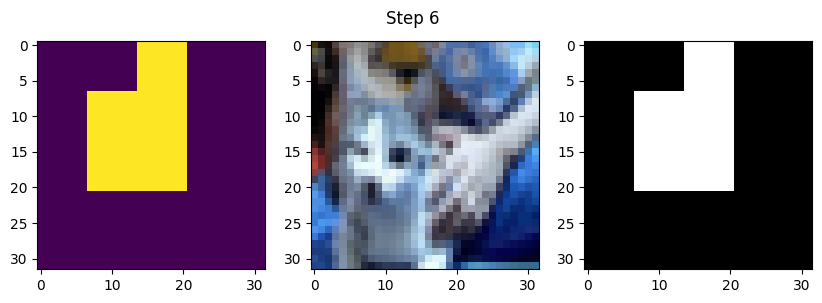


Sampled action: (3, 6)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 7


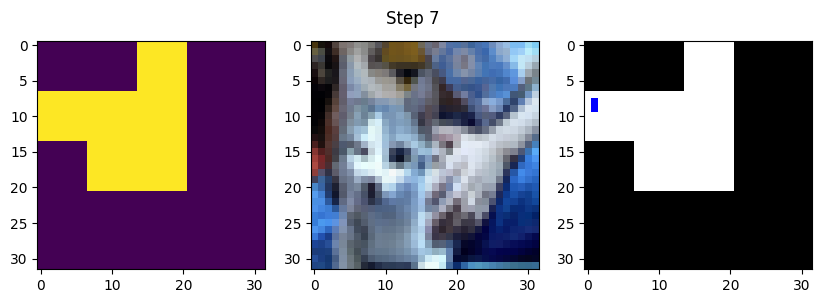


Sampled action: (0, 2)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 8


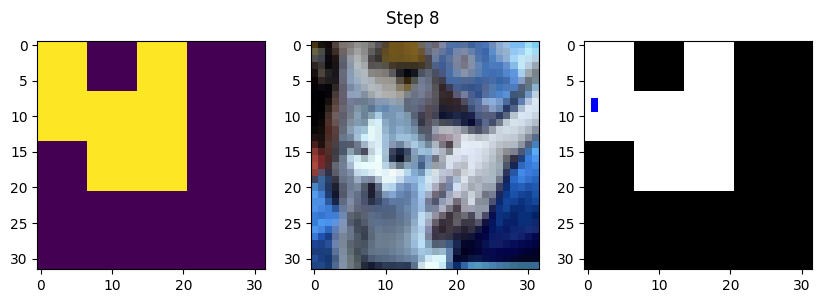


Sampled action: (3, 2)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 9


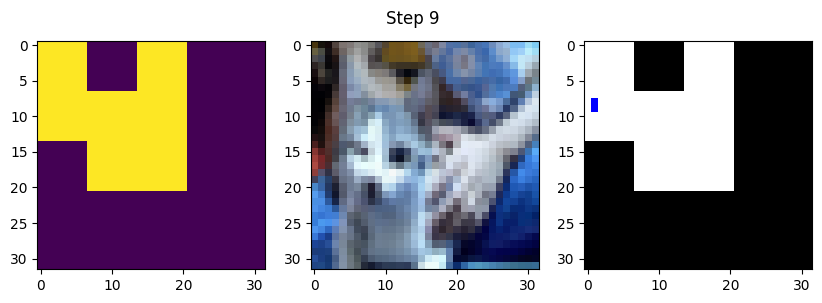


Sampled action: (0, 0)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 10


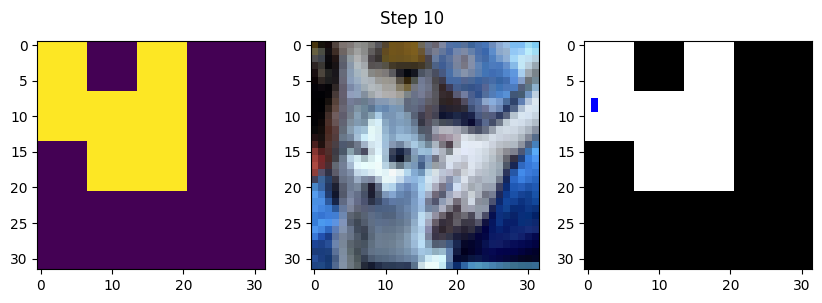


Sampled action: (1, 6)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 11


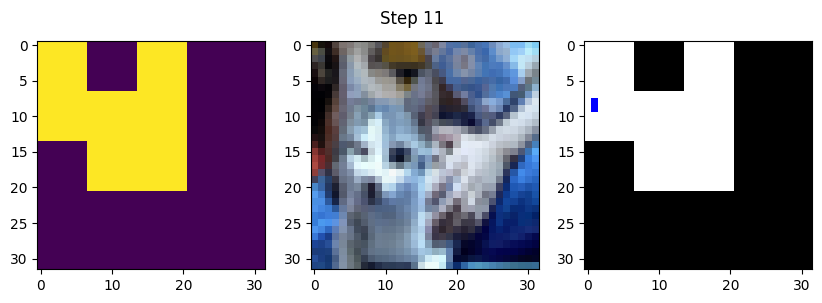


Sampled action: (2, 3)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward 0.9 on step 12


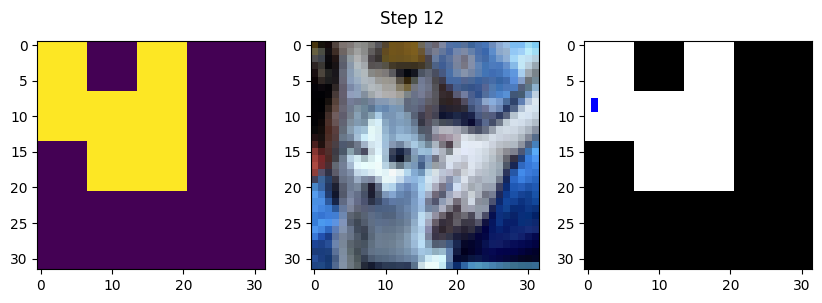


Sampled action: (1, 0)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 1


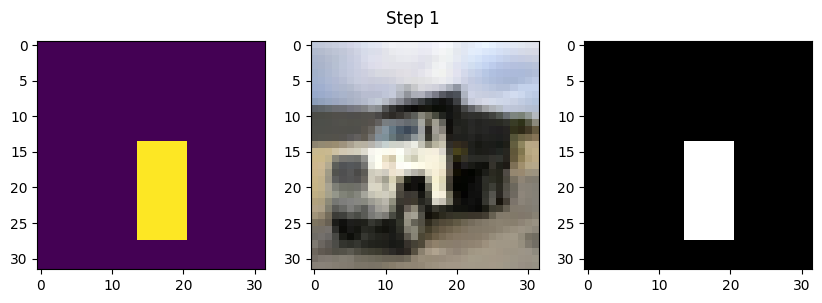


Sampled action: (0, 3)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 2


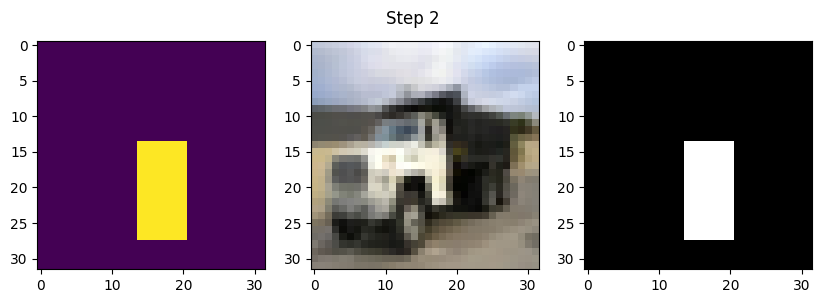


Sampled action: (3, 6)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 3


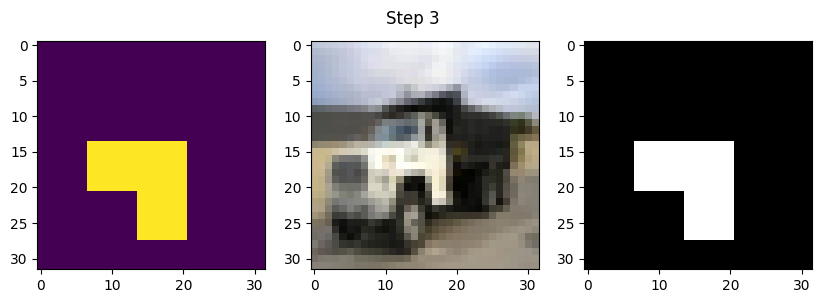


Sampled action: (2, 1)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 4


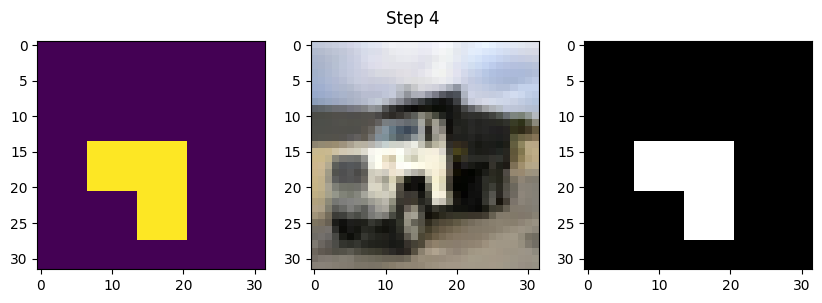


Sampled action: (3, 8)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 5


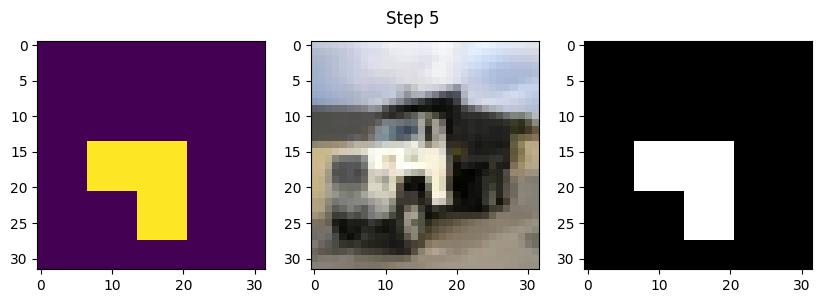


Sampled action: (1, 3)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 6


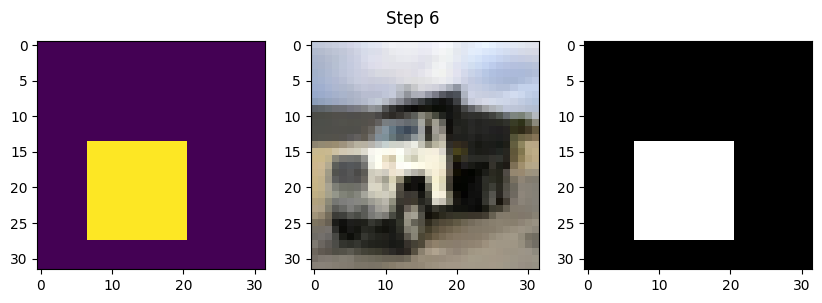


Sampled action: (0, 7)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 7


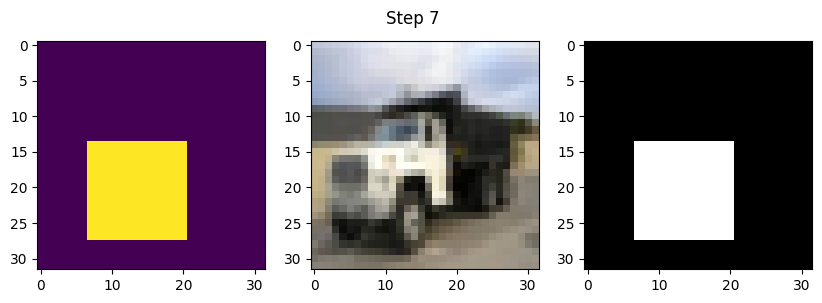


Sampled action: (3, 7)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 8


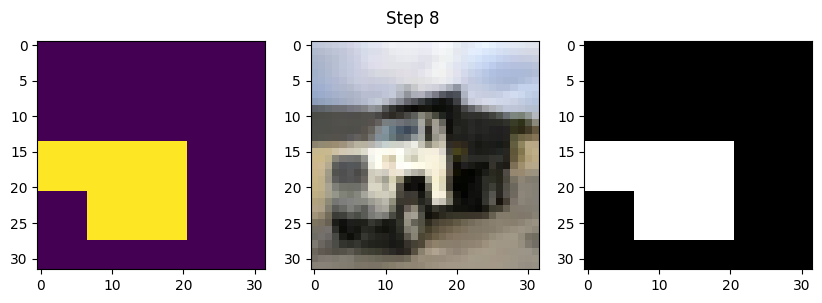


Sampled action: (3, 5)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 9


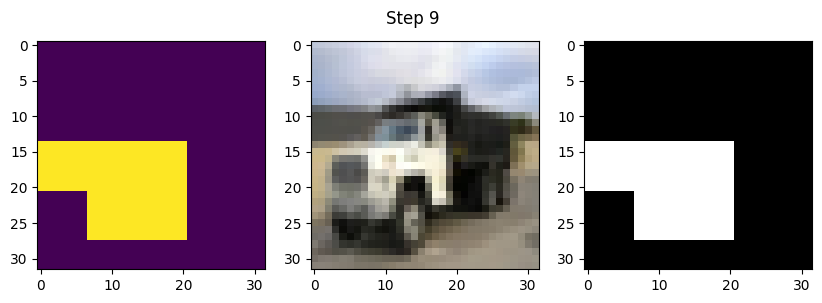


Sampled action: (2, 6)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 10


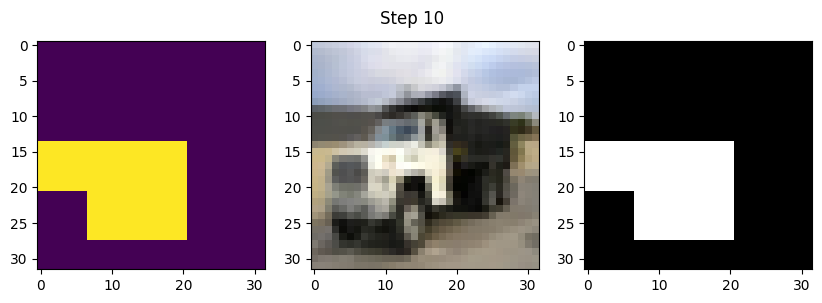


Sampled action: (2, 9)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward 0.9 on step 11


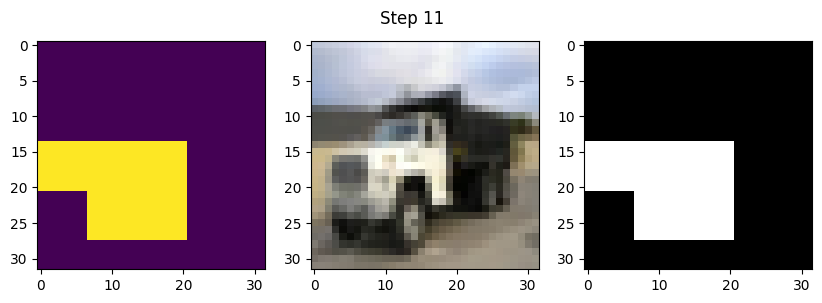


Sampled action: (1, 8)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 1


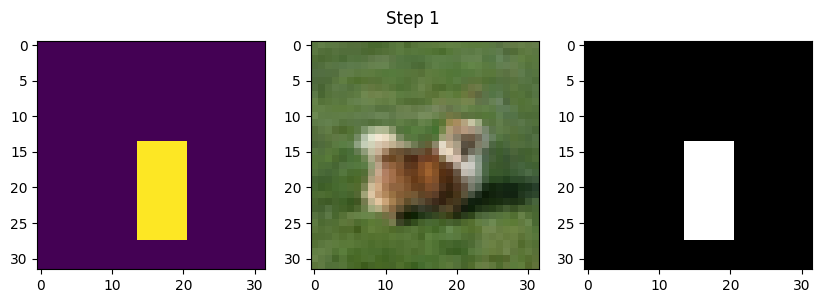


Sampled action: (3, 5)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward 0.9 on step 2


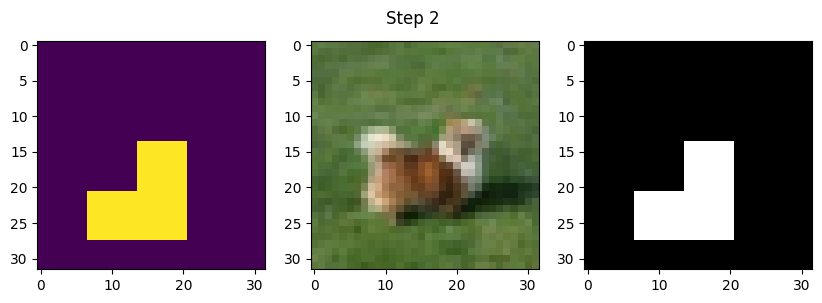


Sampled action: (3, 7)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 1


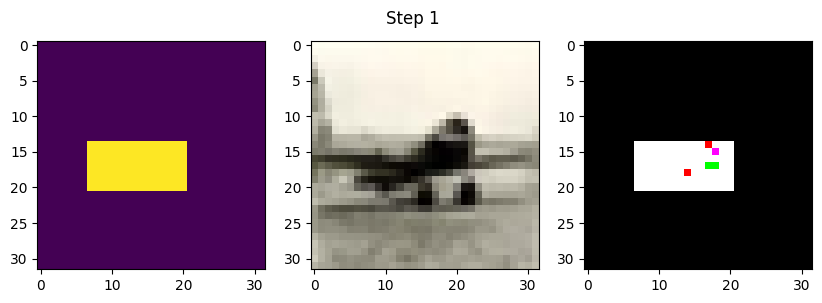


Sampled action: (3, 7)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 2


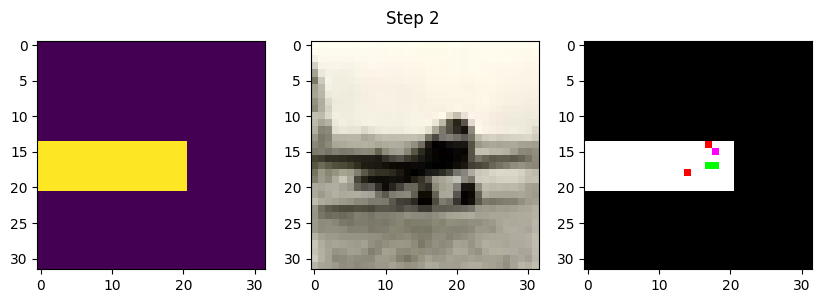


Sampled action: (0, 2)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 3


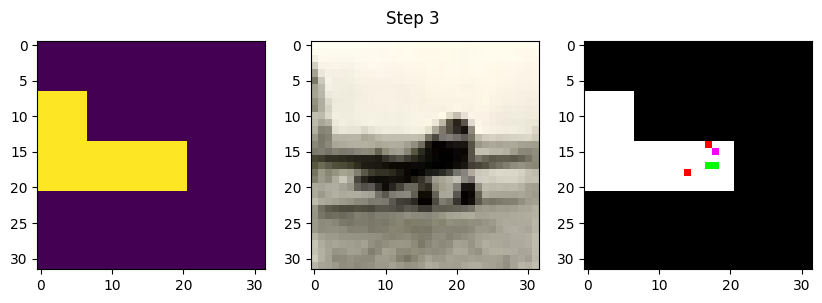


Sampled action: (2, 7)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 4


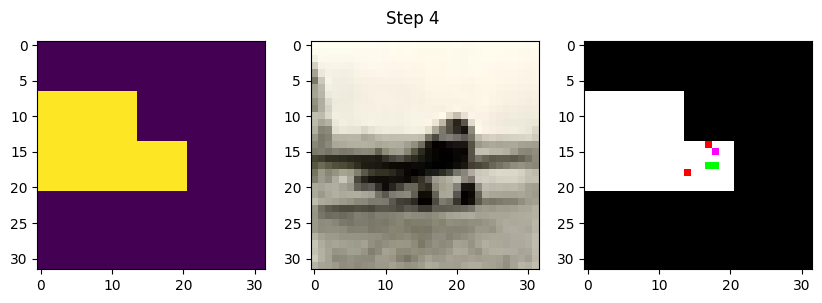


Sampled action: (1, 2)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 5


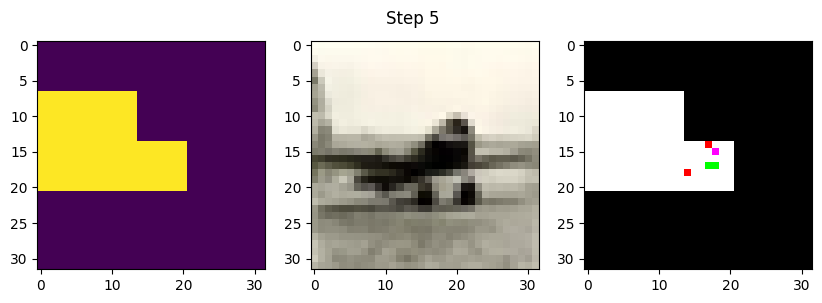


Sampled action: (2, 7)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 6


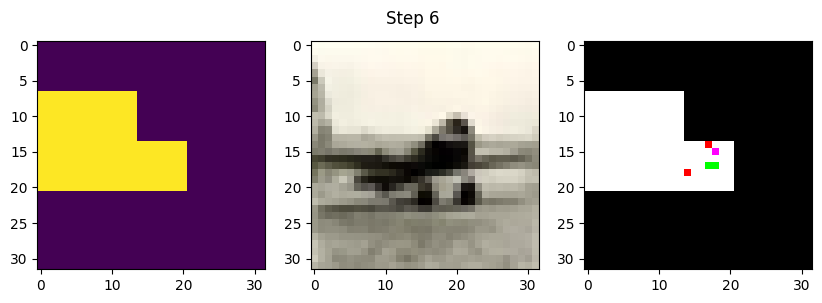


Sampled action: (0, 9)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 7


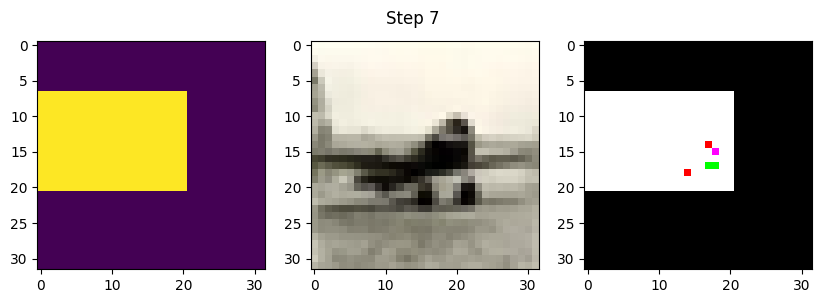


Sampled action: (0, 3)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward -0.1 on step 8


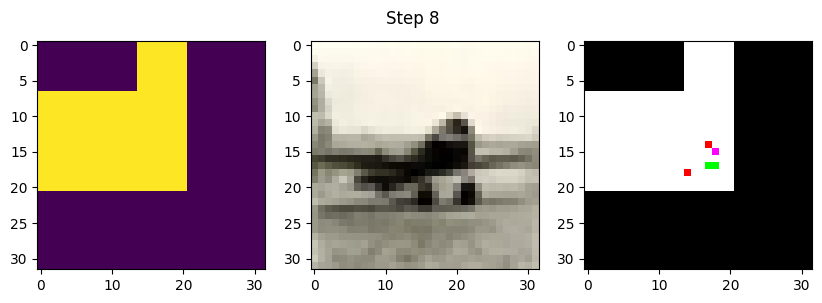


Sampled action: (0, 0)
Value estimate: -0.005910571
Distributions:
[0.24734512 0.26199183 0.23396365 0.2566994 ]
[0.09462628 0.10137475 0.10441329 0.09962754 0.09697124 0.10168256
 0.10673761 0.10524939 0.09936167 0.08995572]
Received reward 0.9 on step 9


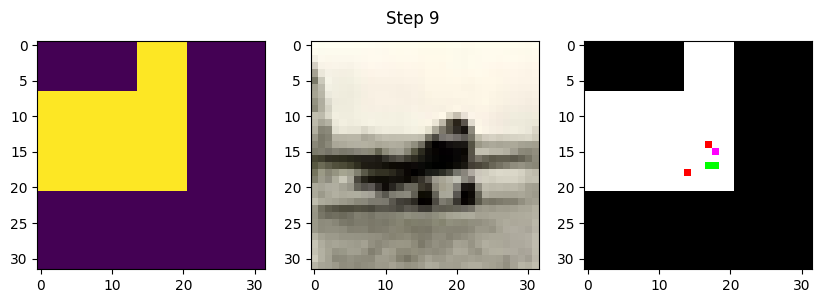

In [ ]:
# from cifar10_env import CIFAR10Env
# from actor_critic_agent import CIFAR10Net, ActorCriticNNAgent
import numpy as np
import time
import argparse
import sys

def main():
    batch_size = 32
    iters = 200
    verbose = True

    print("Training...")
    trained_agent = train(iters, batch_size, verbose=verbose)
    test_agent = trained_agent.copy()

    print("Testing...")
    test(test_agent)

    print("Evaluating...")
    for _ in range(5):
        eval(test_agent)

def train(iterations, episodes, verbose=False):
    ''' Method to train a model, currently fixed on
    using ActorCritic; will change when updated to use
    modular DeepRL env'''

    def obs_to_input(obs):
        # Convert observation to PyTorch tensor and normalize
        return obs.transpose(2, 0, 1) / 255.0

    # Initialize agent
    agent = ActorCriticNNAgent(CIFAR10Net, obs_to_input=obs_to_input, df=0.1)

    # Initialize environment
    env = CIFAR10Env(type='train', seed=None)

    # Training loop
    start = time.time()
    for iter in range(iterations):

        if iter % 10 == 0: print("Starting iteration %d" % iter)
        rewards = []

        # Play out each episode
        for ep in range(episodes):

            if verbose and iter % 10 == 0 and ep == 0:
                display = True
            else:
                display = False

            observation = env.reset()
            agent.new_episode()
            total_reward = 0

            done = False
            while not done:

                action = agent.act(observation, env, display=display)
                observation, reward, done, info = env.step(action)

                if display: print("Actual reward:", reward)
                agent.store_reward(reward)
                total_reward += reward

            rewards.append(total_reward)

            if display: env.render()

        # Adjust agent parameters based on played episodes
        agent.update()

        # Print performance for this iteration
        if iter % 10 == 0:
            print("Mean total reward / episode: %.3f" % np.mean(rewards))

    end = time.time()
    print("Completed %d iterations of %d episodes in %.3f s" % \
          (iterations, episodes, end - start))

    # Return trained agent
    return agent

def eval(agent, n_test=1000):
    # Evaluate a trained agent

    env = CIFAR10Env(type='test', seed=None)

    observation = env.reset()

    done = False
    while not done:

        action = agent.act(observation, env, display=True)
        observation, reward, done, info = env.step(action)

        print("Received reward %.1f on step %d" % (reward, env.steps))
        env.render()

def test(agent, n_test=1000):
    # Calculate test average reward

    env = CIFAR10Env(type='test', seed=None)

    rewards = []
    for _ in range(n_test):

        observation = env.reset()
        total_reward = 0

        done = False
        while not done:

            action = agent.act(observation, env, display=False)
            observation, reward, done, info = env.step(action)

            total_reward += reward

        rewards.append(total_reward)

    print("Mean total reward / episode: %.3f" % np.mean(rewards))

if __name__ == '__main__':

    main()


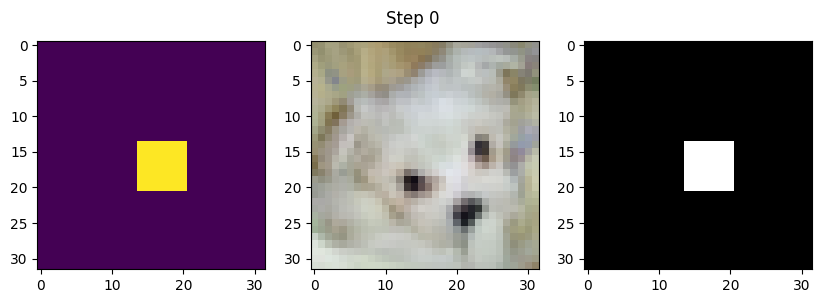

<ipython-input-38-5a1db3df72ec>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = -0.1 + int(Y_pred == self.Y[self.i])


Agent moved East
Agent guessed 0
Received reward -0.1 on step 1


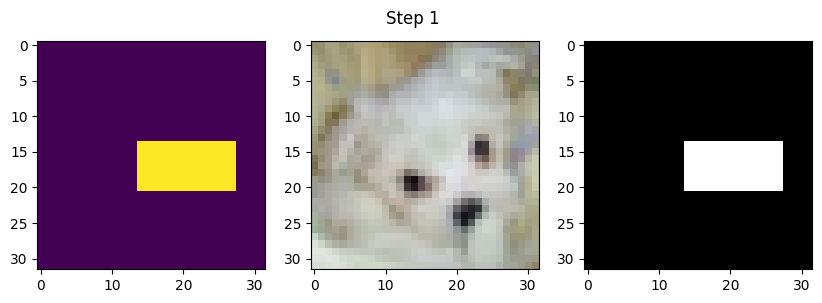

Agent moved West
Agent guessed 2
Received reward -0.1 on step 2


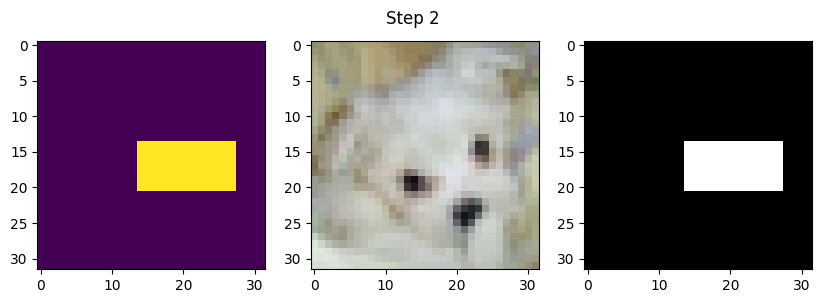

Agent moved South
Agent guessed 2
Received reward -0.1 on step 3


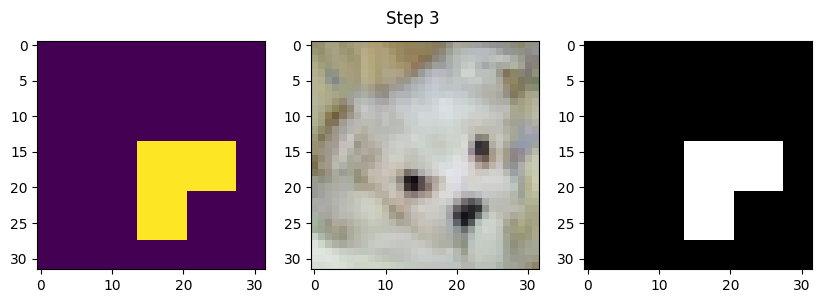

Agent moved North
Agent guessed 6
Received reward -0.1 on step 4


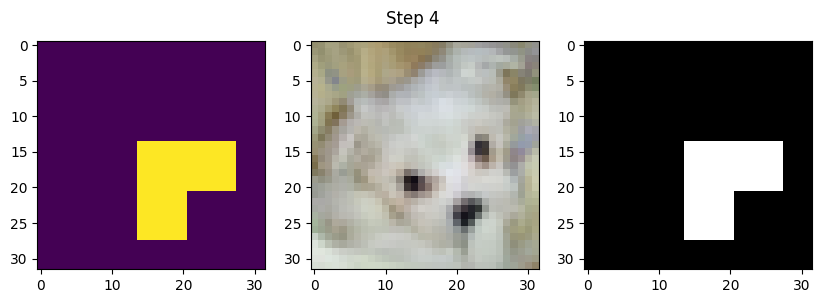

Agent moved East
Agent guessed 9
Received reward -0.1 on step 5


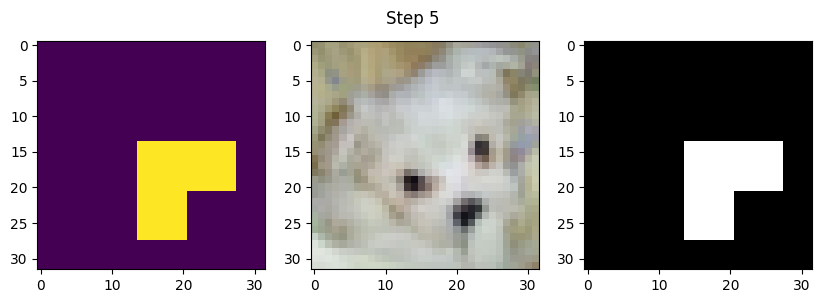

Agent moved East
Agent guessed 2
Received reward -0.1 on step 6


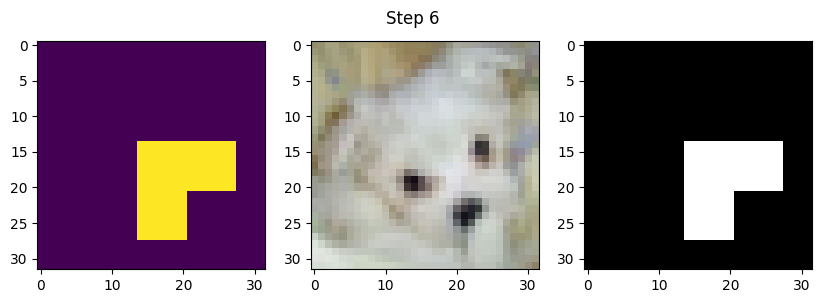

Agent moved West
Agent guessed 8
Received reward -0.1 on step 7


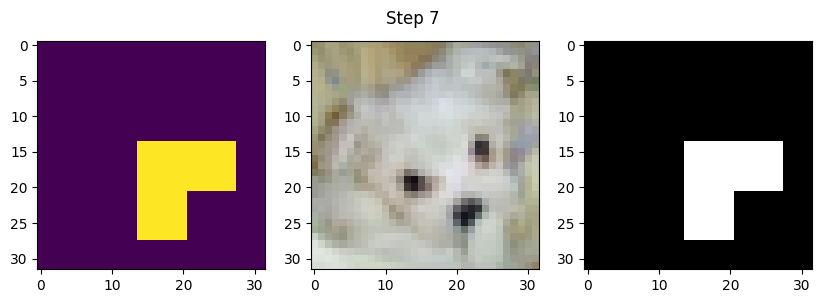

Agent moved North
Agent guessed 1
Received reward -0.1 on step 8


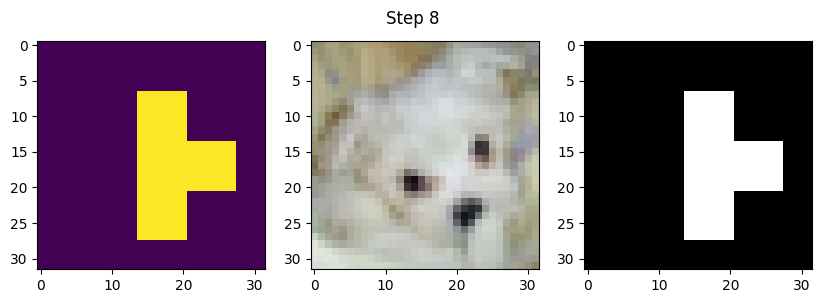

Agent moved West
Agent guessed 1
Received reward -0.1 on step 9


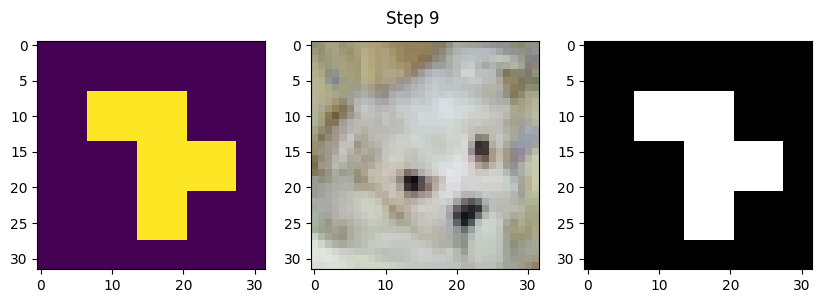

Agent moved South
Agent guessed 9
Received reward -0.1 on step 10


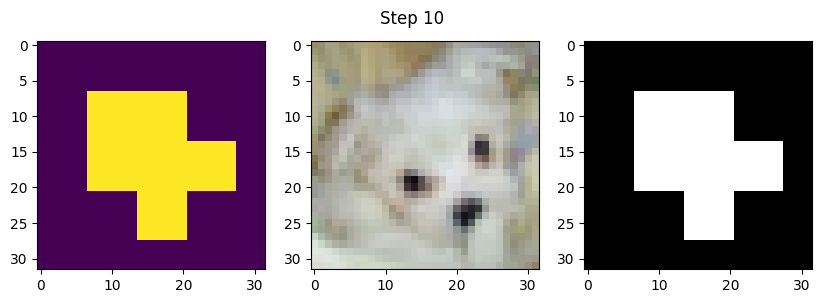

Agent moved East
Agent guessed 6
Received reward -0.1 on step 11


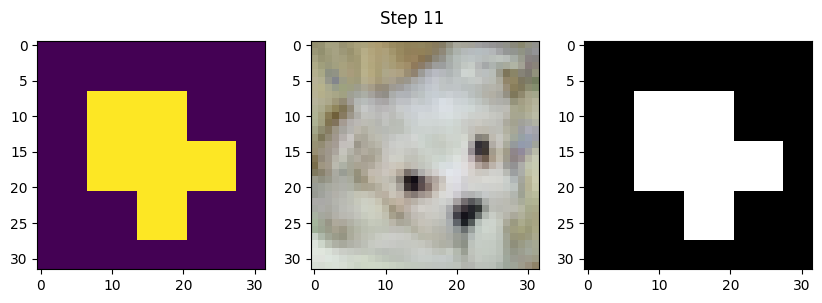

Agent moved East
Agent guessed 0
Received reward -0.1 on step 12


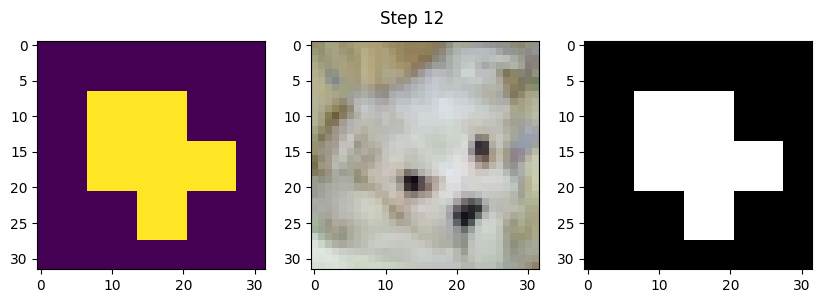

Agent moved North
Agent guessed 5
Received reward 0.9 on step 13


In [ ]:

env = CIFAR10Env(type='train', seed=None)

obs = env.reset()
done = False

while not done:
    env.render()
    action = env.action_space.sample()
    dir, Y_pred = action % 4, action // 4
    print("Agent moved %s" % (['North', 'South', 'East', 'West'][dir]))
    print("Agent guessed %d" % Y_pred)

    _, reward, done, _ = env.step(action)
    print("Received reward %.1f on step %d" % (reward, env.steps))